# A tutorial on how to correct the hysteresis in a write path.

## NOTE: only works for x raster at the moment.

#### DO NOT CORRECT YOUR PATH IN HERE, KEEP THIS NOTEBOOK TIDY SO IT CAN BE UNDERSTOOD EASILY

#### The hysteresis here is modeled with a sin function. The paper with the technique to calculate the hysteresis for a set of images is https://pubs.aip.org/aip/rsi/article/90/2/023704/361826 (A method to correct hysteresis of scanning probe microscope images using sin method) .
#### I then calculate k (the amplitude of the sin function) for a range of different sized scans. We then plot the ks against the scan size and fit a parabola to this.
#### From the hysteresis analysis notebook, we worked out that the hysteresis constant k has the following equation:

### k(x) = 3.7e-06x^2 + 0.0087x

#### where x is the scan size

##### NOTE: I have copy and pasted the needed functions in here so you can easily read them if you want more details. However, they are also in NavigatingTheMatrix and can be imported from there and used from there when you make a new notebook/script. 
##### i.e. from NavigatingTheMatrix import quadratic_func, correct_path, plot_lithography_path

### Now we can use this to get the k value for any scan size.
### We can also use it to get the k value for any width of path i.e. even if the width of the path changes during the lithography, we can work out the appropriate k for each raster line.

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
# Define the quadratic function that passes through the origin
def quadratic_func(x):
    a = 3.7E-6
    b = 0.0087
    return a * x**2 + b * x 

# e.g.
print(f'Th k value for a raster line of 2.3um is {quadratic_func(2300)}')

Th k value for a raster line of 2.3um is 39.583


##### Now we just use this k, and the sin model to correct the path.
##### Read the correct_path description for more details.

In [ ]:
def correct_path(path, write_field_size):
    '''
    Corrects the inaccuracies in path due to hysteresis
    args:
        path: path in the form we need for mate script
        write_field_size: the size of the write field in nm
    returns:
        new_path: the corrected path
        xs: x-values of the raster extremes on each raster line

    '''
    # steps:
    # 1. Find the width of each raster line. This will be used to calculate the k value for that line
    # 2. Find the number of points in each raster line. This will be used to know when we are at the end of a raster line
    # 3. Correct each point. Correction depends on whether we are in a fwd or bwd trace and raster width.

    # find the number of points in each raster and the k values

    num_points = [0] # number of points per raster, start with 0 
    raster = 0 #  raster we are currently on
    
    # the x values of the raster extremes (needed to calculate the k value of hysteresis)
    # these should come in pairs [start, end] so xs is list of lists
    xs = [[path[0][0][0]]] 
    old_point = path[0][0]
    for subpath in path:
        # subpath_array = np.array(subpath)
        # split the subpath depending on number of different y values
        for i, point in enumerate(subpath):
            dy =  point[1] - old_point[1]
            if np.allclose(point[1], old_point[1]): 
                # we are still in same raster
                num_points[raster] += 1
            else:
                # we are in a new raster
                num_points.append(1)
                raster += 1
                xs[-1].append(old_point[0])
                xs.append([point[0]])
            old_point  = 1*point
   
    # add the last x value
    xs[-1].append(path[-1][-1][0])
    # we have the extremes of the rasters, now we need to calculate the k values
    xs_array = np.array(xs)
    raster_lengths = np.abs(xs_array[:,1] - xs_array[:,0])*write_field_size
    
    k_values = [quadratic_func(raster_length)/write_field_size for raster_length in raster_lengths]
    # now we need to correct the path
    new_path = []
    raster = 0
    npoint = 0

   # points = [point for point in subpath for subpath in path] # list for all points (no sublists)
    for i, subpath in enumerate(path):
        # find whether we start with a fwd or bwd trace
        # and define the toggle
        if subpath[0][0] < subpath[1][0]:
            # we start with a fwd trace
            toggle = -1
        else:
            # we start with a bwd trace
            toggle = 1
        new_subpath = []
        for l, point in enumerate(subpath):
            sin_arg = write_field_size*point[0]*np.pi/raster_lengths[raster]
            if raster_lengths[raster] == 0:
                print(f'Warning: raster length is 0 for raster {raster}, point {point}')
            correction = np.sum(k_values[raster]*np.sin(sin_arg))
            new_subpath.append( [ point[0] + toggle*correction, point[1] ] )
            npoint += 1

            # check if we are at the end of a raster line
            #print(npoint, num_points[raster])
            if int(npoint) == int(num_points[raster]):
                raster += 1
                npoint = 0
                toggle = -1*toggle
            #print(toggle)


        new_path.append(new_subpath)

    return new_path, xs, raster
        

In [11]:
def plot_lithography_path(path, x_lim = None, y_lim = None):
    '''
    Plots a lithography path that is in the format needed for the MATE script 
    i.e. a list of lists. Each sublist contains a list of points. 
    In the plot, each sublist (subpath) is a different color (although matplotlib
    only has so many colours so it may repeat colours).  

    Args:
        path (list): A list of subpaths, where each subpath is a list of points.
        x_lim (tuple): Optional. The x-axis limits for the plot.
        y_lim (tuple): Optional. The y-axis limits for the plot.
    '''

    for subpath in path:
        # Convert the subpath to a numpy array
        subpath = np.array(subpath)
        
        # Plot the subpath
        plt.plot(subpath[:, 0], subpath[:, 1], linestyle='-')
        
    # Set the aspect ratio to be equal
    plt.gca().set_aspect('equal', adjustable='box')
    if x_lim is not None:
        plt.xlim(x_lim)
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Lithography Path')
    plt.show()


In [12]:
path = [[[0.4660870, 0.8467391],[0.4660870, 0.8467391],[0.4656522, 0.8463043],[0.4665217, 0.8463043]],[[0.5334783, 0.8463043],[0.5343478, 0.8463043],[0.5347826, 0.8458696],[0.5330435, 0.8458696]],[[0.4669565, 0.8458696],[0.4652174, 0.8458696]],[[0.4643478, 0.8454348],[0.4673913, 0.8454348]],[[0.5326087, 0.8454348],[0.5356522, 0.8454348],[0.5360870, 0.8450000],[0.5321739, 0.8450000]],[[0.4678261, 0.8450000],[0.4639130, 0.8450000],[0.4634783, 0.8445652],[0.4682609, 0.8445652]],[[0.5317391, 0.8445652],[0.5365217, 0.8445652]],[[0.5373913, 0.8441304],[0.5313043, 0.8441304]],[[0.4686957, 0.8441304],[0.4626087, 0.8441304],[0.4621739, 0.8436957],[0.4682609, 0.8436957]],[[0.5317391, 0.8436957],[0.5378261, 0.8436957],[0.5382609, 0.8432609],[0.5317391, 0.8432609]],[[0.4682609, 0.8432609],[0.4617391, 0.8432609]],[[0.4608696, 0.8428261],[0.4678261, 0.8428261]],[[0.5321739, 0.8428261],[0.5391304, 0.8428261],[0.5395652, 0.8423913],[0.5321739, 0.8423913]],[[0.4678261, 0.8423913],[0.4604348, 0.8423913],[0.4600000, 0.8419565],[0.4673913, 0.8419565]],[[0.5326087, 0.8419565],[0.5400000, 0.8419565]],[[0.5408696, 0.8415217],[0.5326087, 0.8415217]],[[0.4673913, 0.8415217],[0.4591304, 0.8415217],[0.4586957, 0.8410870],[0.4669565, 0.8410870]],[[0.5330435, 0.8410870],[0.5413043, 0.8410870],[0.5417391, 0.8406522],[0.5330435, 0.8406522]],[[0.4669565, 0.8406522],[0.4582609, 0.8406522]],[[0.4573913, 0.8402174],[0.4665217, 0.8402174]],[[0.5334783, 0.8402174],[0.5426087, 0.8402174],[0.5430435, 0.8397826],[0.5334783, 0.8397826]],[[0.4665217, 0.8397826],[0.4569565, 0.8397826],[0.4565217, 0.8393478],[0.4660870, 0.8393478]],[[0.5339130, 0.8393478],[0.5434783, 0.8393478]],[[0.5443478, 0.8389130],[0.5339130, 0.8389130]],[[0.4660870, 0.8389130],[0.4556522, 0.8389130],[0.4552174, 0.8384783],[0.4660870, 0.8384783]],[[0.5339130, 0.8384783],[0.5447826, 0.8384783],[0.5452174, 0.8380435],[0.5343478, 0.8380435]],[[0.4656522, 0.8380435],[0.4547826, 0.8380435]],[[0.4539130, 0.8376087],[0.4656522, 0.8376087]],[[0.5343478, 0.8376087],[0.5460870, 0.8376087],[0.5465217, 0.8371739],[0.5347826, 0.8371739]],[[0.4652174, 0.8371739],[0.4534783, 0.8371739],[0.4530435, 0.8367391],[0.4652174, 0.8367391]],[[0.5347826, 0.8367391],[0.5469565, 0.8367391]],[[0.5478261, 0.8363043],[0.5352174, 0.8363043]],[[0.4647826, 0.8363043],[0.4521739, 0.8363043],[0.4517391, 0.8358696],[0.4647826, 0.8358696]],[[0.5352174, 0.8358696],[0.5482609, 0.8358696],[0.5486957, 0.8354348],[0.5356522, 0.8354348]],[[0.4643478, 0.8354348],[0.4513043, 0.8354348]],[[0.4504348, 0.8350000],[0.4643478, 0.8350000]],[[0.5356522, 0.8350000],[0.5495652, 0.8350000],[0.5500000, 0.8345652],[0.5360870, 0.8345652]],[[0.4639130, 0.8345652],[0.4500000, 0.8345652],[0.4495652, 0.8341304],[0.4639130, 0.8341304]],[[0.5360870, 0.8341304],[0.5504348, 0.8341304]],[[0.5513043, 0.8336957],[0.5365217, 0.8336957]],[[0.4634783, 0.8336957],[0.4486957, 0.8336957],[0.4482609, 0.8332609],[0.4634783, 0.8332609]],[[0.5365217, 0.8332609],[0.5517391, 0.8332609],[0.5521739, 0.8328261],[0.5365217, 0.8328261]],[[0.4634783, 0.8328261],[0.4478261, 0.8328261]],[[0.4469565, 0.8323913],[0.4630435, 0.8323913]],[[0.5369565, 0.8323913],[0.5530435, 0.8323913],[0.5534783, 0.8319565],[0.5369565, 0.8319565]],[[0.4630435, 0.8319565],[0.4465217, 0.8319565],[0.4460870, 0.8315217],[0.4626087, 0.8315217]],[[0.5373913, 0.8315217],[0.5539130, 0.8315217]],[[0.5547826, 0.8310870],[0.5373913, 0.8310870]],[[0.4626087, 0.8310870],[0.4452174, 0.8310870],[0.4447826, 0.8306522],[0.4621739, 0.8306522]],[[0.5378261, 0.8306522],[0.5552174, 0.8306522],[0.5556522, 0.8302174],[0.5378261, 0.8302174]],[[0.4621739, 0.8302174],[0.4443478, 0.8302174]],[[0.4434783, 0.8297826],[0.4617391, 0.8297826]],[[0.5382609, 0.8297826],[0.5565217, 0.8297826],[0.5569565, 0.8293478],[0.5382609, 0.8293478]],[[0.4617391, 0.8293478],[0.4430435, 0.8293478],[0.4426087, 0.8289130],[0.4613043, 0.8289130]],[[0.5386957, 0.8289130],[0.5573913, 0.8289130]],[[0.5582609, 0.8284783],[0.5386957, 0.8284783]],[[0.4613043, 0.8284783],[0.4417391, 0.8284783],[0.4413043, 0.8280435],[0.4608696, 0.8280435]],[[0.5391304, 0.8280435],[0.5586957, 0.8280435],[0.5591304, 0.8276087],[0.5391304, 0.8276087]],[[0.4608696, 0.8276087],[0.4408696, 0.8276087]],[[0.4400000, 0.8271739],[0.4608696, 0.8271739]],[[0.5391304, 0.8271739],[0.5600000, 0.8271739],[0.5604348, 0.8267391],[0.5395652, 0.8267391]],[[0.4604348, 0.8267391],[0.4395652, 0.8267391],[0.4391304, 0.8263043],[0.4604348, 0.8263043]],[[0.5395652, 0.8263043],[0.5608696, 0.8263043]],[[0.5617391, 0.8258696],[0.5400000, 0.8258696]],[[0.4600000, 0.8258696],[0.4382609, 0.8258696],[0.4378261, 0.8254348],[0.4600000, 0.8254348]],[[0.5400000, 0.8254348],[0.5621739, 0.8254348],[0.5626087, 0.8250000],[0.5404348, 0.8250000]],[[0.4595652, 0.8250000],[0.4373913, 0.8250000]],[[0.4365217, 0.8245652],[0.4595652, 0.8245652]],[[0.5404348, 0.8245652],[0.5634783, 0.8245652],[0.5639130, 0.8241304],[0.5408696, 0.8241304]],[[0.4591304, 0.8241304],[0.4360870, 0.8241304],[0.4356522, 0.8236957],[0.4591304, 0.8236957]],[[0.5408696, 0.8236957],[0.5643478, 0.8236957]],[[0.5652174, 0.8232609],[0.5413043, 0.8232609]],[[0.4586957, 0.8232609],[0.4347826, 0.8232609],[0.4343478, 0.8228261],[0.4586957, 0.8228261]],[[0.5413043, 0.8228261],[0.5656522, 0.8228261],[0.5660870, 0.8223913],[0.5417391, 0.8223913]],[[0.4582609, 0.8223913],[0.4339130, 0.8223913]],[[0.4330435, 0.8219565],[0.4582609, 0.8219565]],[[0.5417391, 0.8219565],[0.5669565, 0.8219565],[0.5673913, 0.8215217],[0.5417391, 0.8215217]],[[0.4582609, 0.8215217],[0.4326087, 0.8215217],[0.4321739, 0.8210870],[0.4578261, 0.8210870]],[[0.5421739, 0.8210870],[0.5678261, 0.8210870]],[[0.5686957, 0.8206522],[0.5421739, 0.8206522]],[[0.4578261, 0.8206522],[0.4313043, 0.8206522],[0.4308696, 0.8202174],[0.4573913, 0.8202174]],[[0.5426087, 0.8202174],[0.5691304, 0.8202174],[0.5695652, 0.8197826],[0.5426087, 0.8197826]],[[0.4573913, 0.8197826],[0.4304348, 0.8197826]],[[0.4295652, 0.8193478],[0.4569565, 0.8193478]],[[0.5430435, 0.8193478],[0.5704348, 0.8193478],[0.5708696, 0.8189130],[0.5430435, 0.8189130]],[[0.4569565, 0.8189130],[0.4291304, 0.8189130],[0.4286957, 0.8184783],[0.4565217, 0.8184783]],[[0.5434783, 0.8184783],[0.5713043, 0.8184783]],[[0.5721739, 0.8180435],[0.5434783, 0.8180435]],[[0.4565217, 0.8180435],[0.4278261, 0.8180435],[0.4273913, 0.8176087],[0.4560870, 0.8176087]],[[0.5439130, 0.8176087],[0.5726087, 0.8176087],[0.5730435, 0.8171739],[0.5439130, 0.8171739]],[[0.4560870, 0.8171739],[0.4269565, 0.8171739]],[[0.4260870, 0.8167391],[0.4556522, 0.8167391]],[[0.5443478, 0.8167391],[0.5739130, 0.8167391],[0.5743478, 0.8163043],[0.5443478, 0.8163043]],[[0.4556522, 0.8163043],[0.4256522, 0.8163043],[0.4252174, 0.8158696],[0.4556522, 0.8158696]],[[0.5443478, 0.8158696],[0.5747826, 0.8158696]],[[0.5756522, 0.8154348],[0.5447826, 0.8154348]],[[0.4552174, 0.8154348],[0.4243478, 0.8154348],[0.4239130, 0.8150000],[0.4552174, 0.8150000]],[[0.5447826, 0.8150000],[0.5760870, 0.8150000],[0.5765217, 0.8145652],[0.5452174, 0.8145652]],[[0.4547826, 0.8145652],[0.4234783, 0.8145652]],[[0.4226087, 0.8141304],[0.4547826, 0.8141304]],[[0.5452174, 0.8141304],[0.5773913, 0.8141304],[0.5778261, 0.8136957],[0.5456522, 0.8136957]],[[0.4543478, 0.8136957],[0.4221739, 0.8136957],[0.4217391, 0.8132609],[0.4543478, 0.8132609]],[[0.5456522, 0.8132609],[0.5782609, 0.8132609]],[[0.5791304, 0.8128261],[0.5460870, 0.8128261]],[[0.4539130, 0.8128261],[0.4208696, 0.8128261],[0.4204348, 0.8123913],[0.4539130, 0.8123913]],[[0.5460870, 0.8123913],[0.5795652, 0.8123913],[0.5800000, 0.8119565],[0.5465217, 0.8119565]],[[0.4534783, 0.8119565],[0.4200000, 0.8119565]],[[0.4191304, 0.8115217],[0.4534783, 0.8115217]],[[0.5465217, 0.8115217],[0.5808696, 0.8115217],[0.5813043, 0.8110870],[0.5469565, 0.8110870]],[[0.5100000, 0.8110870],[0.4904348, 0.8110870]],[[0.4530435, 0.8110870],[0.4186957, 0.8110870],[0.4182609, 0.8106522],[0.4530435, 0.8106522]],[[0.4904348, 0.8106522],[0.5100000, 0.8106522]],[[0.5469565, 0.8106522],[0.5817391, 0.8106522]],[[0.5826087, 0.8102174],[0.5469565, 0.8102174]],[[0.5100000, 0.8102174],[0.4904348, 0.8102174]],[[0.4530435, 0.8102174],[0.4173913, 0.8102174],[0.4169565, 0.8097826],[0.4526087, 0.8097826]],[[0.4904348, 0.8097826],[0.5100000, 0.8097826]],[[0.5473913, 0.8097826],[0.5830435, 0.8097826],[0.5834783, 0.8093478],[0.5473913, 0.8093478]],[[0.5100000, 0.8093478],[0.4904348, 0.8093478]],[[0.4526087, 0.8093478],[0.4165217, 0.8093478]],[[0.4156522, 0.8089130],[0.4521739, 0.8089130]],[[0.4904348, 0.8089130],[0.5100000, 0.8089130]],[[0.5478261, 0.8089130],[0.5843478, 0.8089130],[0.5847826, 0.8084783],[0.5478261, 0.8084783]],[[0.5104348, 0.8084783],[0.4900000, 0.8084783]],[[0.4521739, 0.8084783],[0.4152174, 0.8084783],[0.4147826, 0.8080435],[0.4517391, 0.8080435]],[[0.4900000, 0.8080435],[0.5104348, 0.8080435]],[[0.5482609, 0.8080435],[0.5852174, 0.8080435]],[[0.5860870, 0.8076087],[0.5482609, 0.8076087]],[[0.5104348, 0.8076087],[0.4900000, 0.8076087]],[[0.4517391, 0.8076087],[0.4139130, 0.8076087],[0.4134783, 0.8071739],[0.4513043, 0.8071739]],[[0.4900000, 0.8071739],[0.5104348, 0.8071739]],[[0.5486957, 0.8071739],[0.5865217, 0.8071739],[0.5869565, 0.8067391],[0.5486957, 0.8067391]],[[0.5104348, 0.8067391],[0.4900000, 0.8067391]],[[0.4513043, 0.8067391],[0.4130435, 0.8067391]],[[0.4121739, 0.8063043],[0.4508696, 0.8063043]],[[0.4895652, 0.8063043],[0.5108696, 0.8063043]],[[0.5491304, 0.8063043],[0.5878261, 0.8063043],[0.5882609, 0.8058696],[0.5491304, 0.8058696]],[[0.5108696, 0.8058696],[0.4895652, 0.8058696]],[[0.4508696, 0.8058696],[0.4117391, 0.8058696],[0.4113043, 0.8054348],[0.4504348, 0.8054348]],[[0.4895652, 0.8054348],[0.5108696, 0.8054348]],[[0.5495652, 0.8054348],[0.5886957, 0.8054348]],[[0.5895652, 0.8050000],[0.5495652, 0.8050000]],[[0.5108696, 0.8050000],[0.4895652, 0.8050000]],[[0.4504348, 0.8050000],[0.4104348, 0.8050000],[0.4100000, 0.8045652],[0.4504348, 0.8045652]],[[0.4895652, 0.8045652],[0.5108696, 0.8045652]],[[0.5495652, 0.8045652],[0.5900000, 0.8045652],[0.5904348, 0.8041304],[0.5500000, 0.8041304]],[[0.5113043, 0.8041304],[0.4895652, 0.8041304]],[[0.4500000, 0.8041304],[0.4095652, 0.8041304]],[[0.4086957, 0.8036957],[0.4500000, 0.8036957]],[[0.4891304, 0.8036957],[0.5113043, 0.8036957]],[[0.5500000, 0.8036957],[0.5913043, 0.8036957],[0.5917391, 0.8032609],[0.5504348, 0.8032609]],[[0.5113043, 0.8032609],[0.4891304, 0.8032609]],[[0.4495652, 0.8032609],[0.4082609, 0.8032609],[0.4078261, 0.8028261],[0.4495652, 0.8028261]],[[0.4891304, 0.8028261],[0.5113043, 0.8028261]],[[0.5504348, 0.8028261],[0.5921739, 0.8028261]],[[0.5930435, 0.8023913],[0.5508696, 0.8023913]],[[0.5113043, 0.8023913],[0.4891304, 0.8023913]],[[0.4491304, 0.8023913],[0.4069565, 0.8023913],[0.4065217, 0.8019565],[0.4491304, 0.8019565]],[[0.4891304, 0.8019565],[0.5117391, 0.8019565]],[[0.5508696, 0.8019565],[0.5934783, 0.8019565],[0.5939130, 0.8015217],[0.5513043, 0.8015217]],[[0.5117391, 0.8015217],[0.4886957, 0.8015217]],[[0.4486957, 0.8015217],[0.4060870, 0.8015217]],[[0.4052174, 0.8010870],[0.4486957, 0.8010870]],[[0.4886957, 0.8010870],[0.5117391, 0.8010870]],[[0.5513043, 0.8010870],[0.5947826, 0.8010870],[0.5952174, 0.8006522],[0.5517391, 0.8006522]],[[0.5117391, 0.8006522],[0.4886957, 0.8006522]],[[0.4482609, 0.8006522],[0.4047826, 0.8006522],[0.4043478, 0.8002174],[0.4482609, 0.8002174]],[[0.4886957, 0.8002174],[0.5117391, 0.8002174]],[[0.5517391, 0.8002174],[0.5956522, 0.8002174]],[[0.5965217, 0.7997826],[0.5521739, 0.7997826]],[[0.5121739, 0.7997826],[0.4886957, 0.7997826]],[[0.4478261, 0.7997826],[0.4034783, 0.7997826],[0.4030435, 0.7993478],[0.4478261, 0.7993478]],[[0.4882609, 0.7993478],[0.5121739, 0.7993478]],[[0.5521739, 0.7993478],[0.5969565, 0.7993478],[0.5973913, 0.7989130],[0.5521739, 0.7989130]],[[0.5121739, 0.7989130],[0.4882609, 0.7989130]],[[0.4478261, 0.7989130],[0.4026087, 0.7989130]],[[0.4017391, 0.7984783],[0.4473913, 0.7984783]],[[0.4882609, 0.7984783],[0.5121739, 0.7984783]],[[0.5526087, 0.7984783],[0.5982609, 0.7984783],[0.5986957, 0.7980435],[0.5526087, 0.7980435]],[[0.5121739, 0.7980435],[0.4882609, 0.7980435]],[[0.4473913, 0.7980435],[0.4013043, 0.7980435],[0.4008696, 0.7976087],[0.4469565, 0.7976087]],[[0.4882609, 0.7976087],[0.5126087, 0.7976087]],[[0.5530435, 0.7976087],[0.5991304, 0.7976087]],[[0.6000000, 0.7971739],[0.5530435, 0.7971739]],[[0.5126087, 0.7971739],[0.4882609, 0.7971739]],[[0.4469565, 0.7971739],[0.4000000, 0.7971739],[0.3995652, 0.7967391],[0.4465217, 0.7967391]],[[0.4878261, 0.7967391],[0.5126087, 0.7967391]],[[0.5534783, 0.7967391],[0.6004348, 0.7967391],[0.6008696, 0.7963043],[0.5534783, 0.7963043]],[[0.5126087, 0.7963043],[0.4878261, 0.7963043]],[[0.4465217, 0.7963043],[0.3991304, 0.7963043]],[[0.3982609, 0.7958696],[0.4460870, 0.7958696]],[[0.4878261, 0.7958696],[0.5126087, 0.7958696]],[[0.5539130, 0.7958696],[0.6017391, 0.7958696],[0.6021739, 0.7954348],[0.5539130, 0.7954348]],[[0.5126087, 0.7954348],[0.4878261, 0.7954348]],[[0.4460870, 0.7954348],[0.3978261, 0.7954348],[0.3973913, 0.7950000],[0.4456522, 0.7950000]],[[0.4878261, 0.7950000],[0.5130435, 0.7950000]],[[0.5543478, 0.7950000],[0.6026087, 0.7950000]],[[0.6034783, 0.7945652],[0.5543478, 0.7945652]],[[0.5130435, 0.7945652],[0.4873913, 0.7945652]],[[0.4456522, 0.7945652],[0.3965217, 0.7945652],[0.3960870, 0.7941304],[0.4452174, 0.7941304]],[[0.4873913, 0.7941304],[0.5130435, 0.7941304]],[[0.5547826, 0.7941304],[0.6039130, 0.7941304],[0.6043478, 0.7936957],[0.5547826, 0.7936957]],[[0.5130435, 0.7936957],[0.4873913, 0.7936957]],[[0.4452174, 0.7936957],[0.3956522, 0.7936957]],[[0.3947826, 0.7932609],[0.4452174, 0.7932609]],[[0.4873913, 0.7932609],[0.5130435, 0.7932609]],[[0.5547826, 0.7932609],[0.6052174, 0.7932609],[0.6056522, 0.7928261],[0.5552174, 0.7928261]],[[0.5134783, 0.7928261],[0.4873913, 0.7928261]],[[0.4447826, 0.7928261],[0.3943478, 0.7928261],[0.3939130, 0.7923913],[0.4447826, 0.7923913]],[[0.4873913, 0.7923913],[0.5134783, 0.7923913]],[[0.5552174, 0.7923913],[0.6060870, 0.7923913]],[[0.6069565, 0.7919565],[0.5556522, 0.7919565]],[[0.5134783, 0.7919565],[0.4869565, 0.7919565]],[[0.4443478, 0.7919565],[0.3930435, 0.7919565],[0.3926087, 0.7915217],[0.4443478, 0.7915217]],[[0.4869565, 0.7915217],[0.5134783, 0.7915217]],[[0.5556522, 0.7915217],[0.6073913, 0.7915217],[0.6078261, 0.7910870],[0.5560870, 0.7910870]],[[0.5134783, 0.7910870],[0.4869565, 0.7910870]],[[0.4439130, 0.7910870],[0.3921739, 0.7910870]],[[0.3913043, 0.7906522],[0.4439130, 0.7906522]],[[0.4869565, 0.7906522],[0.5139130, 0.7906522]],[[0.5560870, 0.7906522],[0.6086957, 0.7906522],[0.6091304, 0.7902174],[0.5565217, 0.7902174]],[[0.5139130, 0.7902174],[0.4869565, 0.7902174]],[[0.4434783, 0.7902174],[0.3908696, 0.7902174],[0.3904348, 0.7897826],[0.4434783, 0.7897826]],[[0.4865217, 0.7897826],[0.5139130, 0.7897826]],[[0.5565217, 0.7897826],[0.6095652, 0.7897826]],[[0.6104348, 0.7893478],[0.5569565, 0.7893478]],[[0.5139130, 0.7893478],[0.4865217, 0.7893478]],[[0.4430435, 0.7893478],[0.3895652, 0.7893478],[0.3891304, 0.7889130],[0.4430435, 0.7889130]],[[0.4865217, 0.7889130],[0.5139130, 0.7889130]],[[0.5569565, 0.7889130],[0.6108696, 0.7889130],[0.6113043, 0.7884783],[0.5573913, 0.7884783]],[[0.5143478, 0.7884783],[0.4865217, 0.7884783]],[[0.4426087, 0.7884783],[0.3886957, 0.7884783]],[[0.3878261, 0.7880435],[0.4426087, 0.7880435]],[[0.4865217, 0.7880435],[0.5143478, 0.7880435]],[[0.5573913, 0.7880435],[0.6121739, 0.7880435],[0.6126087, 0.7876087],[0.5573913, 0.7876087]],[[0.5143478, 0.7876087],[0.4860870, 0.7876087]],[[0.4426087, 0.7876087],[0.3873913, 0.7876087],[0.3869565, 0.7871739],[0.4421739, 0.7871739]],[[0.4860870, 0.7871739],[0.5143478, 0.7871739]],[[0.5578261, 0.7871739],[0.6130435, 0.7871739]],[[0.6139130, 0.7867391],[0.5578261, 0.7867391]],[[0.5143478, 0.7867391],[0.4860870, 0.7867391]],[[0.4421739, 0.7867391],[0.3860870, 0.7867391],[0.3856522, 0.7863043],[0.4417391, 0.7863043]],[[0.4860870, 0.7863043],[0.5147826, 0.7863043]],[[0.5582609, 0.7863043],[0.6143478, 0.7863043],[0.6147826, 0.7858696],[0.5582609, 0.7858696]],[[0.5147826, 0.7858696],[0.4860870, 0.7858696]],[[0.4417391, 0.7858696],[0.3852174, 0.7858696]],[[0.3843478, 0.7854348],[0.4413043, 0.7854348]],[[0.4860870, 0.7854348],[0.5147826, 0.7854348]],[[0.5586957, 0.7854348],[0.6156522, 0.7854348],[0.6160870, 0.7850000],[0.5586957, 0.7850000]],[[0.5147826, 0.7850000],[0.4856522, 0.7850000]],[[0.4413043, 0.7850000],[0.3839130, 0.7850000],[0.3834783, 0.7845652],[0.4408696, 0.7845652]],[[0.4856522, 0.7845652],[0.5147826, 0.7845652]],[[0.5591304, 0.7845652],[0.6165217, 0.7845652]],[[0.6173913, 0.7841304],[0.5591304, 0.7841304]],[[0.5152174, 0.7841304],[0.4856522, 0.7841304]],[[0.4408696, 0.7841304],[0.3826087, 0.7841304],[0.3821739, 0.7836957],[0.4404348, 0.7836957]],[[0.4856522, 0.7836957],[0.5152174, 0.7836957]],[[0.5595652, 0.7836957],[0.6178261, 0.7836957],[0.6182609, 0.7832609],[0.5595652, 0.7832609]],[[0.5152174, 0.7832609],[0.4856522, 0.7832609]],[[0.4404348, 0.7832609],[0.3817391, 0.7832609]],[[0.3808696, 0.7828261],[0.4400000, 0.7828261]],[[0.4852174, 0.7828261],[0.5152174, 0.7828261]],[[0.5600000, 0.7828261],[0.6191304, 0.7828261],[0.6195652, 0.7823913],[0.5600000, 0.7823913]],[[0.5152174, 0.7823913],[0.4852174, 0.7823913]],[[0.4400000, 0.7823913],[0.3804348, 0.7823913],[0.3800000, 0.7819565],[0.4400000, 0.7819565]],[[0.4852174, 0.7819565],[0.5152174, 0.7819565]],[[0.5600000, 0.7819565],[0.6200000, 0.7819565]],[[0.6208696, 0.7815217],[0.5604348, 0.7815217]],[[0.5156522, 0.7815217],[0.4852174, 0.7815217]],[[0.4395652, 0.7815217],[0.3791304, 0.7815217],[0.3786957, 0.7810870],[0.4395652, 0.7810870]],[[0.4852174, 0.7810870],[0.5156522, 0.7810870]],[[0.5604348, 0.7810870],[0.6213043, 0.7810870],[0.6217391, 0.7806522],[0.5608696, 0.7806522]],[[0.5156522, 0.7806522],[0.4852174, 0.7806522]],[[0.4391304, 0.7806522],[0.3782609, 0.7806522]],[[0.3773913, 0.7802174],[0.4391304, 0.7802174]],[[0.4847826, 0.7802174],[0.5156522, 0.7802174]],[[0.5608696, 0.7802174],[0.6226087, 0.7802174],[0.6230435, 0.7797826],[0.5613043, 0.7797826]],[[0.5156522, 0.7797826],[0.4847826, 0.7797826]],[[0.4386957, 0.7797826],[0.3769565, 0.7797826],[0.3765217, 0.7793478],[0.4386957, 0.7793478]],[[0.4847826, 0.7793478],[0.5160870, 0.7793478]],[[0.5613043, 0.7793478],[0.6234783, 0.7793478]],[[0.6243478, 0.7789130],[0.5617391, 0.7789130]],[[0.5160870, 0.7789130],[0.4847826, 0.7789130]],[[0.4382609, 0.7789130],[0.3756522, 0.7789130],[0.3752174, 0.7784783],[0.4382609, 0.7784783]],[[0.4847826, 0.7784783],[0.5160870, 0.7784783]],[[0.5617391, 0.7784783],[0.6247826, 0.7784783],[0.6252174, 0.7780435],[0.5621739, 0.7780435]],[[0.5160870, 0.7780435],[0.4843478, 0.7780435]],[[0.4378261, 0.7780435],[0.3747826, 0.7780435]],[[0.3739130, 0.7776087],[0.4378261, 0.7776087]],[[0.4843478, 0.7776087],[0.5160870, 0.7776087]],[[0.5621739, 0.7776087],[0.6260870, 0.7776087],[0.6265217, 0.7771739],[0.5626087, 0.7771739]],[[0.5165217, 0.7771739],[0.4843478, 0.7771739]],[[0.4373913, 0.7771739],[0.3734783, 0.7771739],[0.3730435, 0.7767391],[0.4373913, 0.7767391]],[[0.4843478, 0.7767391],[0.5165217, 0.7767391]],[[0.5626087, 0.7767391],[0.6269565, 0.7767391]],[[0.6278261, 0.7763043],[0.5626087, 0.7763043]],[[0.5165217, 0.7763043],[0.4843478, 0.7763043]],[[0.4373913, 0.7763043],[0.3721739, 0.7763043],[0.3717391, 0.7758696],[0.4369565, 0.7758696]],[[0.4839130, 0.7758696],[0.5165217, 0.7758696]],[[0.5630435, 0.7758696],[0.6282609, 0.7758696],[0.6286957, 0.7754348],[0.5630435, 0.7754348]],[[0.5165217, 0.7754348],[0.4839130, 0.7754348]],[[0.4369565, 0.7754348],[0.3713043, 0.7754348]],[[0.3704348, 0.7750000],[0.4365217, 0.7750000]],[[0.4839130, 0.7750000],[0.5169565, 0.7750000]],[[0.5634783, 0.7750000],[0.6295652, 0.7750000],[0.6300000, 0.7745652],[0.5634783, 0.7745652]],[[0.5169565, 0.7745652],[0.4839130, 0.7745652]],[[0.4365217, 0.7745652],[0.3700000, 0.7745652],[0.3695652, 0.7741304],[0.4360870, 0.7741304]],[[0.4839130, 0.7741304],[0.5169565, 0.7741304]],[[0.5639130, 0.7741304],[0.6304348, 0.7741304]],[[0.6313043, 0.7736957],[0.5639130, 0.7736957]],[[0.5169565, 0.7736957],[0.4839130, 0.7736957]],[[0.4360870, 0.7736957],[0.3686957, 0.7736957],[0.3682609, 0.7732609],[0.4356522, 0.7732609]],[[0.4834783, 0.7732609],[0.5169565, 0.7732609]],[[0.5643478, 0.7732609],[0.6317391, 0.7732609],[0.6321739, 0.7728261],[0.5643478, 0.7728261]],[[0.5173913, 0.7728261],[0.4834783, 0.7728261]],[[0.4356522, 0.7728261],[0.3678261, 0.7728261]],[[0.3669565, 0.7723913],[0.4352174, 0.7723913]],[[0.4834783, 0.7723913],[0.5173913, 0.7723913]],[[0.5647826, 0.7723913],[0.6330435, 0.7723913],[0.6334783, 0.7719565],[0.5647826, 0.7719565]],[[0.5173913, 0.7719565],[0.4834783, 0.7719565]],[[0.4352174, 0.7719565],[0.3665217, 0.7719565],[0.3660870, 0.7715217],[0.4347826, 0.7715217]],[[0.4834783, 0.7715217],[0.5173913, 0.7715217]],[[0.5652174, 0.7715217],[0.6339130, 0.7715217]],[[0.6347826, 0.7710870],[0.5652174, 0.7710870]],[[0.5173913, 0.7710870],[0.4830435, 0.7710870]],[[0.4347826, 0.7710870],[0.3652174, 0.7710870],[0.3647826, 0.7706522],[0.4347826, 0.7706522]],[[0.4830435, 0.7706522],[0.5178261, 0.7706522]],[[0.5652174, 0.7706522],[0.6352174, 0.7706522],[0.6356522, 0.7702174],[0.5656522, 0.7702174]],[[0.5178261, 0.7702174],[0.4830435, 0.7702174]],[[0.4343478, 0.7702174],[0.3643478, 0.7702174]],[[0.3634783, 0.7697826],[0.4343478, 0.7697826]],[[0.4830435, 0.7697826],[0.5178261, 0.7697826]],[[0.5656522, 0.7697826],[0.6365217, 0.7697826],[0.6369565, 0.7693478],[0.5660870, 0.7693478]],[[0.5178261, 0.7693478],[0.4830435, 0.7693478]],[[0.4339130, 0.7693478],[0.3630435, 0.7693478],[0.3626087, 0.7689130],[0.4339130, 0.7689130]],[[0.4826087, 0.7689130],[0.5178261, 0.7689130]],[[0.5660870, 0.7689130],[0.6373913, 0.7689130]],[[0.6382609, 0.7684783],[0.5665217, 0.7684783]],[[0.5178261, 0.7684783],[0.4826087, 0.7684783]],[[0.4334783, 0.7684783],[0.3617391, 0.7684783],[0.3613043, 0.7680435],[0.4334783, 0.7680435]],[[0.4826087, 0.7680435],[0.5182609, 0.7680435]],[[0.5665217, 0.7680435],[0.6386957, 0.7680435],[0.6391304, 0.7676087],[0.5669565, 0.7676087]],[[0.5182609, 0.7676087],[0.4826087, 0.7676087]],[[0.4330435, 0.7676087],[0.3608696, 0.7676087]],[[0.3600000, 0.7671739],[0.4330435, 0.7671739]],[[0.4826087, 0.7671739],[0.5182609, 0.7671739]],[[0.5669565, 0.7671739],[0.6400000, 0.7671739],[0.6404348, 0.7667391],[0.5673913, 0.7667391]],[[0.5182609, 0.7667391],[0.4826087, 0.7667391]],[[0.4326087, 0.7667391],[0.3595652, 0.7667391],[0.3591304, 0.7663043],[0.4326087, 0.7663043]],[[0.4821739, 0.7663043],[0.5182609, 0.7663043]],[[0.5673913, 0.7663043],[0.6408696, 0.7663043]],[[0.6417391, 0.7658696],[0.5678261, 0.7658696]],[[0.5186957, 0.7658696],[0.4821739, 0.7658696]],[[0.4321739, 0.7658696],[0.3582609, 0.7658696],[0.3578261, 0.7654348],[0.4321739, 0.7654348]],[[0.4821739, 0.7654348],[0.5186957, 0.7654348]],[[0.5678261, 0.7654348],[0.6421739, 0.7654348],[0.6426087, 0.7650000],[0.5678261, 0.7650000]],[[0.5186957, 0.7650000],[0.4821739, 0.7650000]],[[0.4321739, 0.7650000],[0.3573913, 0.7650000]],[[0.3565217, 0.7645652],[0.4317391, 0.7645652]],[[0.4821739, 0.7645652],[0.5186957, 0.7645652]],[[0.5682609, 0.7645652],[0.6434783, 0.7645652],[0.6439130, 0.7641304],[0.5682609, 0.7641304]],[[0.5186957, 0.7641304],[0.4817391, 0.7641304]],[[0.4317391, 0.7641304],[0.3560870, 0.7641304],[0.3556522, 0.7636957],[0.4313043, 0.7636957]],[[0.4817391, 0.7636957],[0.5191304, 0.7636957]],[[0.5686957, 0.7636957],[0.6443478, 0.7636957]],[[0.6452174, 0.7632609],[0.5686957, 0.7632609]],[[0.5191304, 0.7632609],[0.4817391, 0.7632609]],[[0.4313043, 0.7632609],[0.3547826, 0.7632609],[0.3543478, 0.7628261],[0.4308696, 0.7628261]],[[0.4817391, 0.7628261],[0.5191304, 0.7628261]],[[0.5691304, 0.7628261],[0.6456522, 0.7628261],[0.6460870, 0.7623913],[0.5691304, 0.7623913]],[[0.5191304, 0.7623913],[0.4817391, 0.7623913]],[[0.4308696, 0.7623913],[0.3539130, 0.7623913]],[[0.3530435, 0.7619565],[0.4304348, 0.7619565]],[[0.4817391, 0.7619565],[0.5191304, 0.7619565]],[[0.5695652, 0.7619565],[0.6469565, 0.7619565],[0.6473913, 0.7615217],[0.5695652, 0.7615217]],[[0.5195652, 0.7615217],[0.4813043, 0.7615217]],[[0.4304348, 0.7615217],[0.3526087, 0.7615217],[0.3521739, 0.7610870],[0.4300000, 0.7610870]],[[0.4813043, 0.7610870],[0.5195652, 0.7610870]],[[0.5700000, 0.7610870],[0.6478261, 0.7610870]],[[0.6486957, 0.7606522],[0.5700000, 0.7606522]],[[0.5195652, 0.7606522],[0.4813043, 0.7606522]],[[0.4300000, 0.7606522],[0.3513043, 0.7606522],[0.3508696, 0.7602174],[0.4295652, 0.7602174]],[[0.4813043, 0.7602174],[0.5195652, 0.7602174]],[[0.5704348, 0.7602174],[0.6491304, 0.7602174],[0.6495652, 0.7597826],[0.5704348, 0.7597826]],[[0.5195652, 0.7597826],[0.4813043, 0.7597826]],[[0.4295652, 0.7597826],[0.3504348, 0.7597826]],[[0.3495652, 0.7593478],[0.4295652, 0.7593478]],[[0.4808696, 0.7593478],[0.5200000, 0.7593478]],[[0.5704348, 0.7593478],[0.6504348, 0.7593478],[0.6508696, 0.7589130],[0.5708696, 0.7589130]],[[0.5200000, 0.7589130],[0.4808696, 0.7589130]],[[0.4291304, 0.7589130],[0.3491304, 0.7589130],[0.3486957, 0.7584783],[0.4291304, 0.7584783]],[[0.4808696, 0.7584783],[0.5200000, 0.7584783]],[[0.5708696, 0.7584783],[0.6513043, 0.7584783]],[[0.6521739, 0.7580435],[0.5713043, 0.7580435]],[[0.5200000, 0.7580435],[0.4808696, 0.7580435]],[[0.4286957, 0.7580435],[0.3478261, 0.7580435],[0.3473913, 0.7576087],[0.4286957, 0.7576087]],[[0.4808696, 0.7576087],[0.5200000, 0.7576087]],[[0.5713043, 0.7576087],[0.6526087, 0.7576087],[0.6530435, 0.7571739],[0.5717391, 0.7571739]],[[0.5204348, 0.7571739],[0.4804348, 0.7571739]],[[0.4282609, 0.7571739],[0.3469565, 0.7571739]],[[0.3460870, 0.7567391],[0.4282609, 0.7567391]],[[0.4804348, 0.7567391],[0.5204348, 0.7567391]],[[0.5717391, 0.7567391],[0.6539130, 0.7567391],[0.6543478, 0.7563043],[0.5721739, 0.7563043]],[[0.5204348, 0.7563043],[0.4804348, 0.7563043]],[[0.4278261, 0.7563043],[0.3456522, 0.7563043],[0.3452174, 0.7558696],[0.4278261, 0.7558696]],[[0.4804348, 0.7558696],[0.5204348, 0.7558696]],[[0.5721739, 0.7558696],[0.6547826, 0.7558696]],[[0.6556522, 0.7554348],[0.5726087, 0.7554348]],[[0.5204348, 0.7554348],[0.4804348, 0.7554348]],[[0.4273913, 0.7554348],[0.3443478, 0.7554348],[0.3439130, 0.7550000],[0.4273913, 0.7550000]],[[0.4804348, 0.7550000],[0.5204348, 0.7550000]],[[0.5726087, 0.7550000],[0.6560870, 0.7550000],[0.6565217, 0.7545652],[0.5730435, 0.7545652]],[[0.5208696, 0.7545652],[0.4800000, 0.7545652]],[[0.4269565, 0.7545652],[0.3434783, 0.7545652]],[[0.3426087, 0.7541304],[0.4269565, 0.7541304]],[[0.4800000, 0.7541304],[0.5208696, 0.7541304]],[[0.5730435, 0.7541304],[0.6573913, 0.7541304],[0.6578261, 0.7536957],[0.5730435, 0.7536957]],[[0.5208696, 0.7536957],[0.4800000, 0.7536957]],[[0.4269565, 0.7536957],[0.3421739, 0.7536957],[0.3417391, 0.7532609],[0.4265217, 0.7532609]],[[0.4800000, 0.7532609],[0.5208696, 0.7532609]],[[0.5734783, 0.7532609],[0.6582609, 0.7532609]],[[0.6591304, 0.7528261],[0.5734783, 0.7528261]],[[0.5208696, 0.7528261],[0.4800000, 0.7528261]],[[0.4265217, 0.7528261],[0.3408696, 0.7528261],[0.3408696, 0.7523913],[0.4260870, 0.7523913]],[[0.4795652, 0.7523913],[0.5213043, 0.7523913]],[[0.5739130, 0.7523913],[0.6591304, 0.7523913],[0.6595652, 0.7519565],[0.5739130, 0.7519565]],[[0.5213043, 0.7519565],[0.4795652, 0.7519565]],[[0.4260870, 0.7519565],[0.3404348, 0.7519565],[0.3400000, 0.7515217],[0.4256522, 0.7515217]],[[0.4795652, 0.7515217],[0.5213043, 0.7515217]],[[0.5743478, 0.7515217],[0.6600000, 0.7515217],[0.6604348, 0.7510870],[0.5743478, 0.7510870]],[[0.5213043, 0.7510870],[0.4795652, 0.7510870]],[[0.4256522, 0.7510870],[0.3395652, 0.7510870],[0.3391304, 0.7506522],[0.4252174, 0.7506522]],[[0.4795652, 0.7506522],[0.5213043, 0.7506522]],[[0.5747826, 0.7506522],[0.6608696, 0.7506522],[0.6613043, 0.7502174],[0.5747826, 0.7502174]],[[0.5217391, 0.7502174],[0.4795652, 0.7502174]],[[0.4252174, 0.7502174],[0.3386957, 0.7502174],[0.3382609, 0.7497826],[0.4247826, 0.7497826]],[[0.4791304, 0.7497826],[0.5217391, 0.7497826]],[[0.5752174, 0.7497826],[0.6617391, 0.7497826],[0.6621739, 0.7493478],[0.5752174, 0.7493478]],[[0.5217391, 0.7493478],[0.4791304, 0.7493478]],[[0.4247826, 0.7493478],[0.3378261, 0.7493478],[0.3373913, 0.7489130],[0.4243478, 0.7489130]],[[0.4791304, 0.7489130],[0.5217391, 0.7489130]],[[0.5756522, 0.7489130],[0.6626087, 0.7489130],[0.6630435, 0.7484783],[0.5756522, 0.7484783]],[[0.5217391, 0.7484783],[0.4791304, 0.7484783]],[[0.4243478, 0.7484783],[0.3369565, 0.7484783],[0.3365217, 0.7480435],[0.4243478, 0.7480435]],[[0.4791304, 0.7480435],[0.5221739, 0.7480435]],[[0.5756522, 0.7480435],[0.6634783, 0.7480435],[0.6639130, 0.7476087],[0.5760870, 0.7476087]],[[0.5221739, 0.7476087],[0.4786957, 0.7476087]],[[0.4239130, 0.7476087],[0.3360870, 0.7476087],[0.3356522, 0.7471739],[0.4239130, 0.7471739]],[[0.4786957, 0.7471739],[0.5221739, 0.7471739]],[[0.5760870, 0.7471739],[0.6643478, 0.7471739],[0.6647826, 0.7467391],[0.5765217, 0.7467391]],[[0.5221739, 0.7467391],[0.4786957, 0.7467391]],[[0.4234783, 0.7467391],[0.3352174, 0.7467391],[0.3352174, 0.7463043],[0.4234783, 0.7463043]],[[0.4786957, 0.7463043],[0.5221739, 0.7463043]],[[0.5765217, 0.7463043],[0.6647826, 0.7463043],[0.6652174, 0.7458696],[0.5769565, 0.7458696]],[[0.5226087, 0.7458696],[0.4786957, 0.7458696]],[[0.4230435, 0.7458696],[0.3347826, 0.7458696],[0.3343478, 0.7454348],[0.4230435, 0.7454348]],[[0.4782609, 0.7454348],[0.5226087, 0.7454348]],[[0.5769565, 0.7454348],[0.6656522, 0.7454348],[0.6660870, 0.7450000],[0.5773913, 0.7450000]],[[0.5226087, 0.7450000],[0.4782609, 0.7450000]],[[0.4226087, 0.7450000],[0.3339130, 0.7450000],[0.3334783, 0.7445652],[0.4226087, 0.7445652]],[[0.4782609, 0.7445652],[0.5226087, 0.7445652]],[[0.5773913, 0.7445652],[0.6665217, 0.7445652],[0.6669565, 0.7441304],[0.5778261, 0.7441304]],[[0.5226087, 0.7441304],[0.4782609, 0.7441304]],[[0.4221739, 0.7441304],[0.3330435, 0.7441304],[0.3326087, 0.7436957],[0.4221739, 0.7436957]],[[0.4782609, 0.7436957],[0.5230435, 0.7436957]],[[0.5778261, 0.7436957],[0.6673913, 0.7436957],[0.6678261, 0.7432609],[0.5782609, 0.7432609]],[[0.5230435, 0.7432609],[0.4782609, 0.7432609]],[[0.4217391, 0.7432609],[0.3321739, 0.7432609],[0.3317391, 0.7428261],[0.4217391, 0.7428261]],[[0.4778261, 0.7428261],[0.5230435, 0.7428261]],[[0.5782609, 0.7428261],[0.6682609, 0.7428261],[0.6686957, 0.7423913],[0.5782609, 0.7423913]],[[0.5230435, 0.7423913],[0.4778261, 0.7423913]],[[0.4217391, 0.7423913],[0.3313043, 0.7423913],[0.3308696, 0.7419565],[0.4213043, 0.7419565]],[[0.4778261, 0.7419565],[0.5230435, 0.7419565]],[[0.5786957, 0.7419565],[0.6691304, 0.7419565],[0.6695652, 0.7415217],[0.5786957, 0.7415217]],[[0.5230435, 0.7415217],[0.4778261, 0.7415217]],[[0.4213043, 0.7415217],[0.3304348, 0.7415217],[0.3300000, 0.7410870],[0.4208696, 0.7410870]],[[0.4778261, 0.7410870],[0.5234783, 0.7410870]],[[0.5791304, 0.7410870],[0.6700000, 0.7410870],[0.6704348, 0.7406522],[0.5791304, 0.7406522]],[[0.5234783, 0.7406522],[0.4773913, 0.7406522]],[[0.4208696, 0.7406522],[0.3295652, 0.7406522],[0.3291304, 0.7402174],[0.4204348, 0.7402174]],[[0.4773913, 0.7402174],[0.5234783, 0.7402174]],[[0.5795652, 0.7402174],[0.6708696, 0.7402174],[0.6708696, 0.7397826],[0.5795652, 0.7397826]],[[0.5234783, 0.7397826],[0.4773913, 0.7397826]],[[0.4204348, 0.7397826],[0.3291304, 0.7397826],[0.3286957, 0.7393478],[0.4200000, 0.7393478]],[[0.4773913, 0.7393478],[0.5234783, 0.7393478]],[[0.5800000, 0.7393478],[0.6713043, 0.7393478],[0.6717391, 0.7389130],[0.5800000, 0.7389130]],[[0.5239130, 0.7389130],[0.4773913, 0.7389130]],[[0.4200000, 0.7389130],[0.3282609, 0.7389130],[0.3278261, 0.7384783],[0.4195652, 0.7384783]],[[0.4769565, 0.7384783],[0.5239130, 0.7384783]],[[0.5804348, 0.7384783],[0.6721739, 0.7384783],[0.6726087, 0.7380435],[0.5804348, 0.7380435]],[[0.5239130, 0.7380435],[0.4769565, 0.7380435]],[[0.4195652, 0.7380435],[0.3273913, 0.7380435],[0.3269565, 0.7376087],[0.4191304, 0.7376087]],[[0.4769565, 0.7376087],[0.5239130, 0.7376087]],[[0.5808696, 0.7376087],[0.6730435, 0.7376087],[0.6734783, 0.7371739],[0.5808696, 0.7371739]],[[0.5239130, 0.7371739],[0.4769565, 0.7371739]],[[0.4191304, 0.7371739],[0.3265217, 0.7371739],[0.3260870, 0.7367391],[0.4191304, 0.7367391]],[[0.4769565, 0.7367391],[0.5243478, 0.7367391]],[[0.5808696, 0.7367391],[0.6739130, 0.7367391],[0.6743478, 0.7363043],[0.5813043, 0.7363043]],[[0.5243478, 0.7363043],[0.4769565, 0.7363043]],[[0.4186957, 0.7363043],[0.3256522, 0.7363043],[0.3252174, 0.7358696],[0.4186957, 0.7358696]],[[0.4765217, 0.7358696],[0.5243478, 0.7358696]],[[0.5813043, 0.7358696],[0.6747826, 0.7358696],[0.6752174, 0.7354348],[0.5817391, 0.7354348]],[[0.5243478, 0.7354348],[0.4765217, 0.7354348]],[[0.4182609, 0.7354348],[0.3247826, 0.7354348],[0.3243478, 0.7350000],[0.4182609, 0.7350000]],[[0.4765217, 0.7350000],[0.5243478, 0.7350000]],[[0.5817391, 0.7350000],[0.6756522, 0.7350000],[0.6760870, 0.7345652],[0.5821739, 0.7345652]],[[0.5247826, 0.7345652],[0.4765217, 0.7345652]],[[0.4178261, 0.7345652],[0.3239130, 0.7345652],[0.3234783, 0.7341304],[0.4178261, 0.7341304]],[[0.4765217, 0.7341304],[0.5247826, 0.7341304]],[[0.5821739, 0.7341304],[0.6765217, 0.7341304],[0.6769565, 0.7336957],[0.5826087, 0.7336957]],[[0.5247826, 0.7336957],[0.4760870, 0.7336957]],[[0.4173913, 0.7336957],[0.3230435, 0.7336957],[0.3230435, 0.7332609],[0.4173913, 0.7332609]],[[0.4760870, 0.7332609],[0.5247826, 0.7332609]],[[0.5826087, 0.7332609],[0.6769565, 0.7332609],[0.6773913, 0.7328261],[0.5830435, 0.7328261]],[[0.5247826, 0.7328261],[0.4760870, 0.7328261]],[[0.4169565, 0.7328261],[0.3226087, 0.7328261],[0.3221739, 0.7323913],[0.4169565, 0.7323913]],[[0.4760870, 0.7323913],[0.5252174, 0.7323913]],[[0.5830435, 0.7323913],[0.6778261, 0.7323913],[0.6782609, 0.7319565],[0.5834783, 0.7319565]],[[0.5252174, 0.7319565],[0.4760870, 0.7319565]],[[0.4165217, 0.7319565],[0.3217391, 0.7319565],[0.3213043, 0.7315217],[0.4165217, 0.7315217]],[[0.4760870, 0.7315217],[0.5252174, 0.7315217]],[[0.5834783, 0.7315217],[0.6786957, 0.7315217],[0.6791304, 0.7310870],[0.5834783, 0.7310870]],[[0.5252174, 0.7310870],[0.4756522, 0.7310870]],[[0.4165217, 0.7310870],[0.3208696, 0.7310870],[0.3204348, 0.7306522],[0.4160870, 0.7306522]],[[0.4756522, 0.7306522],[0.5252174, 0.7306522]],[[0.5839130, 0.7306522],[0.6795652, 0.7306522],[0.6800000, 0.7302174],[0.5839130, 0.7302174]],[[0.5256522, 0.7302174],[0.4756522, 0.7302174]],[[0.4160870, 0.7302174],[0.3200000, 0.7302174],[0.3195652, 0.7297826],[0.4156522, 0.7297826]],[[0.4756522, 0.7297826],[0.5256522, 0.7297826]],[[0.5843478, 0.7297826],[0.6804348, 0.7297826],[0.6808696, 0.7293478],[0.5843478, 0.7293478]],[[0.5256522, 0.7293478],[0.4756522, 0.7293478]],[[0.4156522, 0.7293478],[0.3191304, 0.7293478],[0.3186957, 0.7289130],[0.4152174, 0.7289130]],[[0.4752174, 0.7289130],[0.5256522, 0.7289130]],[[0.5847826, 0.7289130],[0.6813043, 0.7289130],[0.6817391, 0.7284783],[0.5847826, 0.7284783]],[[0.5256522, 0.7284783],[0.4752174, 0.7284783]],[[0.4152174, 0.7284783],[0.3182609, 0.7284783],[0.3178261, 0.7280435],[0.4147826, 0.7280435]],[[0.4752174, 0.7280435],[0.5256522, 0.7280435]],[[0.5852174, 0.7280435],[0.6821739, 0.7280435],[0.6826087, 0.7276087],[0.5852174, 0.7276087]],[[0.5260870, 0.7276087],[0.4752174, 0.7276087]],[[0.4147826, 0.7276087],[0.3173913, 0.7276087],[0.3169565, 0.7271739],[0.4143478, 0.7271739]],[[0.4752174, 0.7271739],[0.5260870, 0.7271739]],[[0.5856522, 0.7271739],[0.6830435, 0.7271739],[0.6830435, 0.7267391],[0.5856522, 0.7267391]],[[0.5260870, 0.7267391],[0.4747826, 0.7267391]],[[0.4143478, 0.7267391],[0.3169565, 0.7267391],[0.3165217, 0.7263043],[0.4139130, 0.7263043]],[[0.4747826, 0.7263043],[0.5260870, 0.7263043]],[[0.5860870, 0.7263043],[0.6834783, 0.7263043],[0.6839130, 0.7258696],[0.5860870, 0.7258696]],[[0.5260870, 0.7258696],[0.4747826, 0.7258696]],[[0.4139130, 0.7258696],[0.3160870, 0.7258696],[0.3156522, 0.7254348],[0.4139130, 0.7254348]],[[0.4747826, 0.7254348],[0.5265217, 0.7254348]],[[0.5860870, 0.7254348],[0.6843478, 0.7254348],[0.6847826, 0.7250000],[0.5865217, 0.7250000]],[[0.5265217, 0.7250000],[0.4747826, 0.7250000]],[[0.4134783, 0.7250000],[0.3152174, 0.7250000],[0.3147826, 0.7245652],[0.4134783, 0.7245652]],[[0.4747826, 0.7245652],[0.5265217, 0.7245652]],[[0.5865217, 0.7245652],[0.6852174, 0.7245652],[0.6856522, 0.7241304],[0.5869565, 0.7241304]],[[0.5265217, 0.7241304],[0.4743478, 0.7241304]],[[0.4130435, 0.7241304],[0.3143478, 0.7241304],[0.3139130, 0.7236957],[0.4130435, 0.7236957]],[[0.4743478, 0.7236957],[0.5265217, 0.7236957]],[[0.5869565, 0.7236957],[0.6860870, 0.7236957],[0.6865217, 0.7232609],[0.5873913, 0.7232609]],[[0.5269565, 0.7232609],[0.4743478, 0.7232609]],[[0.4126087, 0.7232609],[0.3134783, 0.7232609],[0.3130435, 0.7228261],[0.4126087, 0.7228261]],[[0.4743478, 0.7228261],[0.5269565, 0.7228261]],[[0.5873913, 0.7228261],[0.6869565, 0.7228261],[0.6873913, 0.7223913],[0.5878261, 0.7223913]],[[0.5269565, 0.7223913],[0.4743478, 0.7223913]],[[0.4121739, 0.7223913],[0.3126087, 0.7223913],[0.3121739, 0.7219565],[0.4121739, 0.7219565]],[[0.4739130, 0.7219565],[0.5269565, 0.7219565]],[[0.5878261, 0.7219565],[0.6878261, 0.7219565],[0.6882609, 0.7215217],[0.5882609, 0.7215217]],[[0.5269565, 0.7215217],[0.4739130, 0.7215217]],[[0.4117391, 0.7215217],[0.3117391, 0.7215217],[0.3113043, 0.7210870],[0.4117391, 0.7210870]],[[0.4739130, 0.7210870],[0.5273913, 0.7210870]],[[0.5882609, 0.7210870],[0.6886957, 0.7210870],[0.6891304, 0.7206522],[0.5886957, 0.7206522]],[[0.5273913, 0.7206522],[0.4739130, 0.7206522]],[[0.4113043, 0.7206522],[0.3108696, 0.7206522],[0.3108696, 0.7202174],[0.4113043, 0.7202174]],[[0.4739130, 0.7202174],[0.5273913, 0.7202174]],[[0.5886957, 0.7202174],[0.6891304, 0.7202174],[0.6895652, 0.7197826],[0.5886957, 0.7197826]],[[0.5273913, 0.7197826],[0.4739130, 0.7197826]],[[0.4113043, 0.7197826],[0.3104348, 0.7197826],[0.3100000, 0.7193478],[0.4108696, 0.7193478]],[[0.4734783, 0.7193478],[0.5273913, 0.7193478]],[[0.5891304, 0.7193478],[0.6900000, 0.7193478],[0.6904348, 0.7189130],[0.5891304, 0.7189130]],[[0.5278261, 0.7189130],[0.4734783, 0.7189130]],[[0.4108696, 0.7189130],[0.3095652, 0.7189130],[0.3091304, 0.7184783],[0.4104348, 0.7184783]],[[0.4734783, 0.7184783],[0.5278261, 0.7184783]],[[0.5895652, 0.7184783],[0.6908696, 0.7184783],[0.6913043, 0.7180435],[0.5895652, 0.7180435]],[[0.5278261, 0.7180435],[0.4734783, 0.7180435]],[[0.4104348, 0.7180435],[0.3086957, 0.7180435],[0.3082609, 0.7176087],[0.4100000, 0.7176087]],[[0.4734783, 0.7176087],[0.5278261, 0.7176087]],[[0.5900000, 0.7176087],[0.6917391, 0.7176087],[0.6921739, 0.7171739],[0.5900000, 0.7171739]],[[0.5278261, 0.7171739],[0.4730435, 0.7171739]],[[0.4100000, 0.7171739],[0.3078261, 0.7171739],[0.3073913, 0.7167391],[0.4095652, 0.7167391]],[[0.4730435, 0.7167391],[0.5282609, 0.7167391]],[[0.5904348, 0.7167391],[0.6926087, 0.7167391],[0.6930435, 0.7163043],[0.5904348, 0.7163043]],[[0.5282609, 0.7163043],[0.4730435, 0.7163043]],[[0.4095652, 0.7163043],[0.3069565, 0.7163043],[0.3065217, 0.7158696],[0.4091304, 0.7158696]],[[0.4730435, 0.7158696],[0.5282609, 0.7158696]],[[0.5908696, 0.7158696],[0.6934783, 0.7158696],[0.6939130, 0.7154348],[0.5908696, 0.7154348]],[[0.5282609, 0.7154348],[0.4730435, 0.7154348]],[[0.4091304, 0.7154348],[0.3060870, 0.7154348],[0.3056522, 0.7150000],[0.4086957, 0.7150000]],[[0.4726087, 0.7150000],[0.5282609, 0.7150000]],[[0.5913043, 0.7150000],[0.6943478, 0.7150000],[0.6947826, 0.7145652],[0.5913043, 0.7145652]],[[0.5282609, 0.7145652],[0.4726087, 0.7145652]],[[0.4086957, 0.7145652],[0.3052174, 0.7145652],[0.3047826, 0.7141304],[0.4086957, 0.7141304]],[[0.4726087, 0.7141304],[0.5286957, 0.7141304]],[[0.5913043, 0.7141304],[0.6952174, 0.7141304],[0.6952174, 0.7136957],[0.5917391, 0.7136957]],[[0.5286957, 0.7136957],[0.4726087, 0.7136957]],[[0.4082609, 0.7136957],[0.3047826, 0.7136957],[0.3043478, 0.7132609],[0.4082609, 0.7132609]],[[0.4726087, 0.7132609],[0.5286957, 0.7132609]],[[0.5917391, 0.7132609],[0.6956522, 0.7132609],[0.6960870, 0.7128261],[0.5921739, 0.7128261]],[[0.5286957, 0.7128261],[0.4726087, 0.7128261]],[[0.4078261, 0.7128261],[0.3039130, 0.7128261],[0.3034783, 0.7123913],[0.4078261, 0.7123913]],[[0.4721739, 0.7123913],[0.5286957, 0.7123913]],[[0.5921739, 0.7123913],[0.6965217, 0.7123913],[0.6969565, 0.7119565],[0.5926087, 0.7119565]],[[0.5291304, 0.7119565],[0.4721739, 0.7119565]],[[0.4073913, 0.7119565],[0.3030435, 0.7119565],[0.3026087, 0.7115217],[0.4073913, 0.7115217]],[[0.4721739, 0.7115217],[0.5291304, 0.7115217]],[[0.5926087, 0.7115217],[0.6973913, 0.7115217],[0.6978261, 0.7110870],[0.5930435, 0.7110870]],[[0.5291304, 0.7110870],[0.4721739, 0.7110870]],[[0.4069565, 0.7110870],[0.3021739, 0.7110870],[0.3017391, 0.7106522],[0.4069565, 0.7106522]],[[0.4721739, 0.7106522],[0.5291304, 0.7106522]],[[0.5930435, 0.7106522],[0.6982609, 0.7106522],[0.6986957, 0.7102174],[0.5934783, 0.7102174]],[[0.5291304, 0.7102174],[0.4717391, 0.7102174]],[[0.4065217, 0.7102174],[0.3013043, 0.7102174],[0.3008696, 0.7097826],[0.4065217, 0.7097826]],[[0.4717391, 0.7097826],[0.5295652, 0.7097826]],[[0.5934783, 0.7097826],[0.6991304, 0.7097826],[0.6995652, 0.7093478],[0.5939130, 0.7093478]],[[0.5295652, 0.7093478],[0.4717391, 0.7093478]],[[0.4060870, 0.7093478],[0.3004348, 0.7093478],[0.3000000, 0.7089130],[0.4060870, 0.7089130]],[[0.4717391, 0.7089130],[0.5295652, 0.7089130]],[[0.5939130, 0.7089130],[0.7000000, 0.7089130],[0.7004348, 0.7084783],[0.5939130, 0.7084783]],[[0.5295652, 0.7084783],[0.4717391, 0.7084783]],[[0.4060870, 0.7084783],[0.2995652, 0.7084783],[0.2991304, 0.7080435],[0.4056522, 0.7080435]],[[0.4713043, 0.7080435],[0.5295652, 0.7080435]],[[0.5943478, 0.7080435],[0.7008696, 0.7080435],[0.7008696, 0.7076087],[0.5943478, 0.7076087]],[[0.5300000, 0.7076087],[0.4713043, 0.7076087]],[[0.4056522, 0.7076087],[0.2991304, 0.7076087],[0.2986957, 0.7071739],[0.4052174, 0.7071739]],[[0.4713043, 0.7071739],[0.5300000, 0.7071739]],[[0.5947826, 0.7071739],[0.7013043, 0.7071739],[0.7017391, 0.7067391],[0.5947826, 0.7067391]],[[0.5300000, 0.7067391],[0.4713043, 0.7067391]],[[0.4052174, 0.7067391],[0.2982609, 0.7067391],[0.2978261, 0.7063043],[0.4047826, 0.7063043]],[[0.4713043, 0.7063043],[0.5300000, 0.7063043]],[[0.5952174, 0.7063043],[0.7021739, 0.7063043],[0.7026087, 0.7058696],[0.5952174, 0.7058696]],[[0.5300000, 0.7058696],[0.4713043, 0.7058696]],[[0.4047826, 0.7058696],[0.2973913, 0.7058696],[0.2969565, 0.7054348],[0.4043478, 0.7054348]],[[0.4708696, 0.7054348],[0.5304348, 0.7054348]],[[0.5956522, 0.7054348],[0.7030435, 0.7054348],[0.7034783, 0.7050000],[0.5956522, 0.7050000]],[[0.5304348, 0.7050000],[0.4708696, 0.7050000]],[[0.4043478, 0.7050000],[0.2965217, 0.7050000],[0.2960870, 0.7045652],[0.4039130, 0.7045652]],[[0.4708696, 0.7045652],[0.5304348, 0.7045652]],[[0.5960870, 0.7045652],[0.7039130, 0.7045652],[0.7043478, 0.7041304],[0.5960870, 0.7041304]],[[0.5304348, 0.7041304],[0.4708696, 0.7041304]],[[0.4039130, 0.7041304],[0.2956522, 0.7041304],[0.2952174, 0.7036957],[0.4034783, 0.7036957]],[[0.4708696, 0.7036957],[0.5304348, 0.7036957]],[[0.5965217, 0.7036957],[0.7047826, 0.7036957],[0.7052174, 0.7032609],[0.5965217, 0.7032609]],[[0.5308696, 0.7032609],[0.4704348, 0.7032609]],[[0.4034783, 0.7032609],[0.2947826, 0.7032609],[0.2943478, 0.7028261],[0.4034783, 0.7028261]],[[0.4704348, 0.7028261],[0.5308696, 0.7028261]],[[0.5965217, 0.7028261],[0.7056522, 0.7028261],[0.7060870, 0.7023913],[0.5969565, 0.7023913]],[[0.5308696, 0.7023913],[0.4704348, 0.7023913]],[[0.4030435, 0.7023913],[0.2939130, 0.7023913],[0.2934783, 0.7019565],[0.4030435, 0.7019565]],[[0.4704348, 0.7019565],[0.5308696, 0.7019565]],[[0.5969565, 0.7019565],[0.7065217, 0.7019565],[0.7069565, 0.7015217],[0.5973913, 0.7015217]],[[0.5308696, 0.7015217],[0.4704348, 0.7015217]],[[0.4026087, 0.7015217],[0.2930435, 0.7015217],[0.2930435, 0.7010870],[0.4026087, 0.7010870]],[[0.4704348, 0.7010870],[0.5308696, 0.7010870]],[[0.5973913, 0.7010870],[0.7069565, 0.7010870],[0.7073913, 0.7006522],[0.5978261, 0.7006522]],[[0.5313043, 0.7006522],[0.4700000, 0.7006522]],[[0.4021739, 0.7006522],[0.2926087, 0.7006522],[0.2921739, 0.7002174],[0.4021739, 0.7002174]],[[0.4700000, 0.7002174],[0.5313043, 0.7002174]],[[0.5978261, 0.7002174],[0.7078261, 0.7002174],[0.7082609, 0.6997826],[0.5982609, 0.6997826]],[[0.5313043, 0.6997826],[0.4700000, 0.6997826]],[[0.4017391, 0.6997826],[0.2917391, 0.6997826],[0.2913043, 0.6993478],[0.4017391, 0.6993478]],[[0.4700000, 0.6993478],[0.5313043, 0.6993478]],[[0.5982609, 0.6993478],[0.7086957, 0.6993478],[0.7091304, 0.6989130],[0.5986957, 0.6989130]],[[0.5313043, 0.6989130],[0.4700000, 0.6989130]],[[0.4013043, 0.6989130],[0.2908696, 0.6989130],[0.2904348, 0.6984783],[0.4013043, 0.6984783]],[[0.4695652, 0.6984783],[0.5317391, 0.6984783]],[[0.5986957, 0.6984783],[0.7095652, 0.6984783],[0.7100000, 0.6980435],[0.5991304, 0.6980435]],[[0.5317391, 0.6980435],[0.4695652, 0.6980435]],[[0.4008696, 0.6980435],[0.2900000, 0.6980435],[0.2895652, 0.6976087],[0.4008696, 0.6976087]],[[0.4695652, 0.6976087],[0.5317391, 0.6976087]],[[0.5991304, 0.6976087],[0.7104348, 0.6976087],[0.7108696, 0.6971739],[0.5991304, 0.6971739]],[[0.5317391, 0.6971739],[0.4695652, 0.6971739]],[[0.4008696, 0.6971739],[0.2891304, 0.6971739],[0.2886957, 0.6967391],[0.4004348, 0.6967391]],[[0.4695652, 0.6967391],[0.5317391, 0.6967391]],[[0.5995652, 0.6967391],[0.7113043, 0.6967391],[0.7117391, 0.6963043],[0.6000000, 0.6963043]],[[0.5321739, 0.6963043],[0.4691304, 0.6963043]],[[0.4000000, 0.6963043],[0.2882609, 0.6963043],[0.2878261, 0.6958696],[0.3995652, 0.6958696]],[[0.4691304, 0.6958696],[0.5321739, 0.6958696]],[[0.6004348, 0.6958696],[0.7121739, 0.6958696],[0.7126087, 0.6954348],[0.6008696, 0.6954348]],[[0.5321739, 0.6954348],[0.4691304, 0.6954348]],[[0.3991304, 0.6954348],[0.2873913, 0.6954348],[0.2869565, 0.6950000],[0.3986957, 0.6950000]],[[0.4691304, 0.6950000],[0.5321739, 0.6950000]],[[0.6013043, 0.6950000],[0.7130435, 0.6950000],[0.7130435, 0.6945652],[0.6017391, 0.6945652]],[[0.5321739, 0.6945652],[0.4691304, 0.6945652]],[[0.3982609, 0.6945652],[0.2869565, 0.6945652],[0.2865217, 0.6941304],[0.3978261, 0.6941304]],[[0.4691304, 0.6941304],[0.5326087, 0.6941304]],[[0.6021739, 0.6941304],[0.7134783, 0.6941304],[0.7139130, 0.6936957],[0.6026087, 0.6936957]],[[0.5326087, 0.6936957],[0.4686957, 0.6936957]],[[0.3973913, 0.6936957],[0.2860870, 0.6936957],[0.2856522, 0.6932609],[0.3969565, 0.6932609]],[[0.4686957, 0.6932609],[0.5326087, 0.6932609]],[[0.6030435, 0.6932609],[0.7143478, 0.6932609],[0.7147826, 0.6928261],[0.6034783, 0.6928261]],[[0.5326087, 0.6928261],[0.4686957, 0.6928261]],[[0.3965217, 0.6928261],[0.2852174, 0.6928261],[0.2847826, 0.6923913],[0.3960870, 0.6923913]],[[0.4686957, 0.6923913],[0.5326087, 0.6923913]],[[0.6039130, 0.6923913],[0.7152174, 0.6923913],[0.7156522, 0.6919565],[0.6043478, 0.6919565]],[[0.5330435, 0.6919565],[0.4686957, 0.6919565]],[[0.3956522, 0.6919565],[0.2843478, 0.6919565],[0.2839130, 0.6915217],[0.3952174, 0.6915217]],[[0.4682609, 0.6915217],[0.5330435, 0.6915217]],[[0.6047826, 0.6915217],[0.7160870, 0.6915217],[0.7165217, 0.6910870],[0.6052174, 0.6910870]],[[0.5330435, 0.6910870],[0.4682609, 0.6910870]],[[0.3947826, 0.6910870],[0.2834783, 0.6910870],[0.2830435, 0.6906522],[0.3943478, 0.6906522]],[[0.4682609, 0.6906522],[0.5330435, 0.6906522]],[[0.6056522, 0.6906522],[0.7169565, 0.6906522],[0.7173913, 0.6902174],[0.6056522, 0.6902174]],[[0.5330435, 0.6902174],[0.4682609, 0.6902174]],[[0.3943478, 0.6902174],[0.2826087, 0.6902174],[0.2821739, 0.6897826],[0.3939130, 0.6897826]],[[0.4682609, 0.6897826],[0.5334783, 0.6897826]],[[0.6060870, 0.6897826],[0.7178261, 0.6897826],[0.7182609, 0.6893478],[0.6065217, 0.6893478]],[[0.5334783, 0.6893478],[0.4682609, 0.6893478]],[[0.3934783, 0.6893478],[0.2817391, 0.6893478],[0.2813043, 0.6889130],[0.3930435, 0.6889130]],[[0.4678261, 0.6889130],[0.5334783, 0.6889130]],[[0.6069565, 0.6889130],[0.7186957, 0.6889130],[0.7191304, 0.6884783],[0.6073913, 0.6884783]],[[0.5334783, 0.6884783],[0.4678261, 0.6884783]],[[0.3926087, 0.6884783],[0.2808696, 0.6884783],[0.2808696, 0.6880435],[0.3921739, 0.6880435]],[[0.4678261, 0.6880435],[0.5334783, 0.6880435]],[[0.6078261, 0.6880435],[0.7191304, 0.6880435],[0.7195652, 0.6876087],[0.6082609, 0.6876087]],[[0.5334783, 0.6876087],[0.4678261, 0.6876087]],[[0.3917391, 0.6876087],[0.2804348, 0.6876087],[0.2800000, 0.6871739],[0.3913043, 0.6871739]],[[0.4678261, 0.6871739],[0.5339130, 0.6871739]],[[0.6086957, 0.6871739],[0.7200000, 0.6871739],[0.7204348, 0.6867391],[0.6091304, 0.6867391]],[[0.5339130, 0.6867391],[0.4673913, 0.6867391]],[[0.3908696, 0.6867391],[0.2795652, 0.6867391],[0.2791304, 0.6863043],[0.3904348, 0.6863043]],[[0.4673913, 0.6863043],[0.5339130, 0.6863043]],[[0.6095652, 0.6863043],[0.7208696, 0.6863043],[0.7213043, 0.6858696],[0.6100000, 0.6858696]],[[0.5339130, 0.6858696],[0.4673913, 0.6858696]],[[0.3900000, 0.6858696],[0.2786957, 0.6858696],[0.2782609, 0.6854348],[0.3895652, 0.6854348]],[[0.4673913, 0.6854348],[0.5339130, 0.6854348]],[[0.6104348, 0.6854348],[0.7217391, 0.6854348],[0.7221739, 0.6850000],[0.6108696, 0.6850000]],[[0.5343478, 0.6850000],[0.4673913, 0.6850000]],[[0.3891304, 0.6850000],[0.2778261, 0.6850000],[0.2773913, 0.6845652],[0.3886957, 0.6845652]],[[0.4669565, 0.6845652],[0.5343478, 0.6845652]],[[0.6113043, 0.6845652],[0.7226087, 0.6845652],[0.7230435, 0.6841304],[0.6117391, 0.6841304]],[[0.5343478, 0.6841304],[0.4669565, 0.6841304]],[[0.3882609, 0.6841304],[0.2769565, 0.6841304],[0.2765217, 0.6836957],[0.3882609, 0.6836957]],[[0.4669565, 0.6836957],[0.5343478, 0.6836957]],[[0.6117391, 0.6836957],[0.7234783, 0.6836957],[0.7239130, 0.6832609],[0.6121739, 0.6832609]],[[0.5343478, 0.6832609],[0.4669565, 0.6832609]],[[0.3878261, 0.6832609],[0.2760870, 0.6832609],[0.2756522, 0.6828261],[0.3873913, 0.6828261]],[[0.4669565, 0.6828261],[0.5347826, 0.6828261]],[[0.6126087, 0.6828261],[0.7243478, 0.6828261],[0.7247826, 0.6823913],[0.6130435, 0.6823913]],[[0.5347826, 0.6823913],[0.4669565, 0.6823913]],[[0.3869565, 0.6823913],[0.2752174, 0.6823913],[0.2747826, 0.6819565],[0.3865217, 0.6819565]],[[0.4665217, 0.6819565],[0.5347826, 0.6819565]],[[0.6134783, 0.6819565],[0.7252174, 0.6819565],[0.7252174, 0.6815217],[0.6139130, 0.6815217]],[[0.5347826, 0.6815217],[0.4665217, 0.6815217]],[[0.3860870, 0.6815217],[0.2747826, 0.6815217],[0.2743478, 0.6810870],[0.3856522, 0.6810870]],[[0.4665217, 0.6810870],[0.5347826, 0.6810870]],[[0.6143478, 0.6810870],[0.7256522, 0.6810870],[0.7260870, 0.6806522],[0.6147826, 0.6806522]],[[0.5352174, 0.6806522],[0.4665217, 0.6806522]],[[0.3852174, 0.6806522],[0.2739130, 0.6806522],[0.2734783, 0.6802174],[0.3847826, 0.6802174]],[[0.4665217, 0.6802174],[0.5352174, 0.6802174]],[[0.6152174, 0.6802174],[0.7265217, 0.6802174],[0.7269565, 0.6797826],[0.6156522, 0.6797826]],[[0.5352174, 0.6797826],[0.4660870, 0.6797826]],[[0.3843478, 0.6797826],[0.2730435, 0.6797826],[0.2726087, 0.6793478],[0.3839130, 0.6793478]],[[0.4660870, 0.6793478],[0.5352174, 0.6793478]],[[0.6160870, 0.6793478],[0.7273913, 0.6793478],[0.7278261, 0.6789130],[0.6165217, 0.6789130]],[[0.5352174, 0.6789130],[0.4660870, 0.6789130]],[[0.3834783, 0.6789130],[0.2721739, 0.6789130],[0.2717391, 0.6784783],[0.3830435, 0.6784783]],[[0.4660870, 0.6784783],[0.5356522, 0.6784783]],[[0.6169565, 0.6784783],[0.7282609, 0.6784783],[0.7286957, 0.6780435],[0.6173913, 0.6780435]],[[0.5356522, 0.6780435],[0.4660870, 0.6780435]],[[0.3826087, 0.6780435],[0.2713043, 0.6780435],[0.2708696, 0.6776087],[0.3821739, 0.6776087]],[[0.4656522, 0.6776087],[0.5356522, 0.6776087]],[[0.6178261, 0.6776087],[0.7291304, 0.6776087],[0.7295652, 0.6771739],[0.6178261, 0.6771739]],[[0.5356522, 0.6771739],[0.4656522, 0.6771739]],[[0.3821739, 0.6771739],[0.2704348, 0.6771739],[0.2700000, 0.6767391],[0.3817391, 0.6767391]],[[0.4656522, 0.6767391],[0.5356522, 0.6767391]],[[0.6182609, 0.6767391],[0.7300000, 0.6767391],[0.7304348, 0.6763043],[0.6186957, 0.6763043]],[[0.5360870, 0.6763043],[0.4656522, 0.6763043]],[[0.3813043, 0.6763043],[0.2695652, 0.6763043],[0.2691304, 0.6758696],[0.3808696, 0.6758696]],[[0.4656522, 0.6758696],[0.5360870, 0.6758696]],[[0.6191304, 0.6758696],[0.7308696, 0.6758696],[0.7313043, 0.6754348],[0.6195652, 0.6754348]],[[0.5360870, 0.6754348],[0.4656522, 0.6754348]],[[0.3804348, 0.6754348],[0.2686957, 0.6754348],[0.2686957, 0.6750000],[0.3800000, 0.6750000]],[[0.4652174, 0.6750000],[0.5360870, 0.6750000]],[[0.6200000, 0.6750000],[0.7313043, 0.6750000],[0.7317391, 0.6745652],[0.6204348, 0.6745652]],[[0.5360870, 0.6745652],[0.4652174, 0.6745652]],[[0.3795652, 0.6745652],[0.2682609, 0.6745652],[0.2678261, 0.6741304],[0.3791304, 0.6741304]],[[0.4652174, 0.6741304],[0.5360870, 0.6741304]],[[0.6208696, 0.6741304],[0.7321739, 0.6741304],[0.7326087, 0.6736957],[0.6213043, 0.6736957]],[[0.5365217, 0.6736957],[0.4652174, 0.6736957]],[[0.3786957, 0.6736957],[0.2673913, 0.6736957],[0.2669565, 0.6732609],[0.3782609, 0.6732609]],[[0.4652174, 0.6732609],[0.5365217, 0.6732609]],[[0.6217391, 0.6732609],[0.7330435, 0.6732609],[0.7334783, 0.6728261],[0.6221739, 0.6728261]],[[0.5365217, 0.6728261],[0.4647826, 0.6728261]],[[0.3778261, 0.6728261],[0.2665217, 0.6728261],[0.2660870, 0.6723913],[0.3773913, 0.6723913]],[[0.4647826, 0.6723913],[0.5365217, 0.6723913]],[[0.6226087, 0.6723913],[0.7339130, 0.6723913],[0.7343478, 0.6719565],[0.6230435, 0.6719565]],[[0.5365217, 0.6719565],[0.4647826, 0.6719565]],[[0.3769565, 0.6719565],[0.2656522, 0.6719565],[0.2652174, 0.6715217],[0.3765217, 0.6715217]],[[0.4647826, 0.6715217],[0.5369565, 0.6715217]],[[0.6234783, 0.6715217],[0.7347826, 0.6715217],[0.7352174, 0.6710870],[0.6239130, 0.6710870]],[[0.5369565, 0.6710870],[0.4647826, 0.6710870]],[[0.3760870, 0.6710870],[0.2647826, 0.6710870],[0.2643478, 0.6706522],[0.3760870, 0.6706522]],[[0.4647826, 0.6706522],[0.5369565, 0.6706522]],[[0.6239130, 0.6706522],[0.7356522, 0.6706522],[0.7360870, 0.6702174],[0.6243478, 0.6702174]],[[0.5369565, 0.6702174],[0.4643478, 0.6702174]],[[0.3756522, 0.6702174],[0.2639130, 0.6702174],[0.2634783, 0.6697826],[0.3752174, 0.6697826]],[[0.4643478, 0.6697826],[0.5369565, 0.6697826]],[[0.6247826, 0.6697826],[0.7365217, 0.6697826],[0.7369565, 0.6693478],[0.6252174, 0.6693478]],[[0.5373913, 0.6693478],[0.4643478, 0.6693478]],[[0.3747826, 0.6693478],[0.2630435, 0.6693478],[0.2630435, 0.6689130],[0.3743478, 0.6689130]],[[0.4643478, 0.6689130],[0.5373913, 0.6689130]],[[0.6256522, 0.6689130],[0.7369565, 0.6689130],[0.7373913, 0.6684783],[0.6260870, 0.6684783]],[[0.5373913, 0.6684783],[0.4643478, 0.6684783]],[[0.3739130, 0.6684783],[0.2626087, 0.6684783],[0.2621739, 0.6680435],[0.3734783, 0.6680435]],[[0.4639130, 0.6680435],[0.5373913, 0.6680435]],[[0.6265217, 0.6680435],[0.7378261, 0.6680435],[0.7382609, 0.6676087],[0.6269565, 0.6676087]],[[0.5373913, 0.6676087],[0.4639130, 0.6676087]],[[0.3730435, 0.6676087],[0.2617391, 0.6676087],[0.2613043, 0.6671739],[0.3726087, 0.6671739]],[[0.4639130, 0.6671739],[0.5378261, 0.6671739]],[[0.6273913, 0.6671739],[0.7386957, 0.6671739],[0.7391304, 0.6667391],[0.6278261, 0.6667391]],[[0.5378261, 0.6667391],[0.4639130, 0.6667391]],[[0.3721739, 0.6667391],[0.2608696, 0.6667391],[0.2604348, 0.6663043],[0.3717391, 0.6663043]],[[0.4639130, 0.6663043],[0.5378261, 0.6663043]],[[0.6282609, 0.6663043],[0.7395652, 0.6663043],[0.7400000, 0.6658696],[0.6286957, 0.6658696]],[[0.5378261, 0.6658696],[0.4634783, 0.6658696]],[[0.3713043, 0.6658696],[0.2600000, 0.6658696],[0.2595652, 0.6654348],[0.3708696, 0.6654348]],[[0.4634783, 0.6654348],[0.5378261, 0.6654348]],[[0.6291304, 0.6654348],[0.7404348, 0.6654348],[0.7408696, 0.6650000],[0.6295652, 0.6650000]],[[0.5382609, 0.6650000],[0.4634783, 0.6650000]],[[0.3704348, 0.6650000],[0.2591304, 0.6650000],[0.2586957, 0.6645652],[0.3700000, 0.6645652]],[[0.4634783, 0.6645652],[0.5382609, 0.6645652]],[[0.6300000, 0.6645652],[0.7413043, 0.6645652],[0.7417391, 0.6641304],[0.6300000, 0.6641304]],[[0.5382609, 0.6641304],[0.4634783, 0.6641304]],[[0.3700000, 0.6641304],[0.2582609, 0.6641304],[0.2578261, 0.6636957],[0.3695652, 0.6636957]],[[0.4634783, 0.6636957],[0.5382609, 0.6636957]],[[0.6304348, 0.6636957],[0.7421739, 0.6636957],[0.7426087, 0.6632609],[0.6308696, 0.6632609]],[[0.5382609, 0.6632609],[0.4630435, 0.6632609]],[[0.3691304, 0.6632609],[0.2573913, 0.6632609],[0.2569565, 0.6628261],[0.3686957, 0.6628261]],[[0.4630435, 0.6628261],[0.5386957, 0.6628261]],[[0.6313043, 0.6628261],[0.7430435, 0.6628261],[0.7430435, 0.6623913],[0.6317391, 0.6623913]],[[0.5386957, 0.6623913],[0.4630435, 0.6623913]],[[0.3682609, 0.6623913],[0.2569565, 0.6623913],[0.2565217, 0.6619565],[0.3678261, 0.6619565]],[[0.4630435, 0.6619565],[0.5386957, 0.6619565]],[[0.6321739, 0.6619565],[0.7434783, 0.6619565],[0.7439130, 0.6615217],[0.6326087, 0.6615217]],[[0.5386957, 0.6615217],[0.4630435, 0.6615217]],[[0.3673913, 0.6615217],[0.2560870, 0.6615217],[0.2556522, 0.6610870],[0.3669565, 0.6610870]],[[0.4626087, 0.6610870],[0.5386957, 0.6610870]],[[0.6330435, 0.6610870],[0.7443478, 0.6610870],[0.7447826, 0.6606522],[0.6334783, 0.6606522]],[[0.5386957, 0.6606522],[0.4626087, 0.6606522]],[[0.3665217, 0.6606522],[0.2552174, 0.6606522],[0.2547826, 0.6602174],[0.3660870, 0.6602174]],[[0.4626087, 0.6602174],[0.5391304, 0.6602174]],[[0.6339130, 0.6602174],[0.7452174, 0.6602174],[0.7456522, 0.6597826],[0.6343478, 0.6597826]],[[0.5391304, 0.6597826],[0.4626087, 0.6597826]],[[0.3656522, 0.6597826],[0.2543478, 0.6597826],[0.2539130, 0.6593478],[0.3652174, 0.6593478]],[[0.4626087, 0.6593478],[0.5391304, 0.6593478]],[[0.6347826, 0.6593478],[0.7460870, 0.6593478],[0.7465217, 0.6589130],[0.6352174, 0.6589130]],[[0.5391304, 0.6589130],[0.4626087, 0.6589130]],[[0.3647826, 0.6589130],[0.2534783, 0.6589130],[0.2530435, 0.6584783],[0.3643478, 0.6584783]],[[0.4621739, 0.6584783],[0.5391304, 0.6584783]],[[0.6356522, 0.6584783],[0.7469565, 0.6584783],[0.7473913, 0.6580435],[0.6360870, 0.6580435]],[[0.5395652, 0.6580435],[0.4621739, 0.6580435]],[[0.3639130, 0.6580435],[0.2526087, 0.6580435],[0.2521739, 0.6576087],[0.3639130, 0.6576087]],[[0.4621739, 0.6576087],[0.5395652, 0.6576087]],[[0.6360870, 0.6576087],[0.7478261, 0.6576087],[0.7482609, 0.6571739],[0.6365217, 0.6571739]],[[0.5395652, 0.6571739],[0.4621739, 0.6571739]],[[0.3634783, 0.6571739],[0.2517391, 0.6571739],[0.2513043, 0.6567391],[0.3630435, 0.6567391]],[[0.4621739, 0.6567391],[0.5395652, 0.6567391]],[[0.6369565, 0.6567391],[0.7486957, 0.6567391],[0.7491304, 0.6563043],[0.6373913, 0.6563043]],[[0.5395652, 0.6563043],[0.4617391, 0.6563043]],[[0.3626087, 0.6563043],[0.2508696, 0.6563043],[0.2508696, 0.6558696],[0.3621739, 0.6558696]],[[0.4617391, 0.6558696],[0.5400000, 0.6558696]],[[0.6378261, 0.6558696],[0.7491304, 0.6558696],[0.7495652, 0.6554348],[0.6382609, 0.6554348]],[[0.5400000, 0.6554348],[0.4617391, 0.6554348]],[[0.3617391, 0.6554348],[0.2504348, 0.6554348],[0.2500000, 0.6550000],[0.3613043, 0.6550000]],[[0.4617391, 0.6550000],[0.5400000, 0.6550000]],[[0.6386957, 0.6550000],[0.7500000, 0.6550000],[0.7504348, 0.6545652],[0.6391304, 0.6545652]],[[0.5400000, 0.6545652],[0.4617391, 0.6545652]],[[0.3608696, 0.6545652],[0.2495652, 0.6545652],[0.2491304, 0.6541304],[0.3604348, 0.6541304]],[[0.4613043, 0.6541304],[0.5400000, 0.6541304]],[[0.6395652, 0.6541304],[0.7508696, 0.6541304],[0.7513043, 0.6536957],[0.6400000, 0.6536957]],[[0.5404348, 0.6536957],[0.4613043, 0.6536957]],[[0.3600000, 0.6536957],[0.2486957, 0.6536957],[0.2482609, 0.6532609],[0.3595652, 0.6532609]],[[0.4613043, 0.6532609],[0.5404348, 0.6532609]],[[0.6404348, 0.6532609],[0.7517391, 0.6532609],[0.7521739, 0.6528261],[0.6408696, 0.6528261]],[[0.5404348, 0.6528261],[0.4613043, 0.6528261]],[[0.3591304, 0.6528261],[0.2478261, 0.6528261],[0.2473913, 0.6523913],[0.3586957, 0.6523913]],[[0.4613043, 0.6523913],[0.5404348, 0.6523913]],[[0.6413043, 0.6523913],[0.7526087, 0.6523913],[0.7530435, 0.6519565],[0.6417391, 0.6519565]],[[0.5404348, 0.6519565],[0.4613043, 0.6519565]],[[0.3582609, 0.6519565],[0.2469565, 0.6519565],[0.2465217, 0.6515217],[0.3578261, 0.6515217]],[[0.4608696, 0.6515217],[0.5408696, 0.6515217]],[[0.6421739, 0.6515217],[0.7534783, 0.6515217],[0.7539130, 0.6510870],[0.6421739, 0.6510870]],[[0.5408696, 0.6510870],[0.4608696, 0.6510870]],[[0.3578261, 0.6510870],[0.2460870, 0.6510870],[0.2456522, 0.6506522],[0.3573913, 0.6506522]],[[0.4608696, 0.6506522],[0.5408696, 0.6506522]],[[0.6426087, 0.6506522],[0.7543478, 0.6506522],[0.7547826, 0.6502174],[0.6430435, 0.6502174]],[[0.5408696, 0.6502174],[0.4608696, 0.6502174]],[[0.3569565, 0.6502174],[0.2452174, 0.6502174],[0.2447826, 0.6497826],[0.3565217, 0.6497826]],[[0.4608696, 0.6497826],[0.5408696, 0.6497826]],[[0.6434783, 0.6497826],[0.7552174, 0.6497826],[0.7552174, 0.6493478],[0.6439130, 0.6493478]],[[0.5413043, 0.6493478],[0.4604348, 0.6493478]],[[0.3560870, 0.6493478],[0.2447826, 0.6493478],[0.2443478, 0.6489130],[0.3556522, 0.6489130]],[[0.4604348, 0.6489130],[0.5413043, 0.6489130]],[[0.6443478, 0.6489130],[0.7556522, 0.6489130],[0.7560870, 0.6484783],[0.6447826, 0.6484783]],[[0.5413043, 0.6484783],[0.4604348, 0.6484783]],[[0.3552174, 0.6484783],[0.2439130, 0.6484783],[0.2434783, 0.6480435],[0.3547826, 0.6480435]],[[0.4604348, 0.6480435],[0.5413043, 0.6480435]],[[0.6452174, 0.6480435],[0.7565217, 0.6480435],[0.7569565, 0.6476087],[0.6456522, 0.6476087]],[[0.5413043, 0.6476087],[0.4604348, 0.6476087]],[[0.3543478, 0.6476087],[0.2430435, 0.6476087],[0.2426087, 0.6471739],[0.3539130, 0.6471739]],[[0.4600000, 0.6471739],[0.5417391, 0.6471739]],[[0.6460870, 0.6471739],[0.7573913, 0.6471739],[0.7578261, 0.6467391],[0.6465217, 0.6467391]],[[0.5417391, 0.6467391],[0.4600000, 0.6467391]],[[0.3534783, 0.6467391],[0.2421739, 0.6467391],[0.2417391, 0.6463043],[0.3530435, 0.6463043]],[[0.4600000, 0.6463043],[0.5417391, 0.6463043]],[[0.6469565, 0.6463043],[0.7582609, 0.6463043],[0.7586957, 0.6458696],[0.6473913, 0.6458696]],[[0.5417391, 0.6458696],[0.4600000, 0.6458696]],[[0.3526087, 0.6458696],[0.2413043, 0.6458696],[0.2408696, 0.6454348],[0.3521739, 0.6454348]],[[0.4600000, 0.6454348],[0.5417391, 0.6454348]],[[0.6478261, 0.6454348],[0.7591304, 0.6454348],[0.7595652, 0.6450000],[0.6482609, 0.6450000]],[[0.5417391, 0.6450000],[0.4600000, 0.6450000]],[[0.3517391, 0.6450000],[0.2404348, 0.6450000],[0.2400000, 0.6445652],[0.3517391, 0.6445652]],[[0.4600000, 0.6445652],[0.5417391, 0.6445652]],[[0.6482609, 0.6445652],[0.7600000, 0.6445652],[0.7604348, 0.6441304],[0.6486957, 0.6441304]],[[0.5417391, 0.6441304],[0.4600000, 0.6441304]],[[0.3513043, 0.6441304],[0.2395652, 0.6441304],[0.2391304, 0.6436957],[0.3508696, 0.6436957]],[[0.4600000, 0.6436957],[0.5417391, 0.6436957]],[[0.6491304, 0.6436957],[0.7608696, 0.6436957],[0.7613043, 0.6432609],[0.6495652, 0.6432609]],[[0.5417391, 0.6432609],[0.4600000, 0.6432609]],[[0.3504348, 0.6432609],[0.2386957, 0.6432609],[0.2386957, 0.6428261],[0.3500000, 0.6428261]],[[0.4600000, 0.6428261],[0.5417391, 0.6428261]],[[0.6500000, 0.6428261],[0.7613043, 0.6428261],[0.7617391, 0.6423913],[0.6504348, 0.6423913]],[[0.5417391, 0.6423913],[0.4600000, 0.6423913]],[[0.3495652, 0.6423913],[0.2382609, 0.6423913],[0.2378261, 0.6419565],[0.3491304, 0.6419565]],[[0.4600000, 0.6419565],[0.5417391, 0.6419565]],[[0.6508696, 0.6419565],[0.7621739, 0.6419565],[0.7626087, 0.6415217],[0.6513043, 0.6415217]],[[0.5417391, 0.6415217],[0.4600000, 0.6415217]],[[0.3486957, 0.6415217],[0.2373913, 0.6415217],[0.2369565, 0.6410870],[0.3482609, 0.6410870]],[[0.4600000, 0.6410870],[0.5417391, 0.6410870]],[[0.6517391, 0.6410870],[0.7630435, 0.6410870],[0.7634783, 0.6406522],[0.6521739, 0.6406522]],[[0.5417391, 0.6406522],[0.4600000, 0.6406522]],[[0.3478261, 0.6406522],[0.2365217, 0.6406522],[0.2360870, 0.6402174],[0.3473913, 0.6402174]],[[0.4600000, 0.6402174],[0.5417391, 0.6402174]],[[0.6526087, 0.6402174],[0.7639130, 0.6402174],[0.7643478, 0.6397826],[0.6530435, 0.6397826]],[[0.5417391, 0.6397826],[0.4600000, 0.6397826]],[[0.3469565, 0.6397826],[0.2356522, 0.6397826],[0.2352174, 0.6393478],[0.3465217, 0.6393478]],[[0.4600000, 0.6393478],[0.5417391, 0.6393478]],[[0.6534783, 0.6393478],[0.7647826, 0.6393478],[0.7652174, 0.6389130],[0.6539130, 0.6389130]],[[0.5417391, 0.6389130],[0.4600000, 0.6389130]],[[0.3460870, 0.6389130],[0.2347826, 0.6389130],[0.2343478, 0.6384783],[0.3456522, 0.6384783]],[[0.4600000, 0.6384783],[0.5417391, 0.6384783]],[[0.6543478, 0.6384783],[0.7656522, 0.6384783],[0.7660870, 0.6380435],[0.6543478, 0.6380435]],[[0.5417391, 0.6380435],[0.4600000, 0.6380435]],[[0.3456522, 0.6380435],[0.2339130, 0.6380435],[0.2334783, 0.6376087],[0.3452174, 0.6376087]],[[0.4600000, 0.6376087],[0.5417391, 0.6376087]],[[0.6547826, 0.6376087],[0.7665217, 0.6376087],[0.7669565, 0.6371739],[0.6552174, 0.6371739]],[[0.5417391, 0.6371739],[0.4600000, 0.6371739]],[[0.3447826, 0.6371739],[0.2330435, 0.6371739],[0.2326087, 0.6367391],[0.3443478, 0.6367391]],[[0.4600000, 0.6367391],[0.5417391, 0.6367391]],[[0.6556522, 0.6367391],[0.7673913, 0.6367391],[0.7673913, 0.6363043],[0.6560870, 0.6363043]],[[0.5417391, 0.6363043],[0.4600000, 0.6363043]],[[0.3439130, 0.6363043],[0.2326087, 0.6363043],[0.2321739, 0.6358696],[0.3434783, 0.6358696]],[[0.4600000, 0.6358696],[0.5417391, 0.6358696]],[[0.6565217, 0.6358696],[0.7678261, 0.6358696],[0.7682609, 0.6354348],[0.6569565, 0.6354348]],[[0.5417391, 0.6354348],[0.4600000, 0.6354348]],[[0.3430435, 0.6354348],[0.2317391, 0.6354348],[0.2313043, 0.6350000],[0.3426087, 0.6350000]],[[0.4600000, 0.6350000],[0.5417391, 0.6350000]],[[0.6573913, 0.6350000],[0.7686957, 0.6350000],[0.7691304, 0.6345652],[0.6578261, 0.6345652]],[[0.5417391, 0.6345652],[0.4600000, 0.6345652]],[[0.3421739, 0.6345652],[0.2308696, 0.6345652],[0.2304348, 0.6341304],[0.3417391, 0.6341304]],[[0.4600000, 0.6341304],[0.5417391, 0.6341304]],[[0.6582609, 0.6341304],[0.7695652, 0.6341304],[0.7700000, 0.6336957],[0.6586957, 0.6336957]],[[0.5417391, 0.6336957],[0.4600000, 0.6336957]],[[0.3413043, 0.6336957],[0.2300000, 0.6336957],[0.2295652, 0.6332609],[0.3408696, 0.6332609]],[[0.4600000, 0.6332609],[0.5417391, 0.6332609]],[[0.6591304, 0.6332609],[0.7704348, 0.6332609],[0.7708696, 0.6328261],[0.6595652, 0.6328261]],[[0.5417391, 0.6328261],[0.4600000, 0.6328261]],[[0.3404348, 0.6328261],[0.2291304, 0.6328261],[0.2286957, 0.6323913],[0.3400000, 0.6323913]],[[0.4600000, 0.6323913],[0.5417391, 0.6323913]],[[0.6600000, 0.6323913],[0.7713043, 0.6323913],[0.7717391, 0.6319565],[0.6604348, 0.6319565]],[[0.5417391, 0.6319565],[0.4600000, 0.6319565]],[[0.3395652, 0.6319565],[0.2282609, 0.6319565],[0.2278261, 0.6315217],[0.3391304, 0.6315217]],[[0.4600000, 0.6315217],[0.5417391, 0.6315217]],[[0.6608696, 0.6315217],[0.7721739, 0.6315217],[0.7726087, 0.6310870],[0.6608696, 0.6310870]],[[0.5417391, 0.6310870],[0.4600000, 0.6310870]],[[0.3391304, 0.6310870],[0.2273913, 0.6310870],[0.2269565, 0.6306522],[0.3386957, 0.6306522]],[[0.4600000, 0.6306522],[0.5417391, 0.6306522]],[[0.6613043, 0.6306522],[0.7730435, 0.6306522],[0.7730435, 0.6302174],[0.6617391, 0.6302174]],[[0.5417391, 0.6302174],[0.4600000, 0.6302174]],[[0.3382609, 0.6302174],[0.2269565, 0.6302174],[0.2265217, 0.6297826],[0.3378261, 0.6297826]],[[0.4600000, 0.6297826],[0.5417391, 0.6297826]],[[0.6621739, 0.6297826],[0.7734783, 0.6297826],[0.7739130, 0.6293478],[0.6626087, 0.6293478]],[[0.5417391, 0.6293478],[0.4600000, 0.6293478]],[[0.3373913, 0.6293478],[0.2260870, 0.6293478],[0.2256522, 0.6289130],[0.3369565, 0.6289130]],[[0.4600000, 0.6289130],[0.5417391, 0.6289130]],[[0.6630435, 0.6289130],[0.7743478, 0.6289130],[0.7747826, 0.6284783],[0.6634783, 0.6284783]],[[0.5417391, 0.6284783],[0.4600000, 0.6284783]],[[0.3365217, 0.6284783],[0.2252174, 0.6284783],[0.2247826, 0.6280435],[0.3360870, 0.6280435]],[[0.4600000, 0.6280435],[0.5417391, 0.6280435]],[[0.6639130, 0.6280435],[0.7752174, 0.6280435],[0.7756522, 0.6276087],[0.6643478, 0.6276087]],[[0.5417391, 0.6276087],[0.4600000, 0.6276087]],[[0.3356522, 0.6276087],[0.2243478, 0.6276087],[0.2239130, 0.6271739],[0.3352174, 0.6271739]],[[0.4600000, 0.6271739],[0.5417391, 0.6271739]],[[0.6647826, 0.6271739],[0.7760870, 0.6271739],[0.7765217, 0.6267391],[0.6652174, 0.6267391]],[[0.5417391, 0.6267391],[0.4600000, 0.6267391]],[[0.3347826, 0.6267391],[0.2234783, 0.6267391],[0.2230435, 0.6263043],[0.3343478, 0.6263043]],[[0.4600000, 0.6263043],[0.5417391, 0.6263043]],[[0.6656522, 0.6263043],[0.7769565, 0.6263043],[0.7773913, 0.6258696],[0.6660870, 0.6258696]],[[0.5417391, 0.6258696],[0.4600000, 0.6258696]],[[0.3339130, 0.6258696],[0.2226087, 0.6258696],[0.2221739, 0.6254348],[0.3334783, 0.6254348]],[[0.4600000, 0.6254348],[0.5417391, 0.6254348]],[[0.6665217, 0.6254348],[0.7778261, 0.6254348],[0.7782609, 0.6250000],[0.6669565, 0.6250000]],[[0.5417391, 0.6250000],[0.4600000, 0.6250000]],[[0.3330435, 0.6250000],[0.2217391, 0.6250000],[0.2213043, 0.6245652],[0.3330435, 0.6245652]],[[0.4600000, 0.6245652],[0.5417391, 0.6245652]],[[0.6669565, 0.6245652],[0.7786957, 0.6245652],[0.7791304, 0.6241304],[0.6673913, 0.6241304]],[[0.5417391, 0.6241304],[0.4600000, 0.6241304]],[[0.3326087, 0.6241304],[0.2208696, 0.6241304],[0.2208696, 0.6236957],[0.3321739, 0.6236957]],[[0.4600000, 0.6236957],[0.5417391, 0.6236957]],[[0.6678261, 0.6236957],[0.7791304, 0.6236957],[0.7795652, 0.6232609],[0.6682609, 0.6232609]],[[0.5417391, 0.6232609],[0.4600000, 0.6232609]],[[0.3317391, 0.6232609],[0.2204348, 0.6232609],[0.2200000, 0.6228261],[0.3313043, 0.6228261]],[[0.4600000, 0.6228261],[0.5417391, 0.6228261]],[[0.6686957, 0.6228261],[0.7800000, 0.6228261],[0.7804348, 0.6223913],[0.6691304, 0.6223913]],[[0.5417391, 0.6223913],[0.4600000, 0.6223913]],[[0.3308696, 0.6223913],[0.2195652, 0.6223913],[0.2191304, 0.6219565],[0.3304348, 0.6219565]],[[0.4600000, 0.6219565],[0.5417391, 0.6219565]],[[0.6695652, 0.6219565],[0.7808696, 0.6219565],[0.7813043, 0.6215217],[0.6700000, 0.6215217]],[[0.5417391, 0.6215217],[0.4600000, 0.6215217]],[[0.3300000, 0.6215217],[0.2186957, 0.6215217],[0.2182609, 0.6210870],[0.3295652, 0.6210870]],[[0.4600000, 0.6210870],[0.5417391, 0.6210870]],[[0.6704348, 0.6210870],[0.7817391, 0.6210870],[0.7821739, 0.6206522],[0.6708696, 0.6206522]],[[0.5417391, 0.6206522],[0.4600000, 0.6206522]],[[0.3291304, 0.6206522],[0.2178261, 0.6206522],[0.2173913, 0.6202174],[0.3286957, 0.6202174]],[[0.4600000, 0.6202174],[0.5417391, 0.6202174]],[[0.6713043, 0.6202174],[0.7826087, 0.6202174],[0.7830435, 0.6197826],[0.6717391, 0.6197826]],[[0.5417391, 0.6197826],[0.4600000, 0.6197826]],[[0.3282609, 0.6197826],[0.2169565, 0.6197826],[0.2165217, 0.6193478],[0.3278261, 0.6193478]],[[0.4600000, 0.6193478],[0.5417391, 0.6193478]],[[0.6721739, 0.6193478],[0.7834783, 0.6193478],[0.7839130, 0.6189130],[0.6726087, 0.6189130]],[[0.5417391, 0.6189130],[0.4600000, 0.6189130]],[[0.3273913, 0.6189130],[0.2160870, 0.6189130],[0.2156522, 0.6184783],[0.3269565, 0.6184783]],[[0.4600000, 0.6184783],[0.5417391, 0.6184783]],[[0.6730435, 0.6184783],[0.7843478, 0.6184783],[0.7847826, 0.6180435],[0.6730435, 0.6180435]],[[0.5417391, 0.6180435],[0.4600000, 0.6180435]],[[0.3269565, 0.6180435],[0.2152174, 0.6180435],[0.2147826, 0.6176087],[0.3265217, 0.6176087]],[[0.4600000, 0.6176087],[0.5417391, 0.6176087]],[[0.6734783, 0.6176087],[0.7852174, 0.6176087],[0.7852174, 0.6171739],[0.6739130, 0.6171739]],[[0.5417391, 0.6171739],[0.4600000, 0.6171739]],[[0.3260870, 0.6171739],[0.2147826, 0.6171739],[0.2143478, 0.6167391],[0.3256522, 0.6167391]],[[0.4600000, 0.6167391],[0.5417391, 0.6167391]],[[0.6743478, 0.6167391],[0.7856522, 0.6167391],[0.7860870, 0.6163043],[0.6747826, 0.6163043]],[[0.5417391, 0.6163043],[0.4600000, 0.6163043]],[[0.3252174, 0.6163043],[0.2139130, 0.6163043],[0.2134783, 0.6158696],[0.3247826, 0.6158696]],[[0.4600000, 0.6158696],[0.5417391, 0.6158696]],[[0.6752174, 0.6158696],[0.7865217, 0.6158696],[0.7869565, 0.6154348],[0.6756522, 0.6154348]],[[0.5417391, 0.6154348],[0.4600000, 0.6154348]],[[0.3243478, 0.6154348],[0.2130435, 0.6154348],[0.2126087, 0.6150000],[0.3239130, 0.6150000]],[[0.4600000, 0.6150000],[0.5417391, 0.6150000]],[[0.6760870, 0.6150000],[0.7873913, 0.6150000],[0.7878261, 0.6145652],[0.6765217, 0.6145652]],[[0.5417391, 0.6145652],[0.4600000, 0.6145652]],[[0.3234783, 0.6145652],[0.2121739, 0.6145652],[0.2117391, 0.6141304],[0.3230435, 0.6141304]],[[0.4600000, 0.6141304],[0.5417391, 0.6141304]],[[0.6769565, 0.6141304],[0.7882609, 0.6141304],[0.7886957, 0.6136957],[0.6773913, 0.6136957]],[[0.5417391, 0.6136957],[0.4600000, 0.6136957]],[[0.3226087, 0.6136957],[0.2113043, 0.6136957],[0.2108696, 0.6132609],[0.3221739, 0.6132609]],[[0.4600000, 0.6132609],[0.5417391, 0.6132609]],[[0.6778261, 0.6132609],[0.7891304, 0.6132609],[0.7895652, 0.6128261],[0.6782609, 0.6128261]],[[0.5417391, 0.6128261],[0.4600000, 0.6128261]],[[0.3217391, 0.6128261],[0.2104348, 0.6128261],[0.2100000, 0.6123913],[0.3213043, 0.6123913]],[[0.4600000, 0.6123913],[0.5417391, 0.6123913]],[[0.6786957, 0.6123913],[0.7900000, 0.6123913],[0.7904348, 0.6119565],[0.6791304, 0.6119565]],[[0.5417391, 0.6119565],[0.4600000, 0.6119565]],[[0.3208696, 0.6119565],[0.2095652, 0.6119565],[0.2091304, 0.6115217],[0.3208696, 0.6115217]],[[0.4600000, 0.6115217],[0.5417391, 0.6115217]],[[0.6791304, 0.6115217],[0.7908696, 0.6115217],[0.7913043, 0.6110870],[0.6795652, 0.6110870]],[[0.5417391, 0.6110870],[0.4600000, 0.6110870]],[[0.3204348, 0.6110870],[0.2086957, 0.6110870],[0.2086957, 0.6106522],[0.3200000, 0.6106522]],[[0.4600000, 0.6106522],[0.5417391, 0.6106522]],[[0.6800000, 0.6106522],[0.7913043, 0.6106522],[0.7917391, 0.6102174],[0.6804348, 0.6102174]],[[0.5417391, 0.6102174],[0.4600000, 0.6102174]],[[0.3195652, 0.6102174],[0.2082609, 0.6102174],[0.2078261, 0.6097826],[0.3191304, 0.6097826]],[[0.4600000, 0.6097826],[0.5417391, 0.6097826]],[[0.6808696, 0.6097826],[0.7921739, 0.6097826],[0.7926087, 0.6093478],[0.6813043, 0.6093478]],[[0.5417391, 0.6093478],[0.4600000, 0.6093478]],[[0.3186957, 0.6093478],[0.2073913, 0.6093478],[0.2069565, 0.6089130],[0.3182609, 0.6089130]],[[0.4600000, 0.6089130],[0.5417391, 0.6089130]],[[0.6817391, 0.6089130],[0.7930435, 0.6089130],[0.7934783, 0.6084783],[0.6821739, 0.6084783]],[[0.5417391, 0.6084783],[0.4600000, 0.6084783]],[[0.3178261, 0.6084783],[0.2065217, 0.6084783],[0.2060870, 0.6080435],[0.3173913, 0.6080435]],[[0.4600000, 0.6080435],[0.5417391, 0.6080435]],[[0.6826087, 0.6080435],[0.7939130, 0.6080435],[0.7943478, 0.6076087],[0.6830435, 0.6076087]],[[0.5417391, 0.6076087],[0.4600000, 0.6076087]],[[0.3169565, 0.6076087],[0.2056522, 0.6076087],[0.2052174, 0.6071739],[0.3165217, 0.6071739]],[[0.4600000, 0.6071739],[0.5417391, 0.6071739]],[[0.6834783, 0.6071739],[0.7947826, 0.6071739],[0.7952174, 0.6067391],[0.6839130, 0.6067391]],[[0.5417391, 0.6067391],[0.4600000, 0.6067391]],[[0.3160870, 0.6067391],[0.2047826, 0.6067391],[0.2043478, 0.6063043],[0.3156522, 0.6063043]],[[0.4600000, 0.6063043],[0.5417391, 0.6063043]],[[0.6843478, 0.6063043],[0.7956522, 0.6063043],[0.7960870, 0.6058696],[0.6847826, 0.6058696]],[[0.5417391, 0.6058696],[0.4600000, 0.6058696]],[[0.3152174, 0.6058696],[0.2039130, 0.6058696],[0.2034783, 0.6054348],[0.3147826, 0.6054348]],[[0.4600000, 0.6054348],[0.5417391, 0.6054348]],[[0.6852174, 0.6054348],[0.7965217, 0.6054348],[0.7969565, 0.6050000],[0.6852174, 0.6050000]],[[0.5417391, 0.6050000],[0.4600000, 0.6050000]],[[0.3147826, 0.6050000],[0.2030435, 0.6050000],[0.2026087, 0.6045652],[0.3143478, 0.6045652]],[[0.4600000, 0.6045652],[0.5417391, 0.6045652]],[[0.6856522, 0.6045652],[0.7973913, 0.6045652],[0.7973913, 0.6041304],[0.6860870, 0.6041304]],[[0.5417391, 0.6041304],[0.4600000, 0.6041304]],[[0.3139130, 0.6041304],[0.2026087, 0.6041304],[0.2021739, 0.6036957],[0.3134783, 0.6036957]],[[0.4600000, 0.6036957],[0.5417391, 0.6036957]],[[0.6865217, 0.6036957],[0.7978261, 0.6036957],[0.7982609, 0.6032609],[0.6869565, 0.6032609]],[[0.5417391, 0.6032609],[0.4600000, 0.6032609]],[[0.3130435, 0.6032609],[0.2017391, 0.6032609],[0.2013043, 0.6028261],[0.3126087, 0.6028261]],[[0.4600000, 0.6028261],[0.5417391, 0.6028261]],[[0.6873913, 0.6028261],[0.7986957, 0.6028261],[0.7991304, 0.6023913],[0.6878261, 0.6023913]],[[0.5417391, 0.6023913],[0.4600000, 0.6023913]],[[0.3121739, 0.6023913],[0.2008696, 0.6023913],[0.2004348, 0.6019565],[0.3117391, 0.6019565]],[[0.4600000, 0.6019565],[0.5417391, 0.6019565]],[[0.6882609, 0.6019565],[0.7995652, 0.6019565],[0.8000000, 0.6015217],[0.6886957, 0.6015217]],[[0.5417391, 0.6015217],[0.4600000, 0.6015217]],[[0.3113043, 0.6015217],[0.2000000, 0.6015217],[0.1995652, 0.6010870],[0.3108696, 0.6010870]],[[0.4600000, 0.6010870],[0.5417391, 0.6010870]],[[0.6891304, 0.6010870],[0.8004348, 0.6010870],[0.8008696, 0.6006522],[0.6895652, 0.6006522]],[[0.5417391, 0.6006522],[0.4600000, 0.6006522]],[[0.3104348, 0.6006522],[0.1991304, 0.6006522],[0.1986957, 0.6002174],[0.3100000, 0.6002174]],[[0.4600000, 0.6002174],[0.5417391, 0.6002174]],[[0.6900000, 0.6002174],[0.8013043, 0.6002174],[0.8017391, 0.5997826],[0.6904348, 0.5997826]],[[0.5417391, 0.5997826],[0.4600000, 0.5997826]],[[0.3095652, 0.5997826],[0.1982609, 0.5997826],[0.1978261, 0.5993478],[0.3091304, 0.5993478]],[[0.4600000, 0.5993478],[0.5417391, 0.5993478]],[[0.6908696, 0.5993478],[0.8021739, 0.5993478],[0.8026087, 0.5989130],[0.6913043, 0.5989130]],[[0.5417391, 0.5989130],[0.4600000, 0.5989130]],[[0.3086957, 0.5989130],[0.1973913, 0.5989130],[0.1969565, 0.5984783],[0.3086957, 0.5984783]],[[0.4600000, 0.5984783],[0.5417391, 0.5984783]],[[0.6913043, 0.5984783],[0.8030435, 0.5984783],[0.8034783, 0.5980435],[0.6917391, 0.5980435]],[[0.5417391, 0.5980435],[0.4600000, 0.5980435]],[[0.3082609, 0.5980435],[0.1965217, 0.5980435],[0.1965217, 0.5976087],[0.3078261, 0.5976087]],[[0.4600000, 0.5976087],[0.5417391, 0.5976087]],[[0.6921739, 0.5976087],[0.8034783, 0.5976087],[0.8039130, 0.5971739],[0.6926087, 0.5971739]],[[0.5417391, 0.5971739],[0.4600000, 0.5971739]],[[0.3073913, 0.5971739],[0.1960870, 0.5971739],[0.1956522, 0.5967391],[0.3069565, 0.5967391]],[[0.4600000, 0.5967391],[0.5417391, 0.5967391]],[[0.6930435, 0.5967391],[0.8043478, 0.5967391],[0.8047826, 0.5963043],[0.6934783, 0.5963043]],[[0.5417391, 0.5963043],[0.4600000, 0.5963043]],[[0.3065217, 0.5963043],[0.1952174, 0.5963043],[0.1947826, 0.5958696],[0.3060870, 0.5958696]],[[0.4600000, 0.5958696],[0.5417391, 0.5958696]],[[0.6939130, 0.5958696],[0.8052174, 0.5958696],[0.8056522, 0.5954348],[0.6943478, 0.5954348]],[[0.5417391, 0.5954348],[0.4600000, 0.5954348]],[[0.3056522, 0.5954348],[0.1943478, 0.5954348],[0.1939130, 0.5950000],[0.3052174, 0.5950000]],[[0.4600000, 0.5950000],[0.5417391, 0.5950000]],[[0.6947826, 0.5950000],[0.8060870, 0.5950000],[0.8065217, 0.5945652],[0.6952174, 0.5945652]],[[0.5417391, 0.5945652],[0.4600000, 0.5945652]],[[0.3047826, 0.5945652],[0.1934783, 0.5945652],[0.1930435, 0.5941304],[0.3043478, 0.5941304]],[[0.4600000, 0.5941304],[0.5417391, 0.5941304]],[[0.6956522, 0.5941304],[0.8069565, 0.5941304],[0.8073913, 0.5936957],[0.6960870, 0.5936957]],[[0.5417391, 0.5936957],[0.4600000, 0.5936957]],[[0.3039130, 0.5936957],[0.1926087, 0.5936957],[0.1921739, 0.5932609],[0.3034783, 0.5932609]],[[0.4600000, 0.5932609],[0.5417391, 0.5932609]],[[0.6965217, 0.5932609],[0.8078261, 0.5932609],[0.8082609, 0.5928261],[0.6969565, 0.5928261]],[[0.5417391, 0.5928261],[0.4600000, 0.5928261]],[[0.3030435, 0.5928261],[0.1917391, 0.5928261],[0.1913043, 0.5923913],[0.3026087, 0.5923913]],[[0.4600000, 0.5923913],[0.5417391, 0.5923913]],[[0.6973913, 0.5923913],[0.8086957, 0.5923913],[0.8091304, 0.5919565],[0.6973913, 0.5919565]],[[0.5417391, 0.5919565],[0.4600000, 0.5919565]],[[0.3026087, 0.5919565],[0.1908696, 0.5919565],[0.1908696, 0.5915217],[0.3021739, 0.5915217]],[[0.4600000, 0.5915217],[0.5417391, 0.5915217]],[[0.6978261, 0.5915217],[0.8091304, 0.5915217],[0.8095652, 0.5910870],[0.6982609, 0.5910870]],[[0.5417391, 0.5910870],[0.4600000, 0.5910870]],[[0.3017391, 0.5910870],[0.1904348, 0.5910870],[0.1900000, 0.5906522],[0.3013043, 0.5906522]],[[0.4600000, 0.5906522],[0.5417391, 0.5906522]],[[0.6986957, 0.5906522],[0.8100000, 0.5906522],[0.8104348, 0.5902174],[0.6991304, 0.5902174]],[[0.5417391, 0.5902174],[0.4600000, 0.5902174]],[[0.3008696, 0.5902174],[0.1895652, 0.5902174],[0.1891304, 0.5897826],[0.3004348, 0.5897826]],[[0.4600000, 0.5897826],[0.5417391, 0.5897826]],[[0.6995652, 0.5897826],[0.8108696, 0.5897826],[0.8113043, 0.5893478],[0.7000000, 0.5893478]],[[0.5417391, 0.5893478],[0.4600000, 0.5893478]],[[0.3000000, 0.5893478],[0.1886957, 0.5893478],[0.1882609, 0.5889130],[0.2995652, 0.5889130]],[[0.4600000, 0.5889130],[0.5417391, 0.5889130]],[[0.7004348, 0.5889130],[0.8117391, 0.5889130],[0.8121739, 0.5884783],[0.7008696, 0.5884783]],[[0.5417391, 0.5884783],[0.4600000, 0.5884783]],[[0.2991304, 0.5884783],[0.1878261, 0.5884783],[0.1873913, 0.5880435],[0.2986957, 0.5880435]],[[0.4600000, 0.5880435],[0.5417391, 0.5880435]],[[0.7013043, 0.5880435],[0.8126087, 0.5880435],[0.8130435, 0.5876087],[0.7017391, 0.5876087]],[[0.5417391, 0.5876087],[0.4600000, 0.5876087]],[[0.2982609, 0.5876087],[0.1869565, 0.5876087],[0.1865217, 0.5871739],[0.2978261, 0.5871739]],[[0.4600000, 0.5871739],[0.5417391, 0.5871739]],[[0.7021739, 0.5871739],[0.8134783, 0.5871739],[0.8139130, 0.5867391],[0.7026087, 0.5867391]],[[0.5417391, 0.5867391],[0.4600000, 0.5867391]],[[0.2973913, 0.5867391],[0.1860870, 0.5867391],[0.1856522, 0.5863043],[0.2969565, 0.5863043]],[[0.4600000, 0.5863043],[0.5417391, 0.5863043]],[[0.7030435, 0.5863043],[0.8143478, 0.5863043],[0.8147826, 0.5858696],[0.7034783, 0.5858696]],[[0.5417391, 0.5858696],[0.4600000, 0.5858696]],[[0.2965217, 0.5858696],[0.1852174, 0.5858696],[0.1847826, 0.5854348],[0.2965217, 0.5854348]],[[0.4600000, 0.5854348],[0.5417391, 0.5854348]],[[0.7034783, 0.5854348],[0.8152174, 0.5854348],[0.8152174, 0.5850000],[0.7039130, 0.5850000]],[[0.5417391, 0.5850000],[0.4600000, 0.5850000]],[[0.2960870, 0.5850000],[0.1847826, 0.5850000],[0.1843478, 0.5845652],[0.2956522, 0.5845652]],[[0.4600000, 0.5845652],[0.5417391, 0.5845652]],[[0.7043478, 0.5845652],[0.8156522, 0.5845652],[0.8160870, 0.5841304],[0.7047826, 0.5841304]],[[0.5417391, 0.5841304],[0.4600000, 0.5841304]],[[0.2952174, 0.5841304],[0.1839130, 0.5841304],[0.1834783, 0.5836957],[0.2947826, 0.5836957]],[[0.4600000, 0.5836957],[0.5417391, 0.5836957]],[[0.7052174, 0.5836957],[0.8165217, 0.5836957],[0.8169565, 0.5832609],[0.7056522, 0.5832609]],[[0.5417391, 0.5832609],[0.4600000, 0.5832609]],[[0.2943478, 0.5832609],[0.1830435, 0.5832609],[0.1826087, 0.5828261],[0.2939130, 0.5828261]],[[0.4600000, 0.5828261],[0.5417391, 0.5828261]],[[0.7060870, 0.5828261],[0.8173913, 0.5828261],[0.8178261, 0.5823913],[0.7065217, 0.5823913]],[[0.5417391, 0.5823913],[0.4600000, 0.5823913]],[[0.2934783, 0.5823913],[0.1821739, 0.5823913],[0.1817391, 0.5819565],[0.2930435, 0.5819565]],[[0.4600000, 0.5819565],[0.5417391, 0.5819565]],[[0.7069565, 0.5819565],[0.8182609, 0.5819565],[0.8186957, 0.5815217],[0.7073913, 0.5815217]],[[0.5417391, 0.5815217],[0.4600000, 0.5815217]],[[0.2926087, 0.5815217],[0.1813043, 0.5815217],[0.1808696, 0.5810870],[0.2921739, 0.5810870]],[[0.4600000, 0.5810870],[0.5417391, 0.5810870]],[[0.7078261, 0.5810870],[0.8191304, 0.5810870],[0.8195652, 0.5806522],[0.7082609, 0.5806522]],[[0.5417391, 0.5806522],[0.4600000, 0.5806522]],[[0.2917391, 0.5806522],[0.1804348, 0.5806522],[0.1800000, 0.5802174],[0.2913043, 0.5802174]],[[0.4600000, 0.5802174],[0.5417391, 0.5802174]],[[0.7086957, 0.5802174],[0.8200000, 0.5802174],[0.8204348, 0.5797826],[0.7091304, 0.5797826]],[[0.5417391, 0.5797826],[0.4600000, 0.5797826]],[[0.2908696, 0.5797826],[0.1795652, 0.5797826],[0.1791304, 0.5793478],[0.2904348, 0.5793478]],[[0.4600000, 0.5793478],[0.5417391, 0.5793478]],[[0.7095652, 0.5793478],[0.8208696, 0.5793478],[0.8213043, 0.5789130],[0.7095652, 0.5789130]],[[0.5417391, 0.5789130],[0.4600000, 0.5789130]],[[0.2904348, 0.5789130],[0.1786957, 0.5789130],[0.1786957, 0.5784783],[0.2900000, 0.5784783]],[[0.4600000, 0.5784783],[0.5417391, 0.5784783]],[[0.7100000, 0.5784783],[0.8213043, 0.5784783],[0.8217391, 0.5780435],[0.7104348, 0.5780435]],[[0.5417391, 0.5780435],[0.4600000, 0.5780435]],[[0.2895652, 0.5780435],[0.1782609, 0.5780435],[0.1778261, 0.5776087],[0.2891304, 0.5776087]],[[0.4600000, 0.5776087],[0.5417391, 0.5776087]],[[0.7108696, 0.5776087],[0.8221739, 0.5776087],[0.8226087, 0.5771739],[0.7113043, 0.5771739]],[[0.5417391, 0.5771739],[0.4600000, 0.5771739]],[[0.2886957, 0.5771739],[0.1773913, 0.5771739],[0.1769565, 0.5767391],[0.2882609, 0.5767391]],[[0.4600000, 0.5767391],[0.5417391, 0.5767391]],[[0.7117391, 0.5767391],[0.8230435, 0.5767391],[0.8234783, 0.5763043],[0.7121739, 0.5763043]],[[0.5417391, 0.5763043],[0.4600000, 0.5763043]],[[0.2878261, 0.5763043],[0.1765217, 0.5763043],[0.1760870, 0.5758696],[0.2873913, 0.5758696]],[[0.4600000, 0.5758696],[0.5417391, 0.5758696]],[[0.7126087, 0.5758696],[0.8239130, 0.5758696],[0.8243478, 0.5754348],[0.7130435, 0.5754348]],[[0.5417391, 0.5754348],[0.4600000, 0.5754348]],[[0.2869565, 0.5754348],[0.1756522, 0.5754348],[0.1752174, 0.5750000],[0.2865217, 0.5750000]],[[0.4600000, 0.5750000],[0.5417391, 0.5750000]],[[0.7134783, 0.5750000],[0.8247826, 0.5750000],[0.8252174, 0.5745652],[0.7139130, 0.5745652]],[[0.5417391, 0.5745652],[0.4600000, 0.5745652]],[[0.2860870, 0.5745652],[0.1747826, 0.5745652],[0.1743478, 0.5741304],[0.2856522, 0.5741304]],[[0.4600000, 0.5741304],[0.5417391, 0.5741304]],[[0.7143478, 0.5741304],[0.8256522, 0.5741304],[0.8260870, 0.5736957],[0.7147826, 0.5736957]],[[0.5417391, 0.5736957],[0.4600000, 0.5736957]],[[0.2852174, 0.5736957],[0.1739130, 0.5736957],[0.1734783, 0.5732609],[0.2847826, 0.5732609]],[[0.4600000, 0.5732609],[0.5417391, 0.5732609]],[[0.7152174, 0.5732609],[0.8265217, 0.5732609],[0.8269565, 0.5728261],[0.7156522, 0.5728261]],[[0.5417391, 0.5728261],[0.4600000, 0.5728261]],[[0.2843478, 0.5728261],[0.1730435, 0.5728261],[0.1726087, 0.5723913],[0.2839130, 0.5723913]],[[0.4600000, 0.5723913],[0.5417391, 0.5723913]],[[0.7160870, 0.5723913],[0.8273913, 0.5723913],[0.8273913, 0.5719565],[0.7160870, 0.5719565]],[[0.5417391, 0.5719565],[0.4600000, 0.5719565]],[[0.2839130, 0.5719565],[0.1726087, 0.5719565],[0.1721739, 0.5715217],[0.2834783, 0.5715217]],[[0.4600000, 0.5715217],[0.5417391, 0.5715217]],[[0.7165217, 0.5715217],[0.8278261, 0.5715217],[0.8282609, 0.5710870],[0.7169565, 0.5710870]],[[0.5417391, 0.5710870],[0.4600000, 0.5710870]],[[0.2830435, 0.5710870],[0.1717391, 0.5710870],[0.1713043, 0.5706522],[0.2826087, 0.5706522]],[[0.4600000, 0.5706522],[0.5417391, 0.5706522]],[[0.7173913, 0.5706522],[0.8286957, 0.5706522],[0.8291304, 0.5702174],[0.7178261, 0.5702174]],[[0.5417391, 0.5702174],[0.4600000, 0.5702174]],[[0.2821739, 0.5702174],[0.1708696, 0.5702174],[0.1704348, 0.5697826],[0.2817391, 0.5697826]],[[0.4600000, 0.5697826],[0.5417391, 0.5697826]],[[0.7182609, 0.5697826],[0.8295652, 0.5697826],[0.8300000, 0.5693478],[0.7186957, 0.5693478]],[[0.5417391, 0.5693478],[0.4600000, 0.5693478]],[[0.2813043, 0.5693478],[0.1700000, 0.5693478],[0.1695652, 0.5689130],[0.2808696, 0.5689130]],[[0.4600000, 0.5689130],[0.5417391, 0.5689130]],[[0.7191304, 0.5689130],[0.8304348, 0.5689130],[0.8308696, 0.5684783],[0.7195652, 0.5684783]],[[0.5417391, 0.5684783],[0.4600000, 0.5684783]],[[0.2804348, 0.5684783],[0.1691304, 0.5684783],[0.1686957, 0.5680435],[0.2800000, 0.5680435]],[[0.4600000, 0.5680435],[0.5417391, 0.5680435]],[[0.7200000, 0.5680435],[0.8313043, 0.5680435],[0.8317391, 0.5676087],[0.7204348, 0.5676087]],[[0.5417391, 0.5676087],[0.4600000, 0.5676087]],[[0.2795652, 0.5676087],[0.1682609, 0.5676087],[0.1678261, 0.5671739],[0.2791304, 0.5671739]],[[0.4600000, 0.5671739],[0.5417391, 0.5671739]],[[0.7208696, 0.5671739],[0.8321739, 0.5671739],[0.8326087, 0.5667391],[0.7213043, 0.5667391]],[[0.5417391, 0.5667391],[0.4600000, 0.5667391]],[[0.2786957, 0.5667391],[0.1673913, 0.5667391],[0.1669565, 0.5663043],[0.2782609, 0.5663043]],[[0.4600000, 0.5663043],[0.5417391, 0.5663043]],[[0.7217391, 0.5663043],[0.8330435, 0.5663043],[0.8334783, 0.5658696],[0.7221739, 0.5658696]],[[0.5417391, 0.5658696],[0.4600000, 0.5658696]],[[0.2778261, 0.5658696],[0.1665217, 0.5658696],[0.1665217, 0.5654348],[0.2778261, 0.5654348]],[[0.4600000, 0.5654348],[0.5417391, 0.5654348]],[[0.7221739, 0.5654348],[0.8334783, 0.5654348],[0.8339130, 0.5650000],[0.7226087, 0.5650000]],[[0.5417391, 0.5650000],[0.4600000, 0.5650000]],[[0.2773913, 0.5650000],[0.1660870, 0.5650000],[0.1656522, 0.5645652],[0.2769565, 0.5645652]],[[0.4600000, 0.5645652],[0.5417391, 0.5645652]],[[0.7230435, 0.5645652],[0.8343478, 0.5645652],[0.8347826, 0.5641304],[0.7234783, 0.5641304]],[[0.5417391, 0.5641304],[0.4600000, 0.5641304]],[[0.2765217, 0.5641304],[0.1652174, 0.5641304],[0.1647826, 0.5636957],[0.2760870, 0.5636957]],[[0.4600000, 0.5636957],[0.5417391, 0.5636957]],[[0.7239130, 0.5636957],[0.8352174, 0.5636957],[0.8356522, 0.5632609],[0.7243478, 0.5632609]],[[0.5417391, 0.5632609],[0.4600000, 0.5632609]],[[0.2756522, 0.5632609],[0.1643478, 0.5632609],[0.1639130, 0.5628261],[0.2752174, 0.5628261]],[[0.4600000, 0.5628261],[0.5417391, 0.5628261]],[[0.7247826, 0.5628261],[0.8360870, 0.5628261],[0.8365217, 0.5623913],[0.7252174, 0.5623913]],[[0.5417391, 0.5623913],[0.4600000, 0.5623913]],[[0.2747826, 0.5623913],[0.1634783, 0.5623913],[0.1630435, 0.5619565],[0.2743478, 0.5619565]],[[0.4600000, 0.5619565],[0.5417391, 0.5619565]],[[0.7256522, 0.5619565],[0.8369565, 0.5619565],[0.8373913, 0.5615217],[0.7260870, 0.5615217]],[[0.5417391, 0.5615217],[0.4600000, 0.5615217]],[[0.2739130, 0.5615217],[0.1626087, 0.5615217],[0.1621739, 0.5610870],[0.2734783, 0.5610870]],[[0.4600000, 0.5610870],[0.5417391, 0.5610870]],[[0.7265217, 0.5610870],[0.8378261, 0.5610870],[0.8382609, 0.5606522],[0.7269565, 0.5606522]],[[0.5417391, 0.5606522],[0.4600000, 0.5606522]],[[0.2730435, 0.5606522],[0.1617391, 0.5606522],[0.1613043, 0.5602174],[0.2726087, 0.5602174]],[[0.4600000, 0.5602174],[0.5417391, 0.5602174]],[[0.7273913, 0.5602174],[0.8386957, 0.5602174],[0.8391304, 0.5597826],[0.7278261, 0.5597826]],[[0.5417391, 0.5597826],[0.4600000, 0.5597826]],[[0.2721739, 0.5597826],[0.1608696, 0.5597826],[0.1604348, 0.5593478],[0.2717391, 0.5593478]],[[0.4600000, 0.5593478],[0.5417391, 0.5593478]],[[0.7282609, 0.5593478],[0.8395652, 0.5593478],[0.8395652, 0.5589130],[0.7282609, 0.5589130]],[[0.5417391, 0.5589130],[0.4600000, 0.5589130]],[[0.2717391, 0.5589130],[0.1604348, 0.5589130],[0.1600000, 0.5584783],[0.2713043, 0.5584783]],[[0.4600000, 0.5584783],[0.5417391, 0.5584783]],[[0.7286957, 0.5584783],[0.8400000, 0.5584783],[0.8404348, 0.5580435],[0.7291304, 0.5580435]],[[0.5417391, 0.5580435],[0.4600000, 0.5580435]],[[0.2708696, 0.5580435],[0.1595652, 0.5580435],[0.1591304, 0.5576087],[0.2704348, 0.5576087]],[[0.4600000, 0.5576087],[0.5417391, 0.5576087]],[[0.7295652, 0.5576087],[0.8408696, 0.5576087],[0.8413043, 0.5571739],[0.7300000, 0.5571739]],[[0.5417391, 0.5571739],[0.4600000, 0.5571739]],[[0.2700000, 0.5571739],[0.1586957, 0.5571739],[0.1582609, 0.5567391],[0.2695652, 0.5567391]],[[0.4600000, 0.5567391],[0.5417391, 0.5567391]],[[0.7304348, 0.5567391],[0.8417391, 0.5567391],[0.8421739, 0.5563043],[0.7308696, 0.5563043]],[[0.5417391, 0.5563043],[0.4600000, 0.5563043]],[[0.2691304, 0.5563043],[0.1578261, 0.5563043],[0.1573913, 0.5558696],[0.2686957, 0.5558696]],[[0.4600000, 0.5558696],[0.5417391, 0.5558696]],[[0.7313043, 0.5558696],[0.8426087, 0.5558696],[0.8430435, 0.5554348],[0.7317391, 0.5554348]],[[0.5417391, 0.5554348],[0.4600000, 0.5554348]],[[0.2682609, 0.5554348],[0.1569565, 0.5554348],[0.1565217, 0.5550000],[0.2678261, 0.5550000]],[[0.4600000, 0.5550000],[0.5417391, 0.5550000]],[[0.7321739, 0.5550000],[0.8434783, 0.5550000],[0.8439130, 0.5545652],[0.7326087, 0.5545652]],[[0.5417391, 0.5545652],[0.4600000, 0.5545652]],[[0.2673913, 0.5545652],[0.1560870, 0.5545652],[0.1556522, 0.5541304],[0.2669565, 0.5541304]],[[0.4600000, 0.5541304],[0.5417391, 0.5541304]],[[0.7330435, 0.5541304],[0.8443478, 0.5541304],[0.8447826, 0.5536957],[0.7334783, 0.5536957]],[[0.5417391, 0.5536957],[0.4600000, 0.5536957]],[[0.2665217, 0.5536957],[0.1552174, 0.5536957],[0.1547826, 0.5532609],[0.2660870, 0.5532609]],[[0.4600000, 0.5532609],[0.5417391, 0.5532609]],[[0.7339130, 0.5532609],[0.8452174, 0.5532609],[0.8456522, 0.5528261],[0.7343478, 0.5528261]],[[0.5417391, 0.5528261],[0.4600000, 0.5528261]],[[0.2656522, 0.5528261],[0.1543478, 0.5528261],[0.1543478, 0.5523913],[0.2656522, 0.5523913]],[[0.4600000, 0.5523913],[0.5417391, 0.5523913]],[[0.7343478, 0.5523913],[0.8456522, 0.5523913],[0.8460870, 0.5519565],[0.7347826, 0.5519565]],[[0.5417391, 0.5519565],[0.4600000, 0.5519565]],[[0.2652174, 0.5519565],[0.1539130, 0.5519565],[0.1534783, 0.5515217],[0.2647826, 0.5515217]],[[0.4600000, 0.5515217],[0.5417391, 0.5515217]],[[0.7352174, 0.5515217],[0.8465217, 0.5515217],[0.8469565, 0.5510870],[0.7356522, 0.5510870]],[[0.5417391, 0.5510870],[0.4600000, 0.5510870]],[[0.2643478, 0.5510870],[0.1530435, 0.5510870],[0.1526087, 0.5506522],[0.2639130, 0.5506522]],[[0.4600000, 0.5506522],[0.5417391, 0.5506522]],[[0.7360870, 0.5506522],[0.8473913, 0.5506522],[0.8478261, 0.5502174],[0.7365217, 0.5502174]],[[0.5417391, 0.5502174],[0.4600000, 0.5502174]],[[0.2634783, 0.5502174],[0.1521739, 0.5502174],[0.1517391, 0.5497826],[0.2630435, 0.5497826]],[[0.4600000, 0.5497826],[0.5417391, 0.5497826]],[[0.7369565, 0.5497826],[0.8482609, 0.5497826],[0.8486957, 0.5493478],[0.7373913, 0.5493478]],[[0.5417391, 0.5493478],[0.4600000, 0.5493478]],[[0.2626087, 0.5493478],[0.1513043, 0.5493478],[0.1508696, 0.5489130],[0.2621739, 0.5489130]],[[0.4600000, 0.5489130],[0.5417391, 0.5489130]],[[0.7378261, 0.5489130],[0.8491304, 0.5489130],[0.8495652, 0.5484783],[0.7382609, 0.5484783]],[[0.5417391, 0.5484783],[0.4600000, 0.5484783]],[[0.2617391, 0.5484783],[0.1504348, 0.5484783],[0.1500000, 0.5480435],[0.2613043, 0.5480435]],[[0.4600000, 0.5480435],[0.5417391, 0.5480435]],[[0.7386957, 0.5480435],[0.8500000, 0.5480435],[0.8504348, 0.5476087],[0.7391304, 0.5476087]],[[0.5417391, 0.5476087],[0.4600000, 0.5476087]],[[0.2608696, 0.5476087],[0.1495652, 0.5476087],[0.1491304, 0.5471739],[0.2604348, 0.5471739]],[[0.4600000, 0.5471739],[0.5417391, 0.5471739]],[[0.7395652, 0.5471739],[0.8508696, 0.5471739],[0.8513043, 0.5467391],[0.7400000, 0.5467391]],[[0.5417391, 0.5467391],[0.4600000, 0.5467391]],[[0.2600000, 0.5467391],[0.1486957, 0.5467391],[0.1486957, 0.5463043],[0.2595652, 0.5463043]],[[0.4600000, 0.5463043],[0.5417391, 0.5463043]],[[0.7404348, 0.5463043],[0.8513043, 0.5463043],[0.8517391, 0.5458696],[0.7404348, 0.5458696]],[[0.5417391, 0.5458696],[0.4600000, 0.5458696]],[[0.2595652, 0.5458696],[0.1482609, 0.5458696],[0.1478261, 0.5454348],[0.2591304, 0.5454348]],[[0.4600000, 0.5454348],[0.5417391, 0.5454348]],[[0.7408696, 0.5454348],[0.8521739, 0.5454348],[0.8526087, 0.5450000],[0.7413043, 0.5450000]],[[0.5417391, 0.5450000],[0.4600000, 0.5450000]],[[0.2586957, 0.5450000],[0.1473913, 0.5450000],[0.1469565, 0.5445652],[0.2582609, 0.5445652]],[[0.4600000, 0.5445652],[0.5417391, 0.5445652]],[[0.7417391, 0.5445652],[0.8530435, 0.5445652],[0.8534783, 0.5441304],[0.7421739, 0.5441304]],[[0.5417391, 0.5441304],[0.4600000, 0.5441304]],[[0.2578261, 0.5441304],[0.1465217, 0.5441304],[0.1460870, 0.5436957],[0.2573913, 0.5436957]],[[0.4600000, 0.5436957],[0.5417391, 0.5436957]],[[0.7426087, 0.5436957],[0.8539130, 0.5436957],[0.8543478, 0.5432609],[0.7430435, 0.5432609]],[[0.5417391, 0.5432609],[0.4600000, 0.5432609]],[[0.2569565, 0.5432609],[0.1456522, 0.5432609],[0.1452174, 0.5428261],[0.2565217, 0.5428261]],[[0.4600000, 0.5428261],[0.5417391, 0.5428261]],[[0.7434783, 0.5428261],[0.8547826, 0.5428261],[0.8552174, 0.5423913],[0.7439130, 0.5423913]],[[0.5417391, 0.5423913],[0.4600000, 0.5423913]],[[0.2560870, 0.5423913],[0.1447826, 0.5423913],[0.1443478, 0.5419565],[0.2556522, 0.5419565]],[[0.4600000, 0.5419565],[0.5417391, 0.5419565]],[[0.7443478, 0.5419565],[0.8556522, 0.5419565],[0.8560870, 0.5415217],[0.7447826, 0.5415217]],[[0.5417391, 0.5415217],[0.4600000, 0.5415217]],[[0.2552174, 0.5415217],[0.1439130, 0.5415217],[0.1434783, 0.5410870],[0.2547826, 0.5410870]],[[0.4600000, 0.5410870],[0.5417391, 0.5410870]],[[0.7452174, 0.5410870],[0.8565217, 0.5410870],[0.8569565, 0.5406522],[0.7456522, 0.5406522]],[[0.5417391, 0.5406522],[0.4600000, 0.5406522]],[[0.2543478, 0.5406522],[0.1430435, 0.5406522],[0.1426087, 0.5402174],[0.2539130, 0.5402174]],[[0.4600000, 0.5402174],[0.5417391, 0.5402174]],[[0.7460870, 0.5402174],[0.8573913, 0.5402174],[0.8573913, 0.5397826],[0.7465217, 0.5397826]],[[0.5417391, 0.5397826],[0.4600000, 0.5397826]],[[0.2534783, 0.5397826],[0.1426087, 0.5397826],[0.1421739, 0.5393478],[0.2534783, 0.5393478]],[[0.4600000, 0.5393478],[0.5417391, 0.5393478]],[[0.7465217, 0.5393478],[0.8578261, 0.5393478],[0.8582609, 0.5389130],[0.7469565, 0.5389130]],[[0.5417391, 0.5389130],[0.4600000, 0.5389130]],[[0.2530435, 0.5389130],[0.1417391, 0.5389130],[0.1413043, 0.5384783],[0.2526087, 0.5384783]],[[0.4600000, 0.5384783],[0.5417391, 0.5384783]],[[0.7473913, 0.5384783],[0.8586957, 0.5384783],[0.8591304, 0.5380435],[0.7478261, 0.5380435]],[[0.5417391, 0.5380435],[0.4600000, 0.5380435]],[[0.2521739, 0.5380435],[0.1408696, 0.5380435],[0.1404348, 0.5376087],[0.2517391, 0.5376087]],[[0.4600000, 0.5376087],[0.5417391, 0.5376087]],[[0.7482609, 0.5376087],[0.8595652, 0.5376087],[0.8600000, 0.5371739],[0.7486957, 0.5371739]],[[0.5417391, 0.5371739],[0.4600000, 0.5371739]],[[0.2513043, 0.5371739],[0.1400000, 0.5371739],[0.1395652, 0.5367391],[0.2508696, 0.5367391]],[[0.4600000, 0.5367391],[0.5417391, 0.5367391]],[[0.7491304, 0.5367391],[0.8604348, 0.5367391],[0.8608696, 0.5363043],[0.7495652, 0.5363043]],[[0.5417391, 0.5363043],[0.4600000, 0.5363043]],[[0.2504348, 0.5363043],[0.1391304, 0.5363043],[0.1386957, 0.5358696],[0.2500000, 0.5358696]],[[0.4600000, 0.5358696],[0.5417391, 0.5358696]],[[0.7500000, 0.5358696],[0.8613043, 0.5358696],[0.8617391, 0.5354348],[0.7504348, 0.5354348]],[[0.5417391, 0.5354348],[0.4600000, 0.5354348]],[[0.2495652, 0.5354348],[0.1382609, 0.5354348],[0.1378261, 0.5350000],[0.2491304, 0.5350000]],[[0.4600000, 0.5350000],[0.5417391, 0.5350000]],[[0.7508696, 0.5350000],[0.8621739, 0.5350000],[0.8626087, 0.5345652],[0.7513043, 0.5345652]],[[0.5417391, 0.5345652],[0.4600000, 0.5345652]],[[0.2486957, 0.5345652],[0.1373913, 0.5345652],[0.1369565, 0.5341304],[0.2482609, 0.5341304]],[[0.4600000, 0.5341304],[0.5417391, 0.5341304]],[[0.7517391, 0.5341304],[0.8630435, 0.5341304],[0.8634783, 0.5336957],[0.7521739, 0.5336957]],[[0.5417391, 0.5336957],[0.4600000, 0.5336957]],[[0.2478261, 0.5336957],[0.1365217, 0.5336957],[0.1365217, 0.5332609],[0.2473913, 0.5332609]],[[0.4600000, 0.5332609],[0.5417391, 0.5332609]],[[0.7526087, 0.5332609],[0.8634783, 0.5332609],[0.8639130, 0.5328261],[0.7526087, 0.5328261]],[[0.5417391, 0.5328261],[0.4600000, 0.5328261]],[[0.2473913, 0.5328261],[0.1360870, 0.5328261],[0.1356522, 0.5323913],[0.2469565, 0.5323913]],[[0.4600000, 0.5323913],[0.5417391, 0.5323913]],[[0.7530435, 0.5323913],[0.8643478, 0.5323913],[0.8647826, 0.5319565],[0.7534783, 0.5319565]],[[0.5417391, 0.5319565],[0.4600000, 0.5319565]],[[0.2465217, 0.5319565],[0.1352174, 0.5319565],[0.1347826, 0.5315217],[0.2460870, 0.5315217]],[[0.4600000, 0.5315217],[0.5417391, 0.5315217]],[[0.7539130, 0.5315217],[0.8652174, 0.5315217],[0.8656522, 0.5310870],[0.7543478, 0.5310870]],[[0.5417391, 0.5310870],[0.4600000, 0.5310870]],[[0.2456522, 0.5310870],[0.1343478, 0.5310870],[0.1339130, 0.5306522],[0.2452174, 0.5306522]],[[0.4600000, 0.5306522],[0.5417391, 0.5306522]],[[0.7547826, 0.5306522],[0.8660870, 0.5306522],[0.8665217, 0.5302174],[0.7552174, 0.5302174]],[[0.5417391, 0.5302174],[0.4600000, 0.5302174]],[[0.2447826, 0.5302174],[0.1334783, 0.5302174],[0.1330435, 0.5297826],[0.2443478, 0.5297826]],[[0.4600000, 0.5297826],[0.5417391, 0.5297826]],[[0.7556522, 0.5297826],[0.8669565, 0.5297826],[0.8673913, 0.5293478],[0.7560870, 0.5293478]],[[0.5417391, 0.5293478],[0.4600000, 0.5293478]],[[0.2439130, 0.5293478],[0.1326087, 0.5293478],[0.1321739, 0.5289130],[0.2434783, 0.5289130]],[[0.4600000, 0.5289130],[0.5417391, 0.5289130]],[[0.7565217, 0.5289130],[0.8678261, 0.5289130],[0.8682609, 0.5284783],[0.7569565, 0.5284783]],[[0.5417391, 0.5284783],[0.4600000, 0.5284783]],[[0.2430435, 0.5284783],[0.1317391, 0.5284783],[0.1313043, 0.5280435],[0.2426087, 0.5280435]],[[0.4600000, 0.5280435],[0.5417391, 0.5280435]],[[0.7573913, 0.5280435],[0.8686957, 0.5280435],[0.8691304, 0.5276087],[0.7578261, 0.5276087]],[[0.5417391, 0.5276087],[0.4600000, 0.5276087]],[[0.2421739, 0.5276087],[0.1308696, 0.5276087],[0.1304348, 0.5271739],[0.2417391, 0.5271739]],[[0.4600000, 0.5271739],[0.5417391, 0.5271739]],[[0.7582609, 0.5271739],[0.8695652, 0.5271739],[0.8695652, 0.5267391],[0.7586957, 0.5267391]],[[0.5417391, 0.5267391],[0.4600000, 0.5267391]],[[0.2413043, 0.5267391],[0.1304348, 0.5267391],[0.1300000, 0.5263043],[0.2413043, 0.5263043]],[[0.4600000, 0.5263043],[0.5417391, 0.5263043]],[[0.7586957, 0.5263043],[0.8700000, 0.5263043],[0.8704348, 0.5258696],[0.7591304, 0.5258696]],[[0.5417391, 0.5258696],[0.4600000, 0.5258696]],[[0.2408696, 0.5258696],[0.1295652, 0.5258696],[0.1291304, 0.5254348],[0.2404348, 0.5254348]],[[0.4600000, 0.5254348],[0.5417391, 0.5254348]],[[0.7595652, 0.5254348],[0.8708696, 0.5254348],[0.8713043, 0.5250000],[0.7600000, 0.5250000]],[[0.5417391, 0.5250000],[0.4600000, 0.5250000]],[[0.2400000, 0.5250000],[0.1286957, 0.5250000],[0.1282609, 0.5245652],[0.2395652, 0.5245652]],[[0.4600000, 0.5245652],[0.5417391, 0.5245652]],[[0.7604348, 0.5245652],[0.8717391, 0.5245652],[0.8721739, 0.5241304],[0.7608696, 0.5241304]],[[0.5417391, 0.5241304],[0.4600000, 0.5241304]],[[0.2391304, 0.5241304],[0.1278261, 0.5241304],[0.1273913, 0.5236957],[0.2386957, 0.5236957]],[[0.4600000, 0.5236957],[0.5417391, 0.5236957]],[[0.7613043, 0.5236957],[0.8726087, 0.5236957],[0.8730435, 0.5232609],[0.7617391, 0.5232609]],[[0.5417391, 0.5232609],[0.4600000, 0.5232609]],[[0.2382609, 0.5232609],[0.1269565, 0.5232609],[0.1265217, 0.5228261],[0.2378261, 0.5228261]],[[0.4600000, 0.5228261],[0.5417391, 0.5228261]],[[0.7621739, 0.5228261],[0.8734783, 0.5228261],[0.8739130, 0.5223913],[0.7626087, 0.5223913]],[[0.5417391, 0.5223913],[0.4600000, 0.5223913]],[[0.2373913, 0.5223913],[0.1260870, 0.5223913],[0.1256522, 0.5219565],[0.2369565, 0.5219565]],[[0.4600000, 0.5219565],[0.5417391, 0.5219565]],[[0.7630435, 0.5219565],[0.8743478, 0.5219565],[0.8747826, 0.5215217],[0.7634783, 0.5215217]],[[0.5417391, 0.5215217],[0.4600000, 0.5215217]],[[0.2365217, 0.5215217],[0.1252174, 0.5215217],[0.1247826, 0.5210870],[0.2360870, 0.5210870]],[[0.4600000, 0.5210870],[0.5417391, 0.5210870]],[[0.7639130, 0.5210870],[0.8752174, 0.5210870],[0.8756522, 0.5206522],[0.7643478, 0.5206522]],[[0.5417391, 0.5206522],[0.4600000, 0.5206522]],[[0.2356522, 0.5206522],[0.1243478, 0.5206522],[0.1243478, 0.5202174],[0.2352174, 0.5202174]],[[0.4600000, 0.5202174],[0.5417391, 0.5202174]],[[0.7647826, 0.5202174],[0.8756522, 0.5202174],[0.8760870, 0.5197826],[0.7647826, 0.5197826]],[[0.5417391, 0.5197826],[0.4600000, 0.5197826]],[[0.2352174, 0.5197826],[0.1239130, 0.5197826],[0.1234783, 0.5193478],[0.2347826, 0.5193478]],[[0.4600000, 0.5193478],[0.5417391, 0.5193478]],[[0.7652174, 0.5193478],[0.8765217, 0.5193478],[0.8769565, 0.5189130],[0.7656522, 0.5189130]],[[0.5417391, 0.5189130],[0.4600000, 0.5189130]],[[0.2343478, 0.5189130],[0.1230435, 0.5189130],[0.1226087, 0.5184783],[0.2339130, 0.5184783]],[[0.4600000, 0.5184783],[0.5417391, 0.5184783]],[[0.7660870, 0.5184783],[0.8773913, 0.5184783],[0.8778261, 0.5180435],[0.7665217, 0.5180435]],[[0.5417391, 0.5180435],[0.4600000, 0.5180435]],[[0.2334783, 0.5180435],[0.1221739, 0.5180435],[0.1217391, 0.5176087],[0.2330435, 0.5176087]],[[0.4600000, 0.5176087],[0.5417391, 0.5176087]],[[0.7669565, 0.5176087],[0.8782609, 0.5176087],[0.8786957, 0.5171739],[0.7673913, 0.5171739]],[[0.5417391, 0.5171739],[0.4600000, 0.5171739]],[[0.2326087, 0.5171739],[0.1213043, 0.5171739],[0.1208696, 0.5167391],[0.2321739, 0.5167391]],[[0.4600000, 0.5167391],[0.5417391, 0.5167391]],[[0.7678261, 0.5167391],[0.8791304, 0.5167391],[0.8795652, 0.5163043],[0.7682609, 0.5163043]],[[0.5417391, 0.5163043],[0.4600000, 0.5163043]],[[0.2317391, 0.5163043],[0.1204348, 0.5163043],[0.1200000, 0.5158696],[0.2313043, 0.5158696]],[[0.4600000, 0.5158696],[0.5417391, 0.5158696]],[[0.7686957, 0.5158696],[0.8800000, 0.5158696],[0.8804348, 0.5154348],[0.7691304, 0.5154348]],[[0.5417391, 0.5154348],[0.4600000, 0.5154348]],[[0.2308696, 0.5154348],[0.1195652, 0.5154348],[0.1191304, 0.5150000],[0.2304348, 0.5150000]],[[0.4600000, 0.5150000],[0.5417391, 0.5150000]],[[0.7695652, 0.5150000],[0.8808696, 0.5150000],[0.8813043, 0.5145652],[0.7700000, 0.5145652]],[[0.5417391, 0.5145652],[0.4600000, 0.5145652]],[[0.2300000, 0.5145652],[0.1186957, 0.5145652],[0.1182609, 0.5141304],[0.2295652, 0.5141304]],[[0.4600000, 0.5141304],[0.5417391, 0.5141304]],[[0.7704348, 0.5141304],[0.8817391, 0.5141304],[0.8817391, 0.5136957],[0.7708696, 0.5136957]],[[0.5417391, 0.5136957],[0.4600000, 0.5136957]],[[0.2291304, 0.5136957],[0.1182609, 0.5136957],[0.1178261, 0.5132609],[0.2286957, 0.5132609]],[[0.4600000, 0.5132609],[0.5417391, 0.5132609]],[[0.7713043, 0.5132609],[0.8821739, 0.5132609],[0.8826087, 0.5128261],[0.7713043, 0.5128261]],[[0.5417391, 0.5128261],[0.4600000, 0.5128261]],[[0.2286957, 0.5128261],[0.1173913, 0.5128261],[0.1169565, 0.5123913],[0.2282609, 0.5123913]],[[0.4600000, 0.5123913],[0.5417391, 0.5123913]],[[0.7717391, 0.5123913],[0.8830435, 0.5123913],[0.8834783, 0.5119565],[0.7721739, 0.5119565]],[[0.5417391, 0.5119565],[0.4600000, 0.5119565]],[[0.2278261, 0.5119565],[0.1165217, 0.5119565],[0.1160870, 0.5115217],[0.2273913, 0.5115217]],[[0.4600000, 0.5115217],[0.5417391, 0.5115217]],[[0.7726087, 0.5115217],[0.8839130, 0.5115217],[0.8843478, 0.5110870],[0.7730435, 0.5110870]],[[0.5417391, 0.5110870],[0.4600000, 0.5110870]],[[0.2269565, 0.5110870],[0.1156522, 0.5110870],[0.1152174, 0.5106522],[0.2265217, 0.5106522]],[[0.4600000, 0.5106522],[0.5417391, 0.5106522]],[[0.7734783, 0.5106522],[0.8847826, 0.5106522],[0.8852174, 0.5102174],[0.7739130, 0.5102174]],[[0.5417391, 0.5102174],[0.4600000, 0.5102174]],[[0.2260870, 0.5102174],[0.1147826, 0.5102174],[0.1143478, 0.5097826],[0.2256522, 0.5097826]],[[0.4600000, 0.5097826],[0.5417391, 0.5097826]],[[0.7743478, 0.5097826],[0.8856522, 0.5097826],[0.8860870, 0.5093478],[0.7747826, 0.5093478]],[[0.5417391, 0.5093478],[0.4600000, 0.5093478]],[[0.2252174, 0.5093478],[0.1139130, 0.5093478],[0.1134783, 0.5089130],[0.2247826, 0.5089130]],[[0.4600000, 0.5089130],[0.5417391, 0.5089130]],[[0.7752174, 0.5089130],[0.8865217, 0.5089130],[0.8869565, 0.5084783],[0.7756522, 0.5084783]],[[0.5417391, 0.5084783],[0.4600000, 0.5084783]],[[0.2243478, 0.5084783],[0.1130435, 0.5084783],[0.1126087, 0.5080435],[0.2239130, 0.5080435]],[[0.4600000, 0.5080435],[0.5417391, 0.5080435]],[[0.7760870, 0.5080435],[0.8873913, 0.5080435],[0.8873913, 0.5076087],[0.7765217, 0.5076087]],[[0.5417391, 0.5076087],[0.4600000, 0.5076087]],[[0.2234783, 0.5076087],[0.1126087, 0.5076087],[0.1121739, 0.5071739],[0.2230435, 0.5071739]],[[0.4600000, 0.5071739],[0.5417391, 0.5071739]],[[0.7769565, 0.5071739],[0.8878261, 0.5071739],[0.8882609, 0.5067391],[0.7773913, 0.5067391]],[[0.5417391, 0.5067391],[0.4600000, 0.5067391]],[[0.2226087, 0.5067391],[0.1117391, 0.5067391],[0.1113043, 0.5063043],[0.2226087, 0.5063043]],[[0.4600000, 0.5063043],[0.5417391, 0.5063043]],[[0.7773913, 0.5063043],[0.8886957, 0.5063043],[0.8891304, 0.5058696],[0.7778261, 0.5058696]],[[0.5417391, 0.5058696],[0.4600000, 0.5058696]],[[0.2221739, 0.5058696],[0.1108696, 0.5058696],[0.1104348, 0.5054348],[0.2217391, 0.5054348]],[[0.4600000, 0.5054348],[0.5417391, 0.5054348]],[[0.7782609, 0.5054348],[0.8895652, 0.5054348],[0.8900000, 0.5050000],[0.7786957, 0.5050000]],[[0.5417391, 0.5050000],[0.4600000, 0.5050000]],[[0.2213043, 0.5050000],[0.1100000, 0.5050000],[0.1095652, 0.5045652],[0.2208696, 0.5045652]],[[0.4600000, 0.5045652],[0.5417391, 0.5045652]],[[0.7791304, 0.5045652],[0.8904348, 0.5045652],[0.8908696, 0.5041304],[0.7795652, 0.5041304]],[[0.5417391, 0.5041304],[0.4600000, 0.5041304]],[[0.2204348, 0.5041304],[0.1091304, 0.5041304],[0.1086957, 0.5036957],[0.2200000, 0.5036957]],[[0.4600000, 0.5036957],[0.5417391, 0.5036957]],[[0.7800000, 0.5036957],[0.8913043, 0.5036957],[0.8917391, 0.5032609],[0.7804348, 0.5032609]],[[0.5417391, 0.5032609],[0.4600000, 0.5032609]],[[0.2195652, 0.5032609],[0.1082609, 0.5032609],[0.1078261, 0.5028261],[0.2191304, 0.5028261]],[[0.4600000, 0.5028261],[0.5417391, 0.5028261]],[[0.7808696, 0.5028261],[0.8921739, 0.5028261],[0.8926087, 0.5023913],[0.7813043, 0.5023913]],[[0.5417391, 0.5023913],[0.4600000, 0.5023913]],[[0.2186957, 0.5023913],[0.1073913, 0.5023913],[0.1069565, 0.5019565],[0.2182609, 0.5019565]],[[0.4600000, 0.5019565],[0.5417391, 0.5019565]],[[0.7817391, 0.5019565],[0.8930435, 0.5019565],[0.8934783, 0.5015217],[0.7821739, 0.5015217]],[[0.5417391, 0.5015217],[0.4600000, 0.5015217]],[[0.2178261, 0.5015217],[0.1065217, 0.5015217],[0.1065217, 0.5010870],[0.2173913, 0.5010870]],[[0.4600000, 0.5010870],[0.5417391, 0.5010870]],[[0.7826087, 0.5010870],[0.8934783, 0.5010870],[0.8939130, 0.5006522],[0.7830435, 0.5006522]],[[0.5417391, 0.5006522],[0.4600000, 0.5006522]],[[0.2169565, 0.5006522],[0.1060870, 0.5006522],[0.1056522, 0.5002174],[0.2165217, 0.5002174]],[[0.4600000, 0.5002174],[0.5417391, 0.5002174]],[[0.7834783, 0.5002174],[0.8943478, 0.5002174],[0.8947826, 0.4997826],[0.7834783, 0.4997826]],[[0.5417391, 0.4997826],[0.4600000, 0.4997826]],[[0.2165217, 0.4997826],[0.1052174, 0.4997826],[0.1047826, 0.4993478],[0.2160870, 0.4993478]],[[0.4600000, 0.4993478],[0.5417391, 0.4993478]],[[0.7839130, 0.4993478],[0.8952174, 0.4993478],[0.8956522, 0.4989130],[0.7843478, 0.4989130]],[[0.5417391, 0.4989130],[0.4600000, 0.4989130]],[[0.2156522, 0.4989130],[0.1043478, 0.4989130],[0.1039130, 0.4984783],[0.2152174, 0.4984783]],[[0.4600000, 0.4984783],[0.5417391, 0.4984783]],[[0.7847826, 0.4984783],[0.8960870, 0.4984783],[0.8965217, 0.4980435],[0.7852174, 0.4980435]],[[0.5417391, 0.4980435],[0.4600000, 0.4980435]],[[0.2147826, 0.4980435],[0.1034783, 0.4980435],[0.1030435, 0.4976087],[0.2143478, 0.4976087]],[[0.4600000, 0.4976087],[0.5417391, 0.4976087]],[[0.7856522, 0.4976087],[0.8969565, 0.4976087],[0.8973913, 0.4971739],[0.7860870, 0.4971739]],[[0.5417391, 0.4971739],[0.4600000, 0.4971739]],[[0.2139130, 0.4971739],[0.1026087, 0.4971739],[0.1021739, 0.4967391],[0.2134783, 0.4967391]],[[0.4600000, 0.4967391],[0.5417391, 0.4967391]],[[0.7865217, 0.4967391],[0.8978261, 0.4967391],[0.8982609, 0.4963043],[0.7869565, 0.4963043]],[[0.5417391, 0.4963043],[0.4600000, 0.4963043]],[[0.2130435, 0.4963043],[0.1017391, 0.4963043],[0.1013043, 0.4958696],[0.2126087, 0.4958696]],[[0.4600000, 0.4958696],[0.5417391, 0.4958696]],[[0.7873913, 0.4958696],[0.8986957, 0.4958696],[0.8991304, 0.4954348],[0.7878261, 0.4954348]],[[0.5417391, 0.4954348],[0.4600000, 0.4954348]],[[0.2121739, 0.4954348],[0.1008696, 0.4954348],[0.1004348, 0.4950000],[0.2117391, 0.4950000]],[[0.4600000, 0.4950000],[0.5417391, 0.4950000]],[[0.7882609, 0.4950000],[0.8995652, 0.4950000],[0.8995652, 0.4945652],[0.7886957, 0.4945652]],[[0.5417391, 0.4945652],[0.4600000, 0.4945652]],[[0.2113043, 0.4945652],[0.1004348, 0.4945652],[0.1000000, 0.4941304],[0.2108696, 0.4941304]],[[0.4600000, 0.4941304],[0.5417391, 0.4941304]],[[0.7891304, 0.4941304],[0.9000000, 0.4941304],[0.9004348, 0.4936957],[0.7895652, 0.4936957]],[[0.5417391, 0.4936957],[0.4600000, 0.4936957]],[[0.2104348, 0.4936957],[0.0995652, 0.4936957],[0.0991304, 0.4932609],[0.2104348, 0.4932609]],[[0.4600000, 0.4932609],[0.5417391, 0.4932609]],[[0.7895652, 0.4932609],[0.9008696, 0.4932609],[0.9013043, 0.4928261],[0.7900000, 0.4928261]],[[0.5417391, 0.4928261],[0.4600000, 0.4928261]],[[0.2100000, 0.4928261],[0.0986957, 0.4928261],[0.0982609, 0.4923913],[0.2095652, 0.4923913]],[[0.4600000, 0.4923913],[0.5417391, 0.4923913]],[[0.7904348, 0.4923913],[0.9017391, 0.4923913],[0.9021739, 0.4919565],[0.7908696, 0.4919565]],[[0.5417391, 0.4919565],[0.4600000, 0.4919565]],[[0.2091304, 0.4919565],[0.0978261, 0.4919565],[0.0973913, 0.4915217],[0.2086957, 0.4915217]],[[0.4600000, 0.4915217],[0.5417391, 0.4915217]],[[0.7913043, 0.4915217],[0.9026087, 0.4915217],[0.9030435, 0.4910870],[0.7917391, 0.4910870]],[[0.5417391, 0.4910870],[0.4600000, 0.4910870]],[[0.2082609, 0.4910870],[0.0969565, 0.4910870],[0.0965217, 0.4906522],[0.2078261, 0.4906522]],[[0.4600000, 0.4906522],[0.5417391, 0.4906522]],[[0.7921739, 0.4906522],[0.9034783, 0.4906522],[0.9039130, 0.4902174],[0.7926087, 0.4902174]],[[0.5417391, 0.4902174],[0.4600000, 0.4902174]],[[0.2073913, 0.4902174],[0.0960870, 0.4902174],[0.0956522, 0.4897826],[0.2069565, 0.4897826]],[[0.4600000, 0.4897826],[0.5417391, 0.4897826]],[[0.7930435, 0.4897826],[0.9043478, 0.4897826],[0.9047826, 0.4893478],[0.7934783, 0.4893478]],[[0.5417391, 0.4893478],[0.4600000, 0.4893478]],[[0.2065217, 0.4893478],[0.0952174, 0.4893478],[0.0947826, 0.4889130],[0.2060870, 0.4889130]],[[0.4600000, 0.4889130],[0.5417391, 0.4889130]],[[0.7939130, 0.4889130],[0.9052174, 0.4889130],[0.9056522, 0.4884783],[0.7943478, 0.4884783]],[[0.5417391, 0.4884783],[0.4600000, 0.4884783]],[[0.2056522, 0.4884783],[0.0943478, 0.4884783],[0.0943478, 0.4880435],[0.2052174, 0.4880435]],[[0.4600000, 0.4880435],[0.5417391, 0.4880435]],[[0.7947826, 0.4880435],[0.9056522, 0.4880435],[0.9060870, 0.4876087],[0.7952174, 0.4876087]],[[0.5417391, 0.4876087],[0.4600000, 0.4876087]],[[0.2047826, 0.4876087],[0.0939130, 0.4876087],[0.0934783, 0.4871739],[0.2043478, 0.4871739]],[[0.4600000, 0.4871739],[0.5417391, 0.4871739]],[[0.7956522, 0.4871739],[0.9065217, 0.4871739],[0.9069565, 0.4867391],[0.7956522, 0.4867391]],[[0.5417391, 0.4867391],[0.4600000, 0.4867391]],[[0.2043478, 0.4867391],[0.0930435, 0.4867391],[0.0926087, 0.4863043],[0.2039130, 0.4863043]],[[0.4600000, 0.4863043],[0.5417391, 0.4863043]],[[0.7960870, 0.4863043],[0.9073913, 0.4863043],[0.9078261, 0.4858696],[0.7965217, 0.4858696]],[[0.5417391, 0.4858696],[0.4600000, 0.4858696]],[[0.2034783, 0.4858696],[0.0921739, 0.4858696],[0.0917391, 0.4854348],[0.2030435, 0.4854348]],[[0.4600000, 0.4854348],[0.5417391, 0.4854348]],[[0.7969565, 0.4854348],[0.9082609, 0.4854348],[0.9086957, 0.4850000],[0.7973913, 0.4850000]],[[0.5417391, 0.4850000],[0.4600000, 0.4850000]],[[0.2026087, 0.4850000],[0.0913043, 0.4850000],[0.0908696, 0.4845652],[0.2021739, 0.4845652]],[[0.4600000, 0.4845652],[0.5417391, 0.4845652]],[[0.7978261, 0.4845652],[0.9091304, 0.4845652],[0.9095652, 0.4841304],[0.7982609, 0.4841304]],[[0.5417391, 0.4841304],[0.4600000, 0.4841304]],[[0.2017391, 0.4841304],[0.0904348, 0.4841304],[0.0900000, 0.4836957],[0.2013043, 0.4836957]],[[0.4600000, 0.4836957],[0.5417391, 0.4836957]],[[0.7986957, 0.4836957],[0.9100000, 0.4836957],[0.9104348, 0.4832609],[0.7991304, 0.4832609]],[[0.5417391, 0.4832609],[0.4600000, 0.4832609]],[[0.2008696, 0.4832609],[0.0895652, 0.4832609],[0.0891304, 0.4828261],[0.2004348, 0.4828261]],[[0.4600000, 0.4828261],[0.5417391, 0.4828261]],[[0.7995652, 0.4828261],[0.9108696, 0.4828261],[0.9113043, 0.4823913],[0.8000000, 0.4823913]],[[0.5417391, 0.4823913],[0.4600000, 0.4823913]],[[0.2000000, 0.4823913],[0.0886957, 0.4823913],[0.0882609, 0.4819565],[0.1995652, 0.4819565]],[[0.4600000, 0.4819565],[0.5417391, 0.4819565]],[[0.8004348, 0.4819565],[0.9117391, 0.4819565],[0.9117391, 0.4815217],[0.8008696, 0.4815217]],[[0.5417391, 0.4815217],[0.4600000, 0.4815217]],[[0.1991304, 0.4815217],[0.0882609, 0.4815217],[0.0878261, 0.4810870],[0.1986957, 0.4810870]],[[0.4600000, 0.4810870],[0.5417391, 0.4810870]],[[0.8013043, 0.4810870],[0.9121739, 0.4810870],[0.9126087, 0.4806522],[0.8017391, 0.4806522]],[[0.5417391, 0.4806522],[0.4600000, 0.4806522]],[[0.1982609, 0.4806522],[0.0873913, 0.4806522],[0.0869565, 0.4802174],[0.1982609, 0.4802174]],[[0.4600000, 0.4802174],[0.5417391, 0.4802174]],[[0.8017391, 0.4802174],[0.9130435, 0.4802174],[0.9134783, 0.4797826],[0.8021739, 0.4797826]],[[0.5417391, 0.4797826],[0.4600000, 0.4797826]],[[0.1978261, 0.4797826],[0.0865217, 0.4797826],[0.0860870, 0.4793478],[0.1973913, 0.4793478]],[[0.4600000, 0.4793478],[0.5417391, 0.4793478]],[[0.8026087, 0.4793478],[0.9139130, 0.4793478],[0.9143478, 0.4789130],[0.8030435, 0.4789130]],[[0.5417391, 0.4789130],[0.4600000, 0.4789130]],[[0.1969565, 0.4789130],[0.0856522, 0.4789130],[0.0852174, 0.4784783],[0.1965217, 0.4784783]],[[0.4600000, 0.4784783],[0.5417391, 0.4784783]],[[0.8034783, 0.4784783],[0.9147826, 0.4784783],[0.9152174, 0.4780435],[0.8039130, 0.4780435]],[[0.5417391, 0.4780435],[0.4600000, 0.4780435]],[[0.1960870, 0.4780435],[0.0847826, 0.4780435],[0.0843478, 0.4776087],[0.1956522, 0.4776087]],[[0.4600000, 0.4776087],[0.5417391, 0.4776087]],[[0.8043478, 0.4776087],[0.9156522, 0.4776087],[0.9160870, 0.4771739],[0.8047826, 0.4771739]],[[0.5417391, 0.4771739],[0.4600000, 0.4771739]],[[0.1952174, 0.4771739],[0.0839130, 0.4771739],[0.0834783, 0.4767391],[0.1947826, 0.4767391]],[[0.4600000, 0.4767391],[0.5417391, 0.4767391]],[[0.8052174, 0.4767391],[0.9165217, 0.4767391],[0.9169565, 0.4763043],[0.8056522, 0.4763043]],[[0.5417391, 0.4763043],[0.4600000, 0.4763043]],[[0.1943478, 0.4763043],[0.0830435, 0.4763043],[0.0826087, 0.4758696],[0.1939130, 0.4758696]],[[0.4600000, 0.4758696],[0.5417391, 0.4758696]],[[0.8060870, 0.4758696],[0.9173913, 0.4758696],[0.9178261, 0.4754348],[0.8065217, 0.4754348]],[[0.5417391, 0.4754348],[0.4600000, 0.4754348]],[[0.1934783, 0.4754348],[0.0821739, 0.4754348],[0.0821739, 0.4750000],[0.1930435, 0.4750000]],[[0.4600000, 0.4750000],[0.5417391, 0.4750000]],[[0.8069565, 0.4750000],[0.9178261, 0.4750000],[0.9182609, 0.4745652],[0.8073913, 0.4745652]],[[0.5417391, 0.4745652],[0.4600000, 0.4745652]],[[0.1926087, 0.4745652],[0.0817391, 0.4745652],[0.0813043, 0.4741304],[0.1921739, 0.4741304]],[[0.4600000, 0.4741304],[0.5417391, 0.4741304]],[[0.8078261, 0.4741304],[0.9186957, 0.4741304],[0.9191304, 0.4736957],[0.8078261, 0.4736957]],[[0.5417391, 0.4736957],[0.4600000, 0.4736957]],[[0.1921739, 0.4736957],[0.0808696, 0.4736957],[0.0804348, 0.4732609],[0.1917391, 0.4732609]],[[0.4600000, 0.4732609],[0.5417391, 0.4732609]],[[0.8082609, 0.4732609],[0.9195652, 0.4732609],[0.9200000, 0.4728261],[0.8086957, 0.4728261]],[[0.5417391, 0.4728261],[0.4600000, 0.4728261]],[[0.1913043, 0.4728261],[0.0800000, 0.4728261],[0.0795652, 0.4723913],[0.1908696, 0.4723913]],[[0.4600000, 0.4723913],[0.5417391, 0.4723913]],[[0.8091304, 0.4723913],[0.9204348, 0.4723913],[0.9208696, 0.4719565],[0.8095652, 0.4719565]],[[0.5417391, 0.4719565],[0.4600000, 0.4719565]],[[0.1904348, 0.4719565],[0.0791304, 0.4719565],[0.0786957, 0.4715217],[0.1900000, 0.4715217]],[[0.4600000, 0.4715217],[0.5417391, 0.4715217]],[[0.8100000, 0.4715217],[0.9213043, 0.4715217],[0.9217391, 0.4710870],[0.8104348, 0.4710870]],[[0.5417391, 0.4710870],[0.4600000, 0.4710870]],[[0.1895652, 0.4710870],[0.0782609, 0.4710870],[0.0778261, 0.4706522],[0.1891304, 0.4706522]],[[0.4600000, 0.4706522],[0.5417391, 0.4706522]],[[0.8108696, 0.4706522],[0.9221739, 0.4706522],[0.9226087, 0.4702174],[0.8113043, 0.4702174]],[[0.5417391, 0.4702174],[0.4600000, 0.4702174]],[[0.1886957, 0.4702174],[0.0773913, 0.4702174],[0.0769565, 0.4697826],[0.1882609, 0.4697826]],[[0.4600000, 0.4697826],[0.5417391, 0.4697826]],[[0.8117391, 0.4697826],[0.9230435, 0.4697826],[0.9234783, 0.4693478],[0.8121739, 0.4693478]],[[0.5417391, 0.4693478],[0.4600000, 0.4693478]],[[0.1878261, 0.4693478],[0.0765217, 0.4693478],[0.0765217, 0.4689130],[0.1873913, 0.4689130]],[[0.4600000, 0.4689130],[0.5417391, 0.4689130]],[[0.8126087, 0.4689130],[0.9234783, 0.4689130],[0.9239130, 0.4684783],[0.8130435, 0.4684783]],[[0.5417391, 0.4684783],[0.4600000, 0.4684783]],[[0.1869565, 0.4684783],[0.0760870, 0.4684783],[0.0756522, 0.4680435],[0.1865217, 0.4680435]],[[0.4600000, 0.4680435],[0.5417391, 0.4680435]],[[0.8134783, 0.4680435],[0.9243478, 0.4680435],[0.9247826, 0.4676087],[0.8139130, 0.4676087]],[[0.5417391, 0.4676087],[0.4600000, 0.4676087]],[[0.1860870, 0.4676087],[0.0752174, 0.4676087],[0.0747826, 0.4671739],[0.1860870, 0.4671739]],[[0.4600000, 0.4671739],[0.5417391, 0.4671739]],[[0.8139130, 0.4671739],[0.9252174, 0.4671739],[0.9256522, 0.4667391],[0.8143478, 0.4667391]],[[0.5417391, 0.4667391],[0.4600000, 0.4667391]],[[0.1856522, 0.4667391],[0.0743478, 0.4667391],[0.0739130, 0.4663043],[0.1852174, 0.4663043]],[[0.4600000, 0.4663043],[0.5417391, 0.4663043]],[[0.8147826, 0.4663043],[0.9260870, 0.4663043],[0.9265217, 0.4658696],[0.8152174, 0.4658696]],[[0.5417391, 0.4658696],[0.4600000, 0.4658696]],[[0.1847826, 0.4658696],[0.0734783, 0.4658696],[0.0730435, 0.4654348],[0.1843478, 0.4654348]],[[0.4600000, 0.4654348],[0.5417391, 0.4654348]],[[0.8156522, 0.4654348],[0.9269565, 0.4654348],[0.9273913, 0.4650000],[0.8160870, 0.4650000]],[[0.5417391, 0.4650000],[0.4600000, 0.4650000]],[[0.1839130, 0.4650000],[0.0726087, 0.4650000],[0.0721739, 0.4645652],[0.1834783, 0.4645652]],[[0.4600000, 0.4645652],[0.5417391, 0.4645652]],[[0.8165217, 0.4645652],[0.9278261, 0.4645652],[0.9282609, 0.4641304],[0.8169565, 0.4641304]],[[0.5417391, 0.4641304],[0.4600000, 0.4641304]],[[0.1830435, 0.4641304],[0.0717391, 0.4641304],[0.0713043, 0.4636957],[0.1826087, 0.4636957]],[[0.4600000, 0.4636957],[0.5417391, 0.4636957]],[[0.8173913, 0.4636957],[0.9286957, 0.4636957],[0.9291304, 0.4632609],[0.8178261, 0.4632609]],[[0.5417391, 0.4632609],[0.4600000, 0.4632609]],[[0.1821739, 0.4632609],[0.0708696, 0.4632609],[0.0704348, 0.4628261],[0.1817391, 0.4628261]],[[0.4600000, 0.4628261],[0.5417391, 0.4628261]],[[0.8182609, 0.4628261],[0.9295652, 0.4628261],[0.9295652, 0.4623913],[0.8186957, 0.4623913]],[[0.5417391, 0.4623913],[0.4600000, 0.4623913]],[[0.1813043, 0.4623913],[0.0704348, 0.4623913],[0.0700000, 0.4619565],[0.1808696, 0.4619565]],[[0.4600000, 0.4619565],[0.5417391, 0.4619565]],[[0.8191304, 0.4619565],[0.9300000, 0.4619565],[0.9304348, 0.4615217],[0.8195652, 0.4615217]],[[0.5417391, 0.4615217],[0.4600000, 0.4615217]],[[0.1804348, 0.4615217],[0.0695652, 0.4615217],[0.0691304, 0.4610870],[0.1800000, 0.4610870]],[[0.4600000, 0.4610870],[0.5417391, 0.4610870]],[[0.8200000, 0.4610870],[0.9308696, 0.4610870],[0.9313043, 0.4606522],[0.8200000, 0.4606522]],[[0.5417391, 0.4606522],[0.4600000, 0.4606522]],[[0.1800000, 0.4606522],[0.0686957, 0.4606522],[0.0682609, 0.4602174],[0.1795652, 0.4602174]],[[0.4600000, 0.4602174],[0.5417391, 0.4602174]],[[0.8204348, 0.4602174],[0.9317391, 0.4602174],[0.9321739, 0.4597826],[0.8208696, 0.4597826]],[[0.5417391, 0.4597826],[0.4600000, 0.4597826]],[[0.1791304, 0.4597826],[0.0678261, 0.4597826],[0.0673913, 0.4593478],[0.1786957, 0.4593478]],[[0.4600000, 0.4593478],[0.5417391, 0.4593478]],[[0.8213043, 0.4593478],[0.9326087, 0.4593478],[0.9330435, 0.4589130],[0.8217391, 0.4589130]],[[0.5417391, 0.4589130],[0.4600000, 0.4589130]],[[0.1782609, 0.4589130],[0.0669565, 0.4589130],[0.0665217, 0.4584783],[0.1778261, 0.4584783]],[[0.4600000, 0.4584783],[0.5417391, 0.4584783]],[[0.8221739, 0.4584783],[0.9334783, 0.4584783],[0.9339130, 0.4580435],[0.8226087, 0.4580435]],[[0.5417391, 0.4580435],[0.4600000, 0.4580435]],[[0.1773913, 0.4580435],[0.0660870, 0.4580435],[0.0656522, 0.4576087],[0.1769565, 0.4576087]],[[0.4600000, 0.4576087],[0.5417391, 0.4576087]],[[0.8230435, 0.4576087],[0.9343478, 0.4576087],[0.9347826, 0.4571739],[0.8234783, 0.4571739]],[[0.5417391, 0.4571739],[0.4600000, 0.4571739]],[[0.1765217, 0.4571739],[0.0652174, 0.4571739],[0.0647826, 0.4567391],[0.1760870, 0.4567391]],[[0.4600000, 0.4567391],[0.5417391, 0.4567391]],[[0.8239130, 0.4567391],[0.9352174, 0.4567391],[0.9356522, 0.4563043],[0.8243478, 0.4563043]],[[0.5417391, 0.4563043],[0.4600000, 0.4563043]],[[0.1756522, 0.4563043],[0.0643478, 0.4563043],[0.0643478, 0.4558696],[0.1752174, 0.4558696]],[[0.4600000, 0.4558696],[0.5417391, 0.4558696]],[[0.8247826, 0.4558696],[0.9356522, 0.4558696],[0.9360870, 0.4554348],[0.8252174, 0.4554348]],[[0.5417391, 0.4554348],[0.4600000, 0.4554348]],[[0.1747826, 0.4554348],[0.0639130, 0.4554348],[0.0634783, 0.4550000],[0.1743478, 0.4550000]],[[0.4600000, 0.4550000],[0.5417391, 0.4550000]],[[0.8256522, 0.4550000],[0.9365217, 0.4550000],[0.9369565, 0.4545652],[0.8260870, 0.4545652]],[[0.5417391, 0.4545652],[0.4600000, 0.4545652]],[[0.1739130, 0.4545652],[0.0630435, 0.4545652],[0.0626087, 0.4541304],[0.1734783, 0.4541304]],[[0.4600000, 0.4541304],[0.5417391, 0.4541304]],[[0.8265217, 0.4541304],[0.9373913, 0.4541304],[0.9378261, 0.4536957],[0.8265217, 0.4536957]],[[0.5417391, 0.4536957],[0.4600000, 0.4536957]],[[0.1734783, 0.4536957],[0.0621739, 0.4536957],[0.0617391, 0.4532609],[0.1730435, 0.4532609]],[[0.4600000, 0.4532609],[0.5417391, 0.4532609]],[[0.8269565, 0.4532609],[0.9382609, 0.4532609],[0.9386957, 0.4528261],[0.8273913, 0.4528261]],[[0.5417391, 0.4528261],[0.4600000, 0.4528261]],[[0.1726087, 0.4528261],[0.0613043, 0.4528261],[0.0608696, 0.4523913],[0.1721739, 0.4523913]],[[0.4600000, 0.4523913],[0.5417391, 0.4523913]],[[0.8278261, 0.4523913],[0.9391304, 0.4523913],[0.9395652, 0.4519565],[0.8282609, 0.4519565]],[[0.5417391, 0.4519565],[0.4600000, 0.4519565]],[[0.1717391, 0.4519565],[0.0604348, 0.4519565],[0.0600000, 0.4515217],[0.1713043, 0.4515217]],[[0.4600000, 0.4515217],[0.5417391, 0.4515217]],[[0.8286957, 0.4515217],[0.9400000, 0.4515217],[0.9404348, 0.4510870],[0.8291304, 0.4510870]],[[0.5417391, 0.4510870],[0.4600000, 0.4510870]],[[0.1708696, 0.4510870],[0.0595652, 0.4510870],[0.0591304, 0.4506522],[0.1704348, 0.4506522]],[[0.4600000, 0.4506522],[0.5417391, 0.4506522]],[[0.8295652, 0.4506522],[0.9408696, 0.4506522],[0.9413043, 0.4502174],[0.8300000, 0.4502174]],[[0.5417391, 0.4502174],[0.4600000, 0.4502174]],[[0.1700000, 0.4502174],[0.0586957, 0.4502174],[0.0582609, 0.4497826],[0.1695652, 0.4497826]],[[0.4600000, 0.4497826],[0.5417391, 0.4497826]],[[0.8304348, 0.4497826],[0.9417391, 0.4497826],[0.9417391, 0.4493478],[0.8308696, 0.4493478]],[[0.5417391, 0.4493478],[0.4600000, 0.4493478]],[[0.1691304, 0.4493478],[0.0582609, 0.4493478],[0.0578261, 0.4489130],[0.1686957, 0.4489130]],[[0.4600000, 0.4489130],[0.5417391, 0.4489130]],[[0.8313043, 0.4489130],[0.9421739, 0.4489130],[0.9426087, 0.4484783],[0.8317391, 0.4484783]],[[0.5417391, 0.4484783],[0.4600000, 0.4484783]],[[0.1682609, 0.4484783],[0.0573913, 0.4484783],[0.0569565, 0.4480435],[0.1678261, 0.4480435]],[[0.4600000, 0.4480435],[0.5417391, 0.4480435]],[[0.8321739, 0.4480435],[0.9430435, 0.4480435],[0.9434783, 0.4476087],[0.8326087, 0.4476087]],[[0.5417391, 0.4476087],[0.4600000, 0.4476087]],[[0.1673913, 0.4476087],[0.0565217, 0.4476087],[0.0560870, 0.4471739],[0.1673913, 0.4471739]],[[0.4600000, 0.4471739],[0.5417391, 0.4471739]],[[0.8326087, 0.4471739],[0.9439130, 0.4471739],[0.9443478, 0.4467391],[0.8330435, 0.4467391]],[[0.5417391, 0.4467391],[0.4600000, 0.4467391]],[[0.1669565, 0.4467391],[0.0556522, 0.4467391],[0.0552174, 0.4463043],[0.1665217, 0.4463043]],[[0.4600000, 0.4463043],[0.5417391, 0.4463043]],[[0.8334783, 0.4463043],[0.9447826, 0.4463043],[0.9452174, 0.4458696],[0.8339130, 0.4458696]],[[0.5417391, 0.4458696],[0.4600000, 0.4458696]],[[0.1660870, 0.4458696],[0.0547826, 0.4458696],[0.0543478, 0.4454348],[0.1656522, 0.4454348]],[[0.4600000, 0.4454348],[0.5417391, 0.4454348]],[[0.8343478, 0.4454348],[0.9456522, 0.4454348],[0.9460870, 0.4450000],[0.8347826, 0.4450000]],[[0.5417391, 0.4450000],[0.4600000, 0.4450000]],[[0.1652174, 0.4450000],[0.0539130, 0.4450000],[0.0534783, 0.4445652],[0.1647826, 0.4445652]],[[0.4600000, 0.4445652],[0.5417391, 0.4445652]],[[0.8352174, 0.4445652],[0.9465217, 0.4445652],[0.9469565, 0.4441304],[0.8356522, 0.4441304]],[[0.5417391, 0.4441304],[0.4600000, 0.4441304]],[[0.1643478, 0.4441304],[0.0530435, 0.4441304],[0.0526087, 0.4436957],[0.1639130, 0.4436957]],[[0.4600000, 0.4436957],[0.5417391, 0.4436957]],[[0.8360870, 0.4436957],[0.9473913, 0.4436957],[0.9478261, 0.4432609],[0.8365217, 0.4432609]],[[0.5417391, 0.4432609],[0.4600000, 0.4432609]],[[0.1634783, 0.4432609],[0.0521739, 0.4432609],[0.0521739, 0.4428261],[0.1630435, 0.4428261]],[[0.4600000, 0.4428261],[0.5417391, 0.4428261]],[[0.8369565, 0.4428261],[0.9478261, 0.4428261],[0.9482609, 0.4423913],[0.8373913, 0.4423913]],[[0.5417391, 0.4423913],[0.4600000, 0.4423913]],[[0.1626087, 0.4423913],[0.0517391, 0.4423913],[0.0513043, 0.4419565],[0.1621739, 0.4419565]],[[0.4600000, 0.4419565],[0.5417391, 0.4419565]],[[0.8378261, 0.4419565],[0.9486957, 0.4419565],[0.9491304, 0.4415217],[0.8382609, 0.4415217]],[[0.5417391, 0.4415217],[0.4600000, 0.4415217]],[[0.1617391, 0.4415217],[0.0508696, 0.4415217],[0.0504348, 0.4410870],[0.1613043, 0.4410870]],[[0.4600000, 0.4410870],[0.5417391, 0.4410870]],[[0.8386957, 0.4410870],[0.9495652, 0.4410870],[0.9500000, 0.4406522],[0.8386957, 0.4406522]],[[0.5417391, 0.4406522],[0.4600000, 0.4406522]],[[0.1613043, 0.4406522],[0.0500000, 0.4406522],[0.0495652, 0.4402174],[0.1608696, 0.4402174]],[[0.4600000, 0.4402174],[0.5417391, 0.4402174]],[[0.8391304, 0.4402174],[0.9504348, 0.4402174],[0.9508696, 0.4397826],[0.8395652, 0.4397826]],[[0.5417391, 0.4397826],[0.4600000, 0.4397826]],[[0.1604348, 0.4397826],[0.0491304, 0.4397826],[0.0486957, 0.4393478],[0.1600000, 0.4393478]],[[0.4600000, 0.4393478],[0.5417391, 0.4393478]],[[0.8400000, 0.4393478],[0.9513043, 0.4393478],[0.9517391, 0.4389130],[0.8404348, 0.4389130]],[[0.5417391, 0.4389130],[0.4600000, 0.4389130]],[[0.1595652, 0.4389130],[0.0482609, 0.4389130],[0.0478261, 0.4384783],[0.1591304, 0.4384783]],[[0.4600000, 0.4384783],[0.5417391, 0.4384783]],[[0.8408696, 0.4384783],[0.9521739, 0.4384783],[0.9526087, 0.4380435],[0.8413043, 0.4380435]],[[0.5417391, 0.4380435],[0.4600000, 0.4380435]],[[0.1586957, 0.4380435],[0.0473913, 0.4380435],[0.0469565, 0.4376087],[0.1582609, 0.4376087]],[[0.4600000, 0.4376087],[0.5417391, 0.4376087]],[[0.8417391, 0.4376087],[0.9530435, 0.4376087],[0.9534783, 0.4371739],[0.8421739, 0.4371739]],[[0.5417391, 0.4371739],[0.4600000, 0.4371739]],[[0.1578261, 0.4371739],[0.0465217, 0.4371739],[0.0460870, 0.4367391],[0.1573913, 0.4367391]],[[0.4600000, 0.4367391],[0.5417391, 0.4367391]],[[0.8426087, 0.4367391],[0.9539130, 0.4367391],[0.9539130, 0.4363043],[0.8430435, 0.4363043]],[[0.5417391, 0.4363043],[0.4600000, 0.4363043]],[[0.1569565, 0.4363043],[0.0460870, 0.4363043],[0.0456522, 0.4358696],[0.1565217, 0.4358696]],[[0.4600000, 0.4358696],[0.5417391, 0.4358696]],[[0.8434783, 0.4358696],[0.9543478, 0.4358696],[0.9547826, 0.4354348],[0.8439130, 0.4354348]],[[0.5417391, 0.4354348],[0.4600000, 0.4354348]],[[0.1560870, 0.4354348],[0.0452174, 0.4354348],[0.0447826, 0.4350000],[0.1556522, 0.4350000]],[[0.4600000, 0.4350000],[0.5417391, 0.4350000]],[[0.8443478, 0.4350000],[0.9552174, 0.4350000],[0.9556522, 0.4345652],[0.8447826, 0.4345652]],[[0.5417391, 0.4345652],[0.4600000, 0.4345652]],[[0.1552174, 0.4345652],[0.0443478, 0.4345652],[0.0439130, 0.4341304],[0.1552174, 0.4341304]],[[0.4600000, 0.4341304],[0.5417391, 0.4341304]],[[0.8447826, 0.4341304],[0.9560870, 0.4341304],[0.9565217, 0.4336957],[0.8452174, 0.4336957]],[[0.5417391, 0.4336957],[0.4600000, 0.4336957]],[[0.1547826, 0.4336957],[0.0434783, 0.4336957],[0.0430435, 0.4332609],[0.1543478, 0.4332609]],[[0.4600000, 0.4332609],[0.5417391, 0.4332609]],[[0.8456522, 0.4332609],[0.9569565, 0.4332609],[0.9573913, 0.4328261],[0.8460870, 0.4328261]],[[0.5417391, 0.4328261],[0.4600000, 0.4328261]],[[0.1539130, 0.4328261],[0.0426087, 0.4328261],[0.0421739, 0.4323913],[0.1534783, 0.4323913]],[[0.4600000, 0.4323913],[0.5417391, 0.4323913]],[[0.8465217, 0.4323913],[0.9578261, 0.4323913],[0.9582609, 0.4319565],[0.8469565, 0.4319565]],[[0.5417391, 0.4319565],[0.4600000, 0.4319565]],[[0.1530435, 0.4319565],[0.0417391, 0.4319565],[0.0413043, 0.4315217],[0.1526087, 0.4315217]],[[0.4600000, 0.4315217],[0.5417391, 0.4315217]],[[0.8473913, 0.4315217],[0.9586957, 0.4315217],[0.9591304, 0.4310870],[0.8478261, 0.4310870]],[[0.5417391, 0.4310870],[0.4600000, 0.4310870]],[[0.1521739, 0.4310870],[0.0408696, 0.4310870],[0.0404348, 0.4306522],[0.1517391, 0.4306522]],[[0.4600000, 0.4306522],[0.5417391, 0.4306522]],[[0.8482609, 0.4306522],[0.9595652, 0.4306522],[0.9595652, 0.4302174],[0.8486957, 0.4302174]],[[0.5417391, 0.4302174],[0.4600000, 0.4302174]],[[0.1513043, 0.4302174],[0.0404348, 0.4302174],[0.0400000, 0.4297826],[0.1508696, 0.4297826]],[[0.4600000, 0.4297826],[0.5417391, 0.4297826]],[[0.8491304, 0.4297826],[0.9600000, 0.4297826],[0.9604348, 0.4293478],[0.8495652, 0.4293478]],[[0.5417391, 0.4293478],[0.4600000, 0.4293478]],[[0.1504348, 0.4293478],[0.0395652, 0.4293478],[0.0391304, 0.4289130],[0.1500000, 0.4289130]],[[0.4600000, 0.4289130],[0.5417391, 0.4289130]],[[0.8500000, 0.4289130],[0.9608696, 0.4289130],[0.9613043, 0.4284783],[0.8504348, 0.4284783]],[[0.5417391, 0.4284783],[0.4600000, 0.4284783]],[[0.1495652, 0.4284783],[0.0386957, 0.4284783],[0.0382609, 0.4280435],[0.1491304, 0.4280435]],[[0.4600000, 0.4280435],[0.5417391, 0.4280435]],[[0.8508696, 0.4280435],[0.9617391, 0.4280435],[0.9621739, 0.4276087],[0.8508696, 0.4276087]],[[0.5417391, 0.4276087],[0.4600000, 0.4276087]],[[0.1491304, 0.4276087],[0.0378261, 0.4276087],[0.0373913, 0.4271739],[0.1486957, 0.4271739]],[[0.4600000, 0.4271739],[0.5417391, 0.4271739]],[[0.8513043, 0.4271739],[0.9626087, 0.4271739],[0.9630435, 0.4267391],[0.8517391, 0.4267391]],[[0.5417391, 0.4267391],[0.4600000, 0.4267391]],[[0.1482609, 0.4267391],[0.0369565, 0.4267391],[0.0365217, 0.4263043],[0.1478261, 0.4263043]],[[0.4600000, 0.4263043],[0.5417391, 0.4263043]],[[0.8521739, 0.4263043],[0.9634783, 0.4263043],[0.9639130, 0.4258696],[0.8526087, 0.4258696]],[[0.5417391, 0.4258696],[0.4600000, 0.4258696]],[[0.1473913, 0.4258696],[0.0360870, 0.4258696],[0.0356522, 0.4254348],[0.1469565, 0.4254348]],[[0.4600000, 0.4254348],[0.5417391, 0.4254348]],[[0.8530435, 0.4254348],[0.9643478, 0.4254348],[0.9647826, 0.4250000],[0.8534783, 0.4250000]],[[0.5417391, 0.4250000],[0.4600000, 0.4250000]],[[0.1465217, 0.4250000],[0.0352174, 0.4250000],[0.0347826, 0.4245652],[0.1460870, 0.4245652]],[[0.4600000, 0.4245652],[0.5417391, 0.4245652]],[[0.8539130, 0.4245652],[0.9652174, 0.4245652],[0.9656522, 0.4241304],[0.8543478, 0.4241304]],[[0.5417391, 0.4241304],[0.4600000, 0.4241304]],[[0.1456522, 0.4241304],[0.0343478, 0.4241304],[0.0343478, 0.4236957],[0.1452174, 0.4236957]],[[0.4600000, 0.4236957],[0.5417391, 0.4236957]],[[0.8547826, 0.4236957],[0.9656522, 0.4236957],[0.9660870, 0.4232609],[0.8552174, 0.4232609]],[[0.5417391, 0.4232609],[0.4600000, 0.4232609]],[[0.1447826, 0.4232609],[0.0339130, 0.4232609],[0.0334783, 0.4228261],[0.1443478, 0.4228261]],[[0.4600000, 0.4228261],[0.5417391, 0.4228261]],[[0.8556522, 0.4228261],[0.9665217, 0.4228261],[0.9669565, 0.4223913],[0.8560870, 0.4223913]],[[0.5417391, 0.4223913],[0.4600000, 0.4223913]],[[0.1439130, 0.4223913],[0.0330435, 0.4223913],[0.0326087, 0.4219565],[0.1434783, 0.4219565]],[[0.4600000, 0.4219565],[0.5417391, 0.4219565]],[[0.8565217, 0.4219565],[0.9673913, 0.4219565],[0.9678261, 0.4215217],[0.8569565, 0.4215217]],[[0.5417391, 0.4215217],[0.4600000, 0.4215217]],[[0.1430435, 0.4215217],[0.0321739, 0.4215217],[0.0317391, 0.4210870],[0.1430435, 0.4210870]],[[0.4600000, 0.4210870],[0.5417391, 0.4210870]],[[0.8569565, 0.4210870],[0.9682609, 0.4210870],[0.9686957, 0.4206522],[0.8573913, 0.4206522]],[[0.5417391, 0.4206522],[0.4600000, 0.4206522]],[[0.1426087, 0.4206522],[0.0313043, 0.4206522],[0.0308696, 0.4202174],[0.1421739, 0.4202174]],[[0.4600000, 0.4202174],[0.5417391, 0.4202174]],[[0.8578261, 0.4202174],[0.9691304, 0.4202174],[0.9695652, 0.4197826],[0.8582609, 0.4197826]],[[0.5417391, 0.4197826],[0.4600000, 0.4197826]],[[0.1417391, 0.4197826],[0.0304348, 0.4197826],[0.0300000, 0.4193478],[0.1413043, 0.4193478]],[[0.4600000, 0.4193478],[0.5417391, 0.4193478]],[[0.8586957, 0.4193478],[0.9700000, 0.4193478],[0.9704348, 0.4189130],[0.8591304, 0.4189130]],[[0.5417391, 0.4189130],[0.4600000, 0.4189130]],[[0.1408696, 0.4189130],[0.0295652, 0.4189130],[0.0291304, 0.4184783],[0.1404348, 0.4184783]],[[0.4600000, 0.4184783],[0.5417391, 0.4184783]],[[0.8595652, 0.4184783],[0.9708696, 0.4184783],[0.9713043, 0.4180435],[0.8600000, 0.4180435]],[[0.5417391, 0.4180435],[0.4600000, 0.4180435]],[[0.1400000, 0.4180435],[0.0286957, 0.4180435],[0.0282609, 0.4176087],[0.1395652, 0.4176087]],[[0.4600000, 0.4176087],[0.5417391, 0.4176087]],[[0.8604348, 0.4176087],[0.9717391, 0.4176087],[0.9717391, 0.4171739],[0.8608696, 0.4171739]],[[0.5417391, 0.4171739],[0.4600000, 0.4171739]],[[0.1391304, 0.4171739],[0.0282609, 0.4171739],[0.0278261, 0.4167391],[0.1386957, 0.4167391]],[[0.4600000, 0.4167391],[0.5417391, 0.4167391]],[[0.8613043, 0.4167391],[0.9721739, 0.4167391],[0.9726087, 0.4163043],[0.8617391, 0.4163043]],[[0.5417391, 0.4163043],[0.4600000, 0.4163043]],[[0.1382609, 0.4163043],[0.0273913, 0.4163043],[0.0269565, 0.4158696],[0.1378261, 0.4158696]],[[0.4600000, 0.4158696],[0.5417391, 0.4158696]],[[0.8621739, 0.4158696],[0.9730435, 0.4158696],[0.9734783, 0.4154348],[0.8626087, 0.4154348]],[[0.5417391, 0.4154348],[0.4600000, 0.4154348]],[[0.1373913, 0.4154348],[0.0265217, 0.4154348],[0.0260870, 0.4150000],[0.1369565, 0.4150000]],[[0.4600000, 0.4150000],[0.5417391, 0.4150000]],[[0.8630435, 0.4150000],[0.9739130, 0.4150000],[0.9743478, 0.4145652],[0.8630435, 0.4145652]],[[0.5417391, 0.4145652],[0.4600000, 0.4145652]],[[0.1369565, 0.4145652],[0.0256522, 0.4145652],[0.0252174, 0.4141304],[0.1365217, 0.4141304]],[[0.4600000, 0.4141304],[0.5417391, 0.4141304]],[[0.8634783, 0.4141304],[0.9747826, 0.4141304],[0.9752174, 0.4136957],[0.8639130, 0.4136957]],[[0.5417391, 0.4136957],[0.4600000, 0.4136957]],[[0.1360870, 0.4136957],[0.0247826, 0.4136957],[0.0243478, 0.4132609],[0.1356522, 0.4132609]],[[0.4600000, 0.4132609],[0.5417391, 0.4132609]],[[0.8643478, 0.4132609],[0.9756522, 0.4132609],[0.9760870, 0.4128261],[0.8647826, 0.4128261]],[[0.5417391, 0.4128261],[0.4600000, 0.4128261]],[[0.1352174, 0.4128261],[0.0239130, 0.4128261],[0.0234783, 0.4123913],[0.1347826, 0.4123913]],[[0.4600000, 0.4123913],[0.5417391, 0.4123913]],[[0.8652174, 0.4123913],[0.9765217, 0.4123913],[0.9769565, 0.4119565],[0.8656522, 0.4119565]],[[0.5417391, 0.4119565],[0.4600000, 0.4119565]],[[0.1343478, 0.4119565],[0.0230435, 0.4119565],[0.0226087, 0.4115217],[0.1339130, 0.4115217]],[[0.4600000, 0.4115217],[0.5417391, 0.4115217]],[[0.8660870, 0.4115217],[0.9773913, 0.4115217],[0.9778261, 0.4110870],[0.8665217, 0.4110870]],[[0.5417391, 0.4110870],[0.4600000, 0.4110870]],[[0.1334783, 0.4110870],[0.0221739, 0.4110870],[0.0221739, 0.4106522],[0.1330435, 0.4106522]],[[0.4600000, 0.4106522],[0.5417391, 0.4106522]],[[0.8669565, 0.4106522],[0.9778261, 0.4106522],[0.9782609, 0.4102174],[0.8673913, 0.4102174]],[[0.5417391, 0.4102174],[0.4600000, 0.4102174]],[[0.1326087, 0.4102174],[0.0217391, 0.4102174],[0.0213043, 0.4097826],[0.1321739, 0.4097826]],[[0.4600000, 0.4097826],[0.5417391, 0.4097826]],[[0.8678261, 0.4097826],[0.9786957, 0.4097826],[0.9791304, 0.4093478],[0.8682609, 0.4093478]],[[0.5417391, 0.4093478],[0.4600000, 0.4093478]],[[0.1317391, 0.4093478],[0.0208696, 0.4093478],[0.0204348, 0.4089130],[0.1313043, 0.4089130]],[[0.4600000, 0.4089130],[0.5417391, 0.4089130]],[[0.8686957, 0.4089130],[0.9795652, 0.4089130],[0.9800000, 0.4084783],[0.8691304, 0.4084783]],[[0.5417391, 0.4084783],[0.4600000, 0.4084783]],[[0.1308696, 0.4084783],[0.0200000, 0.4084783],[0.0195652, 0.4080435],[0.1308696, 0.4080435]],[[0.4600000, 0.4080435],[0.5417391, 0.4080435]],[[0.8691304, 0.4080435],[0.9804348, 0.4080435],[0.9808696, 0.4076087],[0.8695652, 0.4076087]],[[0.5417391, 0.4076087],[0.4600000, 0.4076087]],[[0.1304348, 0.4076087],[0.0191304, 0.4076087],[0.0186957, 0.4071739],[0.1300000, 0.4071739]],[[0.4600000, 0.4071739],[0.5417391, 0.4071739]],[[0.8700000, 0.4071739],[0.9813043, 0.4071739],[0.9817391, 0.4067391],[0.8704348, 0.4067391]],[[0.5417391, 0.4067391],[0.4600000, 0.4067391]],[[0.1295652, 0.4067391],[0.0182609, 0.4067391],[0.0178261, 0.4063043],[0.1291304, 0.4063043]],[[0.4600000, 0.4063043],[0.5417391, 0.4063043]],[[0.8708696, 0.4063043],[0.9821739, 0.4063043],[0.9826087, 0.4058696],[0.8713043, 0.4058696]],[[0.5417391, 0.4058696],[0.4600000, 0.4058696]],[[0.1286957, 0.4058696],[0.0173913, 0.4058696],[0.0169565, 0.4054348],[0.1282609, 0.4054348]],[[0.4600000, 0.4054348],[0.5417391, 0.4054348]],[[0.8717391, 0.4054348],[0.9830435, 0.4054348],[0.9834783, 0.4050000],[0.8721739, 0.4050000]],[[0.5417391, 0.4050000],[0.4600000, 0.4050000]],[[0.1278261, 0.4050000],[0.0165217, 0.4050000],[0.0160870, 0.4045652],[0.1273913, 0.4045652]],[[0.4600000, 0.4045652],[0.5417391, 0.4045652]],[[0.8726087, 0.4045652],[0.9839130, 0.4045652],[0.9839130, 0.4041304],[0.8730435, 0.4041304]],[[0.5417391, 0.4041304],[0.4600000, 0.4041304]],[[0.1269565, 0.4041304],[0.0160870, 0.4041304],[0.0156522, 0.4036957],[0.1265217, 0.4036957]],[[0.4600000, 0.4036957],[0.5417391, 0.4036957]],[[0.8734783, 0.4036957],[0.9843478, 0.4036957],[0.9847826, 0.4032609],[0.8739130, 0.4032609]],[[0.5417391, 0.4032609],[0.4600000, 0.4032609]],[[0.1260870, 0.4032609],[0.0152174, 0.4032609],[0.0147826, 0.4028261],[0.1256522, 0.4028261]],[[0.4600000, 0.4028261],[0.5417391, 0.4028261]],[[0.8743478, 0.4028261],[0.9852174, 0.4028261],[0.9856522, 0.4023913],[0.8747826, 0.4023913]],[[0.5417391, 0.4023913],[0.4600000, 0.4023913]],[[0.1252174, 0.4023913],[0.0143478, 0.4023913],[0.0139130, 0.4019565],[0.1247826, 0.4019565]],[[0.4600000, 0.4019565],[0.5417391, 0.4019565]],[[0.8752174, 0.4019565],[0.9860870, 0.4019565],[0.9865217, 0.4015217],[0.8752174, 0.4015217]],[[0.5417391, 0.4015217],[0.4600000, 0.4015217]],[[0.1247826, 0.4015217],[0.0134783, 0.4015217],[0.0130435, 0.4010870],[0.1243478, 0.4010870]],[[0.4600000, 0.4010870],[0.5417391, 0.4010870]],[[0.8756522, 0.4010870],[0.9869565, 0.4010870],[0.9873913, 0.4006522],[0.8760870, 0.4006522]],[[0.5417391, 0.4006522],[0.4600000, 0.4006522]],[[0.1239130, 0.4006522],[0.0126087, 0.4006522],[0.0121739, 0.4002174],[0.1234783, 0.4002174]],[[0.4600000, 0.4002174],[0.5417391, 0.4002174]],[[0.8765217, 0.4002174],[0.9878261, 0.4002174],[0.9882609, 0.3997826],[0.8769565, 0.3997826]],[[0.5417391, 0.3997826],[0.4600000, 0.3997826]],[[0.1230435, 0.3997826],[0.0117391, 0.3997826],[0.0113043, 0.3993478],[0.1226087, 0.3993478]],[[0.4600000, 0.3993478],[0.5417391, 0.3993478]],[[0.8773913, 0.3993478],[0.9886957, 0.3993478],[0.9891304, 0.3989130],[0.8778261, 0.3989130]],[[0.5417391, 0.3989130],[0.4600000, 0.3989130]],[[0.1221739, 0.3989130],[0.0108696, 0.3989130],[0.0104348, 0.3984783],[0.1217391, 0.3984783]],[[0.4600000, 0.3984783],[0.5417391, 0.3984783]],[[0.8782609, 0.3984783],[0.9895652, 0.3984783],[0.9900000, 0.3980435],[0.8786957, 0.3980435]],[[0.5417391, 0.3980435],[0.4600000, 0.3980435]],[[0.1213043, 0.3980435],[0.0100000, 0.3980435],[0.0100000, 0.3976087],[0.1208696, 0.3976087]],[[0.4600000, 0.3976087],[0.5417391, 0.3976087]],[[0.8791304, 0.3976087],[0.9900000, 0.3976087],[0.9904348, 0.3971739],[0.8795652, 0.3971739]],[[0.5417391, 0.3971739],[0.4600000, 0.3971739]],[[0.1204348, 0.3971739],[0.0095652, 0.3971739],[0.0091304, 0.3967391],[0.1200000, 0.3967391]],[[0.4600000, 0.3967391],[0.5417391, 0.3967391]],[[0.8800000, 0.3967391],[0.9908696, 0.3967391],[0.9913043, 0.3963043],[0.8804348, 0.3963043]],[[0.5417391, 0.3963043],[0.4600000, 0.3963043]],[[0.1195652, 0.3963043],[0.0086957, 0.3963043],[0.0082609, 0.3958696],[0.1191304, 0.3958696]],[[0.4600000, 0.3958696],[0.5417391, 0.3958696]],[[0.8808696, 0.3958696],[0.9917391, 0.3958696],[0.9921739, 0.3954348],[0.8813043, 0.3954348]],[[0.5417391, 0.3954348],[0.4600000, 0.3954348]],[[0.1186957, 0.3954348],[0.0078261, 0.3954348],[0.0073913, 0.3950000],[0.1182609, 0.3950000]],[[0.4600000, 0.3950000],[0.5417391, 0.3950000]],[[0.8817391, 0.3950000],[0.9926087, 0.3950000],[0.9930435, 0.3945652],[0.8817391, 0.3945652]],[[0.5417391, 0.3945652],[0.4600000, 0.3945652]],[[0.1182609, 0.3945652],[0.0069565, 0.3945652],[0.0065217, 0.3941304],[0.1178261, 0.3941304]],[[0.4600000, 0.3941304],[0.5417391, 0.3941304]],[[0.8821739, 0.3941304],[0.9934783, 0.3941304],[0.9939130, 0.3936957],[0.8826087, 0.3936957]],[[0.5417391, 0.3936957],[0.4600000, 0.3936957]],[[0.1173913, 0.3936957],[0.0060870, 0.3936957],[0.0056522, 0.3932609],[0.1169565, 0.3932609]],[[0.4600000, 0.3932609],[0.5417391, 0.3932609]],[[0.8830435, 0.3932609],[0.9943478, 0.3932609],[0.9947826, 0.3928261],[0.8834783, 0.3928261]],[[0.5417391, 0.3928261],[0.4600000, 0.3928261]],[[0.1165217, 0.3928261],[0.0052174, 0.3928261],[0.0047826, 0.3923913],[0.1160870, 0.3923913]],[[0.4600000, 0.3923913],[0.5417391, 0.3923913]],[[0.8839130, 0.3923913],[0.9952174, 0.3923913],[0.9956522, 0.3919565],[0.8843478, 0.3919565]],[[0.5417391, 0.3919565],[0.4600000, 0.3919565]],[[0.1156522, 0.3919565],[0.0043478, 0.3919565],[0.0039130, 0.3915217],[0.1152174, 0.3915217]],[[0.4600000, 0.3915217],[0.5417391, 0.3915217]],[[0.8847826, 0.3915217],[0.9960870, 0.3915217]],[[0.9952174, 0.3910870],[0.8852174, 0.3910870]],[[0.5417391, 0.3910870],[0.4600000, 0.3910870]],[[0.1147826, 0.3910870],[0.0047826, 0.3910870],[0.0052174, 0.3906522],[0.1143478, 0.3906522]],[[0.4600000, 0.3906522],[0.5417391, 0.3906522]],[[0.8856522, 0.3906522],[0.9947826, 0.3906522],[0.9943478, 0.3902174],[0.8860870, 0.3902174]],[[0.5417391, 0.3902174],[0.4600000, 0.3902174]],[[0.1139130, 0.3902174],[0.0056522, 0.3902174],[0.0060870, 0.3897826],[0.1134783, 0.3897826]],[[0.4600000, 0.3897826],[0.5417391, 0.3897826]],[[0.8865217, 0.3897826],[0.9939130, 0.3897826],[0.9934783, 0.3893478],[0.8869565, 0.3893478]],[[0.5417391, 0.3893478],[0.4600000, 0.3893478]],[[0.1130435, 0.3893478],[0.0065217, 0.3893478],[0.0069565, 0.3889130],[0.1126087, 0.3889130]],[[0.4600000, 0.3889130],[0.5417391, 0.3889130]],[[0.8873913, 0.3889130],[0.9930435, 0.3889130],[0.9926087, 0.3884783],[0.8878261, 0.3884783]],[[0.5417391, 0.3884783],[0.4600000, 0.3884783]],[[0.1121739, 0.3884783],[0.0073913, 0.3884783],[0.0078261, 0.3880435],[0.1121739, 0.3880435]],[[0.4600000, 0.3880435],[0.5417391, 0.3880435]],[[0.8878261, 0.3880435],[0.9921739, 0.3880435],[0.9917391, 0.3876087],[0.8882609, 0.3876087]],[[0.5417391, 0.3876087],[0.4600000, 0.3876087]],[[0.1117391, 0.3876087],[0.0082609, 0.3876087],[0.0086957, 0.3871739],[0.1113043, 0.3871739]],[[0.4600000, 0.3871739],[0.5417391, 0.3871739]],[[0.8886957, 0.3871739],[0.9913043, 0.3871739],[0.9908696, 0.3867391],[0.8891304, 0.3867391]],[[0.5417391, 0.3867391],[0.4600000, 0.3867391]],[[0.1108696, 0.3867391],[0.0091304, 0.3867391],[0.0095652, 0.3863043],[0.1104348, 0.3863043]],[[0.4600000, 0.3863043],[0.5417391, 0.3863043]],[[0.8895652, 0.3863043],[0.9904348, 0.3863043],[0.9900000, 0.3858696],[0.8900000, 0.3858696]],[[0.5417391, 0.3858696],[0.4600000, 0.3858696]],[[0.1100000, 0.3858696],[0.0100000, 0.3858696],[0.0104348, 0.3854348],[0.1095652, 0.3854348]],[[0.4600000, 0.3854348],[0.5417391, 0.3854348]],[[0.8904348, 0.3854348],[0.9895652, 0.3854348]],[[0.9886957, 0.3850000],[0.8908696, 0.3850000]],[[0.5417391, 0.3850000],[0.4600000, 0.3850000]],[[0.1091304, 0.3850000],[0.0113043, 0.3850000],[0.0117391, 0.3845652],[0.1086957, 0.3845652]],[[0.4600000, 0.3845652],[0.5417391, 0.3845652]],[[0.8913043, 0.3845652],[0.9882609, 0.3845652],[0.9878261, 0.3841304],[0.8917391, 0.3841304]],[[0.5417391, 0.3841304],[0.4600000, 0.3841304]],[[0.1082609, 0.3841304],[0.0121739, 0.3841304],[0.0126087, 0.3836957],[0.1078261, 0.3836957]],[[0.4600000, 0.3836957],[0.5417391, 0.3836957]],[[0.8921739, 0.3836957],[0.9873913, 0.3836957],[0.9869565, 0.3832609],[0.8926087, 0.3832609]],[[0.5417391, 0.3832609],[0.4600000, 0.3832609]],[[0.1073913, 0.3832609],[0.0130435, 0.3832609],[0.0134783, 0.3828261],[0.1069565, 0.3828261]],[[0.4600000, 0.3828261],[0.5417391, 0.3828261]],[[0.8930435, 0.3828261],[0.9865217, 0.3828261],[0.9860870, 0.3823913],[0.8934783, 0.3823913]],[[0.5417391, 0.3823913],[0.4600000, 0.3823913]],[[0.1065217, 0.3823913],[0.0139130, 0.3823913],[0.0143478, 0.3819565],[0.1060870, 0.3819565]],[[0.4600000, 0.3819565],[0.5417391, 0.3819565]],[[0.8939130, 0.3819565],[0.9856522, 0.3819565],[0.9852174, 0.3815217],[0.8939130, 0.3815217]],[[0.5417391, 0.3815217],[0.4600000, 0.3815217]],[[0.1060870, 0.3815217],[0.0147826, 0.3815217],[0.0152174, 0.3810870],[0.1056522, 0.3810870]],[[0.4600000, 0.3810870],[0.5417391, 0.3810870]],[[0.8943478, 0.3810870],[0.9847826, 0.3810870],[0.9843478, 0.3806522],[0.8947826, 0.3806522]],[[0.5417391, 0.3806522],[0.4600000, 0.3806522]],[[0.1052174, 0.3806522],[0.0156522, 0.3806522],[0.0160870, 0.3802174],[0.1047826, 0.3802174]],[[0.4600000, 0.3802174],[0.5417391, 0.3802174]],[[0.8952174, 0.3802174],[0.9839130, 0.3802174],[0.9834783, 0.3797826],[0.8956522, 0.3797826]],[[0.5417391, 0.3797826],[0.4600000, 0.3797826]],[[0.1043478, 0.3797826],[0.0165217, 0.3797826],[0.0169565, 0.3793478],[0.1039130, 0.3793478]],[[0.4600000, 0.3793478],[0.5417391, 0.3793478]],[[0.8960870, 0.3793478],[0.9830435, 0.3793478]],[[0.9821739, 0.3789130],[0.8965217, 0.3789130]],[[0.5417391, 0.3789130],[0.4600000, 0.3789130]],[[0.1034783, 0.3789130],[0.0178261, 0.3789130],[0.0182609, 0.3784783],[0.1030435, 0.3784783]],[[0.4600000, 0.3784783],[0.5417391, 0.3784783]],[[0.8969565, 0.3784783],[0.9817391, 0.3784783],[0.9813043, 0.3780435],[0.8973913, 0.3780435]],[[0.5417391, 0.3780435],[0.4600000, 0.3780435]],[[0.1026087, 0.3780435],[0.0186957, 0.3780435],[0.0191304, 0.3776087],[0.1021739, 0.3776087]],[[0.4600000, 0.3776087],[0.5417391, 0.3776087]],[[0.8978261, 0.3776087],[0.9808696, 0.3776087],[0.9804348, 0.3771739],[0.8982609, 0.3771739]],[[0.5417391, 0.3771739],[0.4600000, 0.3771739]],[[0.1017391, 0.3771739],[0.0195652, 0.3771739],[0.0200000, 0.3767391],[0.1013043, 0.3767391]],[[0.4600000, 0.3767391],[0.5417391, 0.3767391]],[[0.8986957, 0.3767391],[0.9800000, 0.3767391],[0.9795652, 0.3763043],[0.8991304, 0.3763043]],[[0.5417391, 0.3763043],[0.4600000, 0.3763043]],[[0.1008696, 0.3763043],[0.0204348, 0.3763043],[0.0208696, 0.3758696],[0.1004348, 0.3758696]],[[0.4600000, 0.3758696],[0.5417391, 0.3758696]],[[0.8995652, 0.3758696],[0.9791304, 0.3758696],[0.9786957, 0.3754348],[0.9000000, 0.3754348]],[[0.5417391, 0.3754348],[0.4600000, 0.3754348]],[[0.1000000, 0.3754348],[0.0213043, 0.3754348],[0.0217391, 0.3750000],[0.1000000, 0.3750000]],[[0.4600000, 0.3750000],[0.5417391, 0.3750000]],[[0.9000000, 0.3750000],[0.9782609, 0.3750000],[0.9778261, 0.3745652],[0.9004348, 0.3745652]],[[0.5417391, 0.3745652],[0.4600000, 0.3745652]],[[0.0995652, 0.3745652],[0.0221739, 0.3745652],[0.0226087, 0.3741304],[0.0991304, 0.3741304]],[[0.4600000, 0.3741304],[0.5417391, 0.3741304]],[[0.9008696, 0.3741304],[0.9773913, 0.3741304],[0.9769565, 0.3736957],[0.9013043, 0.3736957]],[[0.5417391, 0.3736957],[0.4600000, 0.3736957]],[[0.0986957, 0.3736957],[0.0230435, 0.3736957],[0.0234783, 0.3732609],[0.0982609, 0.3732609]],[[0.4600000, 0.3732609],[0.5417391, 0.3732609]],[[0.9017391, 0.3732609],[0.9765217, 0.3732609]],[[0.9756522, 0.3728261],[0.9021739, 0.3728261]],[[0.5417391, 0.3728261],[0.4600000, 0.3728261]],[[0.0978261, 0.3728261],[0.0243478, 0.3728261],[0.0247826, 0.3723913],[0.0973913, 0.3723913]],[[0.4600000, 0.3723913],[0.5417391, 0.3723913]],[[0.9026087, 0.3723913],[0.9752174, 0.3723913],[0.9747826, 0.3719565],[0.9030435, 0.3719565]],[[0.5417391, 0.3719565],[0.4600000, 0.3719565]],[[0.0969565, 0.3719565],[0.0252174, 0.3719565],[0.0256522, 0.3715217],[0.0965217, 0.3715217]],[[0.4600000, 0.3715217],[0.5417391, 0.3715217]],[[0.9034783, 0.3715217],[0.9743478, 0.3715217],[0.9739130, 0.3710870],[0.9039130, 0.3710870]],[[0.5417391, 0.3710870],[0.4600000, 0.3710870]],[[0.0960870, 0.3710870],[0.0260870, 0.3710870],[0.0265217, 0.3706522],[0.0956522, 0.3706522]],[[0.4600000, 0.3706522],[0.5417391, 0.3706522]],[[0.9043478, 0.3706522],[0.9734783, 0.3706522],[0.9730435, 0.3702174],[0.9047826, 0.3702174]],[[0.5417391, 0.3702174],[0.4600000, 0.3702174]],[[0.0952174, 0.3702174],[0.0269565, 0.3702174],[0.0273913, 0.3697826],[0.0947826, 0.3697826]],[[0.4600000, 0.3697826],[0.5417391, 0.3697826]],[[0.9052174, 0.3697826],[0.9726087, 0.3697826],[0.9721739, 0.3693478],[0.9056522, 0.3693478]],[[0.5417391, 0.3693478],[0.4600000, 0.3693478]],[[0.0943478, 0.3693478],[0.0278261, 0.3693478],[0.0282609, 0.3689130],[0.0939130, 0.3689130]],[[0.4600000, 0.3689130],[0.5417391, 0.3689130]],[[0.9060870, 0.3689130],[0.9717391, 0.3689130],[0.9713043, 0.3684783],[0.9060870, 0.3684783]],[[0.5417391, 0.3684783],[0.4600000, 0.3684783]],[[0.0939130, 0.3684783],[0.0286957, 0.3684783],[0.0291304, 0.3680435],[0.0934783, 0.3680435]],[[0.4600000, 0.3680435],[0.5417391, 0.3680435]],[[0.9065217, 0.3680435],[0.9708696, 0.3680435],[0.9704348, 0.3676087],[0.9069565, 0.3676087]],[[0.5417391, 0.3676087],[0.4600000, 0.3676087]],[[0.0930435, 0.3676087],[0.0295652, 0.3676087],[0.0300000, 0.3671739],[0.0926087, 0.3671739]],[[0.4600000, 0.3671739],[0.5417391, 0.3671739]],[[0.9073913, 0.3671739],[0.9700000, 0.3671739]],[[0.9691304, 0.3667391],[0.9078261, 0.3667391]],[[0.5417391, 0.3667391],[0.4600000, 0.3667391]],[[0.0921739, 0.3667391],[0.0308696, 0.3667391],[0.0313043, 0.3663043],[0.0917391, 0.3663043]],[[0.4600000, 0.3663043],[0.5417391, 0.3663043]],[[0.9082609, 0.3663043],[0.9686957, 0.3663043],[0.9682609, 0.3658696],[0.9086957, 0.3658696]],[[0.5417391, 0.3658696],[0.4600000, 0.3658696]],[[0.0913043, 0.3658696],[0.0317391, 0.3658696],[0.0321739, 0.3654348],[0.0908696, 0.3654348]],[[0.4600000, 0.3654348],[0.5417391, 0.3654348]],[[0.9091304, 0.3654348],[0.9678261, 0.3654348],[0.9673913, 0.3650000],[0.9095652, 0.3650000]],[[0.5417391, 0.3650000],[0.4600000, 0.3650000]],[[0.0904348, 0.3650000],[0.0326087, 0.3650000],[0.0330435, 0.3645652],[0.0900000, 0.3645652]],[[0.4600000, 0.3645652],[0.5417391, 0.3645652]],[[0.9100000, 0.3645652],[0.9669565, 0.3645652],[0.9665217, 0.3641304],[0.9104348, 0.3641304]],[[0.5417391, 0.3641304],[0.4600000, 0.3641304]],[[0.0895652, 0.3641304],[0.0334783, 0.3641304],[0.0339130, 0.3636957],[0.0891304, 0.3636957]],[[0.4600000, 0.3636957],[0.5417391, 0.3636957]],[[0.9108696, 0.3636957],[0.9660870, 0.3636957],[0.9656522, 0.3632609],[0.9113043, 0.3632609]],[[0.5417391, 0.3632609],[0.4600000, 0.3632609]],[[0.0886957, 0.3632609],[0.0343478, 0.3632609],[0.0347826, 0.3628261],[0.0882609, 0.3628261]],[[0.4600000, 0.3628261],[0.5417391, 0.3628261]],[[0.9117391, 0.3628261],[0.9652174, 0.3628261],[0.9647826, 0.3623913],[0.9121739, 0.3623913]],[[0.5417391, 0.3623913],[0.4600000, 0.3623913]],[[0.0878261, 0.3623913],[0.0352174, 0.3623913],[0.0356522, 0.3619565],[0.0878261, 0.3619565]],[[0.4600000, 0.3619565],[0.5417391, 0.3619565]],[[0.9121739, 0.3619565],[0.9643478, 0.3619565],[0.9639130, 0.3615217],[0.9126087, 0.3615217]],[[0.5417391, 0.3615217],[0.4600000, 0.3615217]],[[0.0873913, 0.3615217],[0.0360870, 0.3615217],[0.0365217, 0.3610870],[0.0869565, 0.3610870]],[[0.4600000, 0.3610870],[0.5417391, 0.3610870]],[[0.9130435, 0.3610870],[0.9634783, 0.3610870],[0.9630435, 0.3606522],[0.9134783, 0.3606522]],[[0.5417391, 0.3606522],[0.4600000, 0.3606522]],[[0.0865217, 0.3606522],[0.0369565, 0.3606522]],[[0.0378261, 0.3602174],[0.0860870, 0.3602174]],[[0.4600000, 0.3602174],[0.5417391, 0.3602174]],[[0.9139130, 0.3602174],[0.9621739, 0.3602174],[0.9617391, 0.3597826],[0.9143478, 0.3597826]],[[0.5417391, 0.3597826],[0.4600000, 0.3597826]],[[0.0856522, 0.3597826],[0.0382609, 0.3597826],[0.0386957, 0.3593478],[0.0852174, 0.3593478]],[[0.4600000, 0.3593478],[0.5417391, 0.3593478]],[[0.9147826, 0.3593478],[0.9613043, 0.3593478],[0.9608696, 0.3589130],[0.9152174, 0.3589130]],[[0.5417391, 0.3589130],[0.4600000, 0.3589130]],[[0.0847826, 0.3589130],[0.0391304, 0.3589130],[0.0395652, 0.3584783],[0.0843478, 0.3584783]],[[0.4600000, 0.3584783],[0.5417391, 0.3584783]],[[0.9156522, 0.3584783],[0.9604348, 0.3584783],[0.9600000, 0.3580435],[0.9160870, 0.3580435]],[[0.5417391, 0.3580435],[0.4600000, 0.3580435]],[[0.0839130, 0.3580435],[0.0400000, 0.3580435],[0.0404348, 0.3576087],[0.0834783, 0.3576087]],[[0.4600000, 0.3576087],[0.5417391, 0.3576087]],[[0.9165217, 0.3576087],[0.9595652, 0.3576087],[0.9591304, 0.3571739],[0.9169565, 0.3571739]],[[0.5417391, 0.3571739],[0.4600000, 0.3571739]],[[0.0830435, 0.3571739],[0.0408696, 0.3571739],[0.0413043, 0.3567391],[0.0826087, 0.3567391]],[[0.4600000, 0.3567391],[0.5417391, 0.3567391]],[[0.9173913, 0.3567391],[0.9586957, 0.3567391],[0.9582609, 0.3563043],[0.9178261, 0.3563043]],[[0.5417391, 0.3563043],[0.4600000, 0.3563043]],[[0.0821739, 0.3563043],[0.0417391, 0.3563043],[0.0421739, 0.3558696],[0.0817391, 0.3558696]],[[0.4600000, 0.3558696],[0.5417391, 0.3558696]],[[0.9182609, 0.3558696],[0.9578261, 0.3558696],[0.9573913, 0.3554348],[0.9182609, 0.3554348]],[[0.5417391, 0.3554348],[0.4600000, 0.3554348]],[[0.0817391, 0.3554348],[0.0426087, 0.3554348],[0.0430435, 0.3550000],[0.0813043, 0.3550000]],[[0.4600000, 0.3550000],[0.5417391, 0.3550000]],[[0.9186957, 0.3550000],[0.9569565, 0.3550000],[0.9565217, 0.3545652],[0.9191304, 0.3545652]],[[0.5417391, 0.3545652],[0.4600000, 0.3545652]],[[0.0808696, 0.3545652],[0.0434783, 0.3545652]],[[0.0443478, 0.3541304],[0.0804348, 0.3541304]],[[0.4600000, 0.3541304],[0.5417391, 0.3541304]],[[0.9195652, 0.3541304],[0.9556522, 0.3541304],[0.9552174, 0.3536957],[0.9200000, 0.3536957]],[[0.5417391, 0.3536957],[0.4600000, 0.3536957]],[[0.0800000, 0.3536957],[0.0447826, 0.3536957],[0.0452174, 0.3532609],[0.0795652, 0.3532609]],[[0.4600000, 0.3532609],[0.5417391, 0.3532609]],[[0.9204348, 0.3532609],[0.9547826, 0.3532609],[0.9543478, 0.3528261],[0.9208696, 0.3528261]],[[0.5417391, 0.3528261],[0.4600000, 0.3528261]],[[0.0791304, 0.3528261],[0.0456522, 0.3528261],[0.0460870, 0.3523913],[0.0786957, 0.3523913]],[[0.4600000, 0.3523913],[0.5417391, 0.3523913]],[[0.9213043, 0.3523913],[0.9539130, 0.3523913],[0.9534783, 0.3519565],[0.9217391, 0.3519565]],[[0.5417391, 0.3519565],[0.4600000, 0.3519565]],[[0.0782609, 0.3519565],[0.0465217, 0.3519565],[0.0469565, 0.3515217],[0.0778261, 0.3515217]],[[0.4600000, 0.3515217],[0.5417391, 0.3515217]],[[0.9221739, 0.3515217],[0.9530435, 0.3515217],[0.9526087, 0.3510870],[0.9226087, 0.3510870]],[[0.5417391, 0.3510870],[0.4600000, 0.3510870]],[[0.0773913, 0.3510870],[0.0473913, 0.3510870],[0.0478261, 0.3506522],[0.0769565, 0.3506522]],[[0.4600000, 0.3506522],[0.5417391, 0.3506522]],[[0.9230435, 0.3506522],[0.9521739, 0.3506522],[0.9517391, 0.3502174],[0.9234783, 0.3502174]],[[0.5417391, 0.3502174],[0.4600000, 0.3502174]],[[0.0765217, 0.3502174],[0.0482609, 0.3502174],[0.0486957, 0.3497826],[0.0760870, 0.3497826]],[[0.4600000, 0.3497826],[0.5417391, 0.3497826]],[[0.9239130, 0.3497826],[0.9513043, 0.3497826],[0.9508696, 0.3493478],[0.9243478, 0.3493478]],[[0.5417391, 0.3493478],[0.4600000, 0.3493478]],[[0.0756522, 0.3493478],[0.0491304, 0.3493478],[0.0495652, 0.3489130],[0.0756522, 0.3489130]],[[0.4600000, 0.3489130],[0.5417391, 0.3489130]],[[0.9243478, 0.3489130],[0.9504348, 0.3489130],[0.9500000, 0.3484783],[0.9247826, 0.3484783]],[[0.5417391, 0.3484783],[0.4600000, 0.3484783]],[[0.0752174, 0.3484783],[0.0500000, 0.3484783]],[[0.0508696, 0.3480435],[0.0747826, 0.3480435]],[[0.4600000, 0.3480435],[0.5417391, 0.3480435]],[[0.9252174, 0.3480435],[0.9491304, 0.3480435],[0.9486957, 0.3476087],[0.9256522, 0.3476087]],[[0.5417391, 0.3476087],[0.4600000, 0.3476087]],[[0.0743478, 0.3476087],[0.0513043, 0.3476087],[0.0517391, 0.3471739],[0.0739130, 0.3471739]],[[0.4600000, 0.3471739],[0.5417391, 0.3471739]],[[0.9260870, 0.3471739],[0.9482609, 0.3471739],[0.9478261, 0.3467391],[0.9265217, 0.3467391]],[[0.5417391, 0.3467391],[0.4600000, 0.3467391]],[[0.0734783, 0.3467391],[0.0521739, 0.3467391],[0.0526087, 0.3463043],[0.0730435, 0.3463043]],[[0.4600000, 0.3463043],[0.5417391, 0.3463043]],[[0.9269565, 0.3463043],[0.9473913, 0.3463043],[0.9469565, 0.3458696],[0.9273913, 0.3458696]],[[0.5417391, 0.3458696],[0.4600000, 0.3458696]],[[0.0726087, 0.3458696],[0.0530435, 0.3458696],[0.0534783, 0.3454348],[0.0721739, 0.3454348]],[[0.4600000, 0.3454348],[0.5417391, 0.3454348]],[[0.9278261, 0.3454348],[0.9465217, 0.3454348],[0.9460870, 0.3450000],[0.9282609, 0.3450000]],[[0.5417391, 0.3450000],[0.4600000, 0.3450000]],[[0.0717391, 0.3450000],[0.0539130, 0.3450000],[0.0543478, 0.3445652],[0.0713043, 0.3445652]],[[0.4600000, 0.3445652],[0.5417391, 0.3445652]],[[0.9286957, 0.3445652],[0.9456522, 0.3445652],[0.9452174, 0.3441304],[0.9291304, 0.3441304]],[[0.5417391, 0.3441304],[0.4600000, 0.3441304]],[[0.0708696, 0.3441304],[0.0547826, 0.3441304],[0.0552174, 0.3436957],[0.0704348, 0.3436957]],[[0.4600000, 0.3436957],[0.5417391, 0.3436957]],[[0.9295652, 0.3436957],[0.9447826, 0.3436957],[0.9443478, 0.3432609],[0.9300000, 0.3432609]],[[0.5417391, 0.3432609],[0.4600000, 0.3432609]],[[0.0700000, 0.3432609],[0.0556522, 0.3432609],[0.0560870, 0.3428261],[0.0695652, 0.3428261]],[[0.4600000, 0.3428261],[0.5417391, 0.3428261]],[[0.9304348, 0.3428261],[0.9439130, 0.3428261],[0.9434783, 0.3423913],[0.9304348, 0.3423913]],[[0.5417391, 0.3423913],[0.4600000, 0.3423913]],[[0.0695652, 0.3423913],[0.0565217, 0.3423913]],[[0.0573913, 0.3419565],[0.0691304, 0.3419565]],[[0.4600000, 0.3419565],[0.5417391, 0.3419565]],[[0.9308696, 0.3419565],[0.9426087, 0.3419565],[0.9421739, 0.3415217],[0.9313043, 0.3415217]],[[0.5417391, 0.3415217],[0.4600000, 0.3415217]],[[0.0686957, 0.3415217],[0.0578261, 0.3415217],[0.0582609, 0.3410870],[0.0682609, 0.3410870]],[[0.4600000, 0.3410870],[0.5417391, 0.3410870]],[[0.9317391, 0.3410870],[0.9417391, 0.3410870],[0.9413043, 0.3406522],[0.9321739, 0.3406522]],[[0.5417391, 0.3406522],[0.4600000, 0.3406522]],[[0.0678261, 0.3406522],[0.0586957, 0.3406522],[0.0591304, 0.3402174],[0.0673913, 0.3402174]],[[0.4600000, 0.3402174],[0.5417391, 0.3402174]],[[0.9326087, 0.3402174],[0.9408696, 0.3402174],[0.9404348, 0.3397826],[0.9330435, 0.3397826]],[[0.5417391, 0.3397826],[0.4600000, 0.3397826]],[[0.0669565, 0.3397826],[0.0595652, 0.3397826],[0.0600000, 0.3393478],[0.0665217, 0.3393478]],[[0.4600000, 0.3393478],[0.5417391, 0.3393478]],[[0.9334783, 0.3393478],[0.9400000, 0.3393478],[0.9395652, 0.3389130],[0.9339130, 0.3389130]],[[0.5417391, 0.3389130],[0.4600000, 0.3389130]],[[0.0660870, 0.3389130],[0.0604348, 0.3389130],[0.0608696, 0.3384783],[0.0656522, 0.3384783]],[[0.4600000, 0.3384783],[0.5417391, 0.3384783]],[[0.9343478, 0.3384783],[0.9391304, 0.3384783],[0.9386957, 0.3380435],[0.9347826, 0.3380435]],[[0.5417391, 0.3380435],[0.4600000, 0.3380435]],[[0.0652174, 0.3380435],[0.0613043, 0.3380435],[0.0617391, 0.3376087],[0.0647826, 0.3376087]],[[0.4600000, 0.3376087],[0.5417391, 0.3376087]],[[0.9352174, 0.3376087],[0.9382609, 0.3376087],[0.9378261, 0.3371739],[0.9356522, 0.3371739]],[[0.5417391, 0.3371739],[0.4600000, 0.3371739]],[[0.0643478, 0.3371739],[0.0621739, 0.3371739],[0.0626087, 0.3367391],[0.0639130, 0.3367391]],[[0.4600000, 0.3367391],[0.5417391, 0.3367391]],[[0.9360870, 0.3367391],[0.9373913, 0.3367391],[0.9369565, 0.3363043],[0.9365217, 0.3363043]],[[0.5417391, 0.3363043],[0.4600000, 0.3363043]],[[0.0634783, 0.3363043],[0.0630435, 0.3363043],[0.0634783, 0.3358696],[0.0634783, 0.3358696]],[[0.4600000, 0.3358696],[0.5417391, 0.3358696]],[[0.9365217, 0.3358696],[0.9365217, 0.3358696]],[[0.5417391, 0.3354348],[0.4600000, 0.3354348],[0.4600000, 0.3350000],[0.5417391, 0.3350000],[0.5417391, 0.3345652],[0.4600000, 0.3345652],[0.4600000, 0.3341304],[0.5417391, 0.3341304],[0.5417391, 0.3336957],[0.4600000, 0.3336957],[0.4600000, 0.3332609],[0.5417391, 0.3332609],[0.5417391, 0.3328261],[0.4600000, 0.3328261],[0.4600000, 0.3323913],[0.5417391, 0.3323913],[0.5417391, 0.3319565],[0.4600000, 0.3319565],[0.4600000, 0.3315217],[0.5417391, 0.3315217],[0.5417391, 0.3310870],[0.4600000, 0.3310870],[0.4600000, 0.3306522],[0.5417391, 0.3306522],[0.5417391, 0.3302174],[0.4600000, 0.3302174],[0.4600000, 0.3297826],[0.5417391, 0.3297826],[0.5417391, 0.3293478],[0.4600000, 0.3293478],[0.4600000, 0.3289130],[0.5417391, 0.3289130],[0.5417391, 0.3284783],[0.4600000, 0.3284783],[0.4600000, 0.3280435],[0.5417391, 0.3280435],[0.5417391, 0.3276087],[0.4600000, 0.3276087],[0.4600000, 0.3271739],[0.5417391, 0.3271739],[0.5417391, 0.3267391],[0.4600000, 0.3267391],[0.4600000, 0.3263043],[0.5417391, 0.3263043],[0.5417391, 0.3258696],[0.4600000, 0.3258696],[0.4600000, 0.3254348],[0.5417391, 0.3254348],[0.5417391, 0.3250000],[0.4600000, 0.3250000],[0.4600000, 0.3245652],[0.5417391, 0.3245652],[0.5417391, 0.3241304],[0.4600000, 0.3241304],[0.4600000, 0.3236957],[0.5417391, 0.3236957],[0.5417391, 0.3232609],[0.4600000, 0.3232609],[0.4600000, 0.3228261],[0.5417391, 0.3228261],[0.5417391, 0.3223913],[0.4600000, 0.3223913],[0.4600000, 0.3219565],[0.5417391, 0.3219565],[0.5417391, 0.3215217],[0.4600000, 0.3215217],[0.4600000, 0.3210870],[0.5417391, 0.3210870],[0.5417391, 0.3206522],[0.4600000, 0.3206522],[0.4600000, 0.3202174],[0.5417391, 0.3202174],[0.5417391, 0.3197826],[0.4600000, 0.3197826],[0.4600000, 0.3193478],[0.5417391, 0.3193478],[0.5417391, 0.3189130],[0.4600000, 0.3189130],[0.4600000, 0.3184783],[0.5417391, 0.3184783],[0.5417391, 0.3180435],[0.4600000, 0.3180435],[0.4600000, 0.3176087],[0.5417391, 0.3176087],[0.5417391, 0.3171739],[0.4600000, 0.3171739],[0.4600000, 0.3167391],[0.5417391, 0.3167391],[0.5417391, 0.3163043],[0.4600000, 0.3163043],[0.4600000, 0.3158696],[0.5417391, 0.3158696],[0.5417391, 0.3154348],[0.4600000, 0.3154348],[0.4600000, 0.3150000],[0.5417391, 0.3150000],[0.5417391, 0.3145652],[0.4600000, 0.3145652],[0.4600000, 0.3141304],[0.5417391, 0.3141304],[0.5417391, 0.3136957],[0.4600000, 0.3136957],[0.4600000, 0.3132609],[0.5417391, 0.3132609],[0.5417391, 0.3128261],[0.4600000, 0.3128261],[0.4600000, 0.3123913],[0.5417391, 0.3123913],[0.5417391, 0.3119565],[0.4600000, 0.3119565],[0.4600000, 0.3115217],[0.5417391, 0.3115217],[0.5417391, 0.3110870],[0.4600000, 0.3110870],[0.4600000, 0.3106522],[0.5417391, 0.3106522],[0.5417391, 0.3102174],[0.4600000, 0.3102174],[0.4600000, 0.3097826],[0.5417391, 0.3097826],[0.5417391, 0.3093478],[0.4600000, 0.3093478],[0.4600000, 0.3089130],[0.5417391, 0.3089130],[0.5417391, 0.3084783],[0.4600000, 0.3084783],[0.4600000, 0.3080435],[0.5417391, 0.3080435],[0.5417391, 0.3076087],[0.4600000, 0.3076087],[0.4600000, 0.3071739],[0.5417391, 0.3071739],[0.5417391, 0.3067391],[0.4600000, 0.3067391],[0.4600000, 0.3063043],[0.5417391, 0.3063043],[0.5417391, 0.3058696],[0.4600000, 0.3058696],[0.4600000, 0.3054348],[0.5417391, 0.3054348],[0.5417391, 0.3050000],[0.4600000, 0.3050000],[0.4600000, 0.3045652],[0.5417391, 0.3045652],[0.5417391, 0.3041304],[0.4600000, 0.3041304],[0.4600000, 0.3036957],[0.5417391, 0.3036957],[0.5417391, 0.3032609],[0.4600000, 0.3032609],[0.4600000, 0.3028261],[0.5417391, 0.3028261],[0.5417391, 0.3023913],[0.4600000, 0.3023913],[0.4600000, 0.3019565],[0.5417391, 0.3019565],[0.5417391, 0.3015217],[0.4600000, 0.3015217],[0.4600000, 0.3010870],[0.5417391, 0.3010870],[0.5417391, 0.3006522],[0.4600000, 0.3006522],[0.4600000, 0.3002174],[0.5417391, 0.3002174],[0.5417391, 0.2997826],[0.4600000, 0.2997826],[0.4600000, 0.2993478],[0.5417391, 0.2993478],[0.5417391, 0.2989130],[0.4600000, 0.2989130],[0.4600000, 0.2984783],[0.5417391, 0.2984783],[0.5417391, 0.2980435],[0.4600000, 0.2980435],[0.4600000, 0.2976087],[0.5417391, 0.2976087],[0.5417391, 0.2971739],[0.4600000, 0.2971739],[0.4600000, 0.2967391],[0.5417391, 0.2967391],[0.5417391, 0.2963043],[0.4600000, 0.2963043],[0.4600000, 0.2958696],[0.5417391, 0.2958696],[0.5417391, 0.2954348],[0.4600000, 0.2954348],[0.4600000, 0.2950000],[0.5417391, 0.2950000],[0.5417391, 0.2945652],[0.4600000, 0.2945652],[0.4600000, 0.2941304],[0.5417391, 0.2941304],[0.5417391, 0.2936957],[0.4600000, 0.2936957],[0.4600000, 0.2932609],[0.5417391, 0.2932609],[0.5417391, 0.2928261],[0.4600000, 0.2928261],[0.4600000, 0.2923913],[0.5417391, 0.2923913],[0.5417391, 0.2919565],[0.4600000, 0.2919565],[0.4600000, 0.2915217],[0.5417391, 0.2915217],[0.5417391, 0.2910870],[0.4600000, 0.2910870],[0.4600000, 0.2906522],[0.5417391, 0.2906522],[0.5417391, 0.2902174],[0.4600000, 0.2902174],[0.4600000, 0.2897826],[0.5417391, 0.2897826],[0.5417391, 0.2893478],[0.4600000, 0.2893478],[0.4600000, 0.2889130],[0.5417391, 0.2889130],[0.5417391, 0.2884783],[0.4600000, 0.2884783],[0.4600000, 0.2880435],[0.5417391, 0.2880435],[0.5417391, 0.2876087],[0.4600000, 0.2876087],[0.4600000, 0.2871739],[0.5417391, 0.2871739],[0.5417391, 0.2867391],[0.4600000, 0.2867391],[0.4600000, 0.2863043],[0.5417391, 0.2863043],[0.5417391, 0.2858696],[0.4600000, 0.2858696],[0.4600000, 0.2854348],[0.5417391, 0.2854348],[0.5417391, 0.2850000],[0.4600000, 0.2850000],[0.4600000, 0.2845652],[0.5417391, 0.2845652],[0.5417391, 0.2841304],[0.4600000, 0.2841304],[0.4600000, 0.2836957],[0.5417391, 0.2836957],[0.5417391, 0.2832609],[0.4600000, 0.2832609],[0.4600000, 0.2828261],[0.5417391, 0.2828261],[0.5417391, 0.2823913],[0.4600000, 0.2823913],[0.4600000, 0.2819565],[0.5417391, 0.2819565],[0.5417391, 0.2815217],[0.4600000, 0.2815217],[0.4600000, 0.2810870],[0.5417391, 0.2810870],[0.5417391, 0.2806522],[0.4600000, 0.2806522],[0.4600000, 0.2802174],[0.5417391, 0.2802174],[0.5417391, 0.2797826],[0.4600000, 0.2797826],[0.4600000, 0.2793478],[0.5417391, 0.2793478],[0.5417391, 0.2789130],[0.4600000, 0.2789130],[0.4600000, 0.2784783],[0.5417391, 0.2784783],[0.5417391, 0.2780435],[0.4600000, 0.2780435],[0.4600000, 0.2776087],[0.5417391, 0.2776087],[0.5417391, 0.2771739],[0.4600000, 0.2771739],[0.4600000, 0.2767391],[0.5417391, 0.2767391],[0.5417391, 0.2763043],[0.4600000, 0.2763043],[0.4600000, 0.2758696],[0.5417391, 0.2758696],[0.5417391, 0.2754348],[0.4600000, 0.2754348],[0.4600000, 0.2750000],[0.5417391, 0.2750000],[0.5417391, 0.2745652],[0.4600000, 0.2745652],[0.4600000, 0.2741304],[0.5417391, 0.2741304],[0.5417391, 0.2736957],[0.4600000, 0.2736957],[0.4600000, 0.2732609],[0.5417391, 0.2732609],[0.5417391, 0.2728261],[0.4600000, 0.2728261],[0.4600000, 0.2723913],[0.5417391, 0.2723913],[0.5417391, 0.2719565],[0.4600000, 0.2719565],[0.4600000, 0.2715217],[0.5417391, 0.2715217],[0.5417391, 0.2710870],[0.4600000, 0.2710870],[0.4600000, 0.2706522],[0.5417391, 0.2706522],[0.5417391, 0.2702174],[0.4600000, 0.2702174],[0.4600000, 0.2697826],[0.5417391, 0.2697826],[0.5417391, 0.2693478],[0.4600000, 0.2693478],[0.4600000, 0.2689130],[0.5417391, 0.2689130],[0.5417391, 0.2684783],[0.4600000, 0.2684783],[0.4600000, 0.2680435],[0.5417391, 0.2680435],[0.5417391, 0.2676087],[0.4600000, 0.2676087],[0.4600000, 0.2671739],[0.5417391, 0.2671739],[0.5417391, 0.2667391],[0.4600000, 0.2667391],[0.4600000, 0.2663043],[0.5417391, 0.2663043],[0.5417391, 0.2658696],[0.4600000, 0.2658696],[0.4600000, 0.2654348],[0.5417391, 0.2654348],[0.5417391, 0.2650000],[0.4600000, 0.2650000],[0.4600000, 0.2645652],[0.5417391, 0.2645652],[0.5417391, 0.2641304],[0.4600000, 0.2641304],[0.4600000, 0.2636957],[0.5417391, 0.2636957],[0.5417391, 0.2632609],[0.4600000, 0.2632609],[0.4600000, 0.2628261],[0.5417391, 0.2628261],[0.5417391, 0.2623913],[0.4600000, 0.2623913],[0.4600000, 0.2619565],[0.5417391, 0.2619565],[0.5417391, 0.2615217],[0.4600000, 0.2615217],[0.4600000, 0.2610870],[0.5417391, 0.2610870],[0.5417391, 0.2606522],[0.4600000, 0.2606522],[0.4600000, 0.2602174],[0.5417391, 0.2602174],[0.5417391, 0.2597826],[0.4600000, 0.2597826],[0.4600000, 0.2593478],[0.5417391, 0.2593478],[0.5417391, 0.2589130],[0.4600000, 0.2589130],[0.4600000, 0.2584783],[0.5417391, 0.2584783],[0.5417391, 0.2580435],[0.4600000, 0.2580435],[0.4600000, 0.2576087],[0.5417391, 0.2576087],[0.5417391, 0.2571739],[0.4600000, 0.2571739],[0.4600000, 0.2567391],[0.5417391, 0.2567391],[0.5417391, 0.2563043],[0.4600000, 0.2563043],[0.4600000, 0.2558696],[0.5417391, 0.2558696],[0.5417391, 0.2554348],[0.4600000, 0.2554348],[0.4600000, 0.2550000],[0.5417391, 0.2550000],[0.5417391, 0.2545652],[0.4600000, 0.2545652],[0.4600000, 0.2541304],[0.5417391, 0.2541304],[0.5417391, 0.2536957],[0.4600000, 0.2536957],[0.4600000, 0.2532609],[0.5417391, 0.2532609],[0.5417391, 0.2528261],[0.4600000, 0.2528261],[0.4600000, 0.2523913],[0.5417391, 0.2523913],[0.5417391, 0.2519565],[0.4600000, 0.2519565],[0.4600000, 0.2515217],[0.5417391, 0.2515217],[0.5417391, 0.2510870],[0.4600000, 0.2510870],[0.4600000, 0.2506522],[0.5417391, 0.2506522],[0.5417391, 0.2502174],[0.4600000, 0.2502174],[0.4600000, 0.2497826],[0.5417391, 0.2497826],[0.5417391, 0.2493478],[0.4600000, 0.2493478],[0.4600000, 0.2489130],[0.5417391, 0.2489130],[0.5417391, 0.2484783],[0.4600000, 0.2484783],[0.4600000, 0.2480435],[0.5417391, 0.2480435],[0.5417391, 0.2476087],[0.4600000, 0.2476087],[0.4600000, 0.2471739],[0.5417391, 0.2471739],[0.5417391, 0.2467391],[0.4600000, 0.2467391],[0.4600000, 0.2463043],[0.5417391, 0.2463043],[0.5417391, 0.2458696],[0.4600000, 0.2458696],[0.4600000, 0.2454348],[0.5417391, 0.2454348],[0.5417391, 0.2450000],[0.4600000, 0.2450000],[0.4600000, 0.2445652],[0.5417391, 0.2445652],[0.5417391, 0.2441304],[0.4600000, 0.2441304],[0.4600000, 0.2436957],[0.5417391, 0.2436957],[0.5417391, 0.2432609],[0.4600000, 0.2432609],[0.4600000, 0.2428261],[0.5417391, 0.2428261],[0.5417391, 0.2423913],[0.4600000, 0.2423913],[0.4600000, 0.2419565],[0.5417391, 0.2419565],[0.5417391, 0.2415217],[0.4600000, 0.2415217],[0.4600000, 0.2410870],[0.5417391, 0.2410870],[0.5417391, 0.2406522],[0.4600000, 0.2406522],[0.4600000, 0.2402174],[0.5417391, 0.2402174],[0.5417391, 0.2397826],[0.4600000, 0.2397826],[0.4600000, 0.2393478],[0.5417391, 0.2393478],[0.5417391, 0.2389130],[0.4600000, 0.2389130],[0.4600000, 0.2384783],[0.5417391, 0.2384783],[0.5417391, 0.2380435],[0.4600000, 0.2380435],[0.4600000, 0.2376087],[0.5417391, 0.2376087],[0.5417391, 0.2371739],[0.4600000, 0.2371739],[0.4600000, 0.2367391],[0.5417391, 0.2367391],[0.5417391, 0.2363043],[0.4600000, 0.2363043],[0.4600000, 0.2358696],[0.5417391, 0.2358696],[0.5417391, 0.2354348],[0.4600000, 0.2354348],[0.4600000, 0.2350000],[0.5417391, 0.2350000],[0.5417391, 0.2345652],[0.4600000, 0.2345652],[0.4600000, 0.2341304],[0.5417391, 0.2341304],[0.5417391, 0.2336957],[0.4600000, 0.2336957],[0.4600000, 0.2332609],[0.5417391, 0.2332609],[0.5417391, 0.2328261],[0.4600000, 0.2328261],[0.4600000, 0.2323913],[0.5417391, 0.2323913],[0.5417391, 0.2319565],[0.4600000, 0.2319565],[0.4600000, 0.2315217],[0.5417391, 0.2315217],[0.5417391, 0.2310870],[0.4600000, 0.2310870],[0.4600000, 0.2306522],[0.5417391, 0.2306522],[0.5417391, 0.2302174],[0.4600000, 0.2302174],[0.4600000, 0.2297826],[0.5417391, 0.2297826],[0.5417391, 0.2293478],[0.4600000, 0.2293478],[0.4600000, 0.2289130],[0.5417391, 0.2289130],[0.5417391, 0.2284783],[0.4600000, 0.2284783],[0.4600000, 0.2280435],[0.5417391, 0.2280435],[0.5417391, 0.2276087],[0.4600000, 0.2276087],[0.4600000, 0.2271739],[0.5417391, 0.2271739],[0.5417391, 0.2267391],[0.4600000, 0.2267391],[0.4600000, 0.2263043],[0.5417391, 0.2263043],[0.5417391, 0.2258696],[0.4600000, 0.2258696],[0.4600000, 0.2254348],[0.5417391, 0.2254348],[0.5417391, 0.2250000],[0.4600000, 0.2250000],[0.4600000, 0.2245652],[0.5417391, 0.2245652],[0.5417391, 0.2241304],[0.4600000, 0.2241304],[0.4600000, 0.2236957],[0.5417391, 0.2236957],[0.5417391, 0.2232609],[0.4600000, 0.2232609],[0.4600000, 0.2228261],[0.5417391, 0.2228261],[0.5417391, 0.2223913],[0.4600000, 0.2223913],[0.4600000, 0.2219565],[0.5417391, 0.2219565],[0.5417391, 0.2215217],[0.4600000, 0.2215217],[0.4600000, 0.2210870],[0.5417391, 0.2210870],[0.5417391, 0.2206522],[0.4600000, 0.2206522],[0.4600000, 0.2202174],[0.5417391, 0.2202174],[0.5417391, 0.2197826],[0.4600000, 0.2197826],[0.4600000, 0.2193478],[0.5417391, 0.2193478],[0.5417391, 0.2189130],[0.4600000, 0.2189130],[0.4600000, 0.2184783],[0.5417391, 0.2184783],[0.5417391, 0.2180435],[0.4600000, 0.2180435],[0.4600000, 0.2176087],[0.5417391, 0.2176087],[0.5417391, 0.2171739],[0.4600000, 0.2171739],[0.4600000, 0.2167391],[0.5417391, 0.2167391],[0.5417391, 0.2163043],[0.4600000, 0.2163043],[0.4600000, 0.2158696],[0.5417391, 0.2158696],[0.5417391, 0.2154348],[0.4600000, 0.2154348],[0.4600000, 0.2150000],[0.5417391, 0.2150000],[0.5417391, 0.2145652],[0.4600000, 0.2145652],[0.4600000, 0.2141304],[0.5417391, 0.2141304],[0.5417391, 0.2136957],[0.4600000, 0.2136957],[0.4600000, 0.2132609],[0.5417391, 0.2132609],[0.5417391, 0.2128261],[0.4600000, 0.2128261],[0.4600000, 0.2123913],[0.5417391, 0.2123913],[0.5417391, 0.2119565],[0.4600000, 0.2119565],[0.4600000, 0.2115217],[0.5417391, 0.2115217],[0.5417391, 0.2110870],[0.4600000, 0.2110870],[0.4600000, 0.2106522],[0.5417391, 0.2106522],[0.5417391, 0.2102174],[0.4600000, 0.2102174],[0.4600000, 0.2097826],[0.5417391, 0.2097826],[0.5417391, 0.2093478],[0.4600000, 0.2093478],[0.4600000, 0.2089130],[0.5417391, 0.2089130],[0.5417391, 0.2084783],[0.4600000, 0.2084783],[0.4600000, 0.2080435],[0.5417391, 0.2080435],[0.5417391, 0.2076087],[0.4600000, 0.2076087],[0.4600000, 0.2071739],[0.5417391, 0.2071739],[0.5417391, 0.2067391],[0.4600000, 0.2067391],[0.4600000, 0.2063043],[0.5417391, 0.2063043],[0.5417391, 0.2058696],[0.4600000, 0.2058696],[0.4600000, 0.2054348],[0.5417391, 0.2054348],[0.5417391, 0.2050000],[0.4600000, 0.2050000],[0.4600000, 0.2045652],[0.5417391, 0.2045652],[0.5417391, 0.2041304],[0.4600000, 0.2041304],[0.4600000, 0.2036957],[0.5417391, 0.2036957],[0.5417391, 0.2032609],[0.4600000, 0.2032609],[0.4600000, 0.2028261],[0.5417391, 0.2028261],[0.5417391, 0.2023913],[0.4600000, 0.2023913],[0.4600000, 0.2019565],[0.5417391, 0.2019565],[0.5417391, 0.2015217],[0.4600000, 0.2015217],[0.4600000, 0.2010870],[0.5417391, 0.2010870],[0.5417391, 0.2006522],[0.4600000, 0.2006522],[0.4600000, 0.2002174],[0.5417391, 0.2002174],[0.5417391, 0.1997826],[0.4600000, 0.1997826],[0.4600000, 0.1993478],[0.5417391, 0.1993478],[0.5417391, 0.1989130],[0.4600000, 0.1989130],[0.4600000, 0.1984783],[0.5417391, 0.1984783],[0.5417391, 0.1980435],[0.4600000, 0.1980435],[0.4600000, 0.1976087],[0.5417391, 0.1976087],[0.5417391, 0.1971739],[0.4600000, 0.1971739],[0.4600000, 0.1967391],[0.5417391, 0.1967391],[0.5417391, 0.1963043],[0.4600000, 0.1963043],[0.4600000, 0.1958696],[0.5417391, 0.1958696],[0.5417391, 0.1954348],[0.4600000, 0.1954348],[0.4600000, 0.1950000],[0.5417391, 0.1950000],[0.5417391, 0.1945652],[0.4600000, 0.1945652],[0.4600000, 0.1941304],[0.5417391, 0.1941304],[0.5417391, 0.1936957],[0.4600000, 0.1936957],[0.4600000, 0.1932609],[0.5417391, 0.1932609],[0.5417391, 0.1928261],[0.4600000, 0.1928261],[0.4600000, 0.1923913],[0.5417391, 0.1923913],[0.5417391, 0.1919565],[0.4600000, 0.1919565],[0.4600000, 0.1915217],[0.5417391, 0.1915217],[0.5417391, 0.1910870],[0.4600000, 0.1910870],[0.4600000, 0.1906522],[0.5417391, 0.1906522],[0.5417391, 0.1902174],[0.4600000, 0.1902174],[0.4600000, 0.1897826],[0.5417391, 0.1897826],[0.5417391, 0.1893478],[0.4600000, 0.1893478],[0.4600000, 0.1889130],[0.5417391, 0.1889130],[0.5417391, 0.1884783],[0.4600000, 0.1884783],[0.4600000, 0.1880435],[0.5417391, 0.1880435],[0.5417391, 0.1876087],[0.4600000, 0.1876087],[0.4600000, 0.1871739],[0.5417391, 0.1871739],[0.5417391, 0.1867391],[0.4600000, 0.1867391],[0.4600000, 0.1863043],[0.5417391, 0.1863043],[0.5417391, 0.1858696],[0.4600000, 0.1858696],[0.4600000, 0.1854348],[0.5417391, 0.1854348],[0.5417391, 0.1850000],[0.4600000, 0.1850000],[0.4600000, 0.1845652],[0.5417391, 0.1845652],[0.5417391, 0.1841304],[0.4600000, 0.1841304],[0.4600000, 0.1836957],[0.5417391, 0.1836957],[0.5417391, 0.1832609],[0.4600000, 0.1832609],[0.4600000, 0.1828261],[0.5417391, 0.1828261],[0.5417391, 0.1823913],[0.4600000, 0.1823913],[0.4600000, 0.1819565],[0.5417391, 0.1819565],[0.5417391, 0.1815217],[0.4600000, 0.1815217],[0.4600000, 0.1810870],[0.5417391, 0.1810870],[0.5417391, 0.1806522],[0.4600000, 0.1806522],[0.4600000, 0.1802174],[0.5417391, 0.1802174],[0.5417391, 0.1797826],[0.4600000, 0.1797826],[0.4600000, 0.1793478],[0.5417391, 0.1793478],[0.5417391, 0.1789130],[0.4600000, 0.1789130],[0.4600000, 0.1784783],[0.5417391, 0.1784783],[0.5417391, 0.1780435],[0.4600000, 0.1780435],[0.4600000, 0.1776087],[0.5417391, 0.1776087],[0.5417391, 0.1771739],[0.4600000, 0.1771739],[0.4600000, 0.1767391],[0.5417391, 0.1767391],[0.5417391, 0.1763043],[0.4600000, 0.1763043],[0.4600000, 0.1758696],[0.5417391, 0.1758696],[0.5417391, 0.1754348],[0.4600000, 0.1754348],[0.4600000, 0.1750000],[0.5417391, 0.1750000],[0.5417391, 0.1745652],[0.4600000, 0.1745652],[0.4600000, 0.1741304],[0.5417391, 0.1741304],[0.5417391, 0.1736957],[0.4600000, 0.1736957],[0.4600000, 0.1732609],[0.5417391, 0.1732609],[0.5417391, 0.1728261],[0.4600000, 0.1728261],[0.4600000, 0.1723913],[0.5417391, 0.1723913],[0.5417391, 0.1719565],[0.4600000, 0.1719565],[0.4600000, 0.1715217],[0.5417391, 0.1715217],[0.5417391, 0.1710870],[0.4600000, 0.1710870],[0.4600000, 0.1706522],[0.5417391, 0.1706522],[0.5417391, 0.1702174],[0.4600000, 0.1702174],[0.4600000, 0.1697826],[0.5417391, 0.1697826],[0.5417391, 0.1693478],[0.4600000, 0.1693478],[0.4600000, 0.1689130],[0.5417391, 0.1689130],[0.5417391, 0.1684783],[0.4600000, 0.1684783],[0.4600000, 0.1680435],[0.5417391, 0.1680435],[0.5417391, 0.1676087],[0.4600000, 0.1676087],[0.4600000, 0.1671739],[0.5417391, 0.1671739],[0.5417391, 0.1667391],[0.4600000, 0.1667391],[0.4600000, 0.1663043],[0.5417391, 0.1663043],[0.5417391, 0.1658696],[0.4600000, 0.1658696],[0.4600000, 0.1654348],[0.5417391, 0.1654348],[0.5417391, 0.1650000],[0.4600000, 0.1650000],[0.4600000, 0.1645652],[0.5417391, 0.1645652],[0.5417391, 0.1641304],[0.4600000, 0.1641304],[0.4600000, 0.1636957],[0.5417391, 0.1636957],[0.5417391, 0.1632609],[0.4600000, 0.1632609],[0.4600000, 0.1628261],[0.5417391, 0.1628261],[0.5417391, 0.1623913],[0.4600000, 0.1623913],[0.4600000, 0.1619565],[0.5417391, 0.1619565],[0.5417391, 0.1615217],[0.4600000, 0.1615217],[0.4600000, 0.1610870],[0.5417391, 0.1610870],[0.5417391, 0.1606522],[0.4600000, 0.1606522],[0.4600000, 0.1602174],[0.5417391, 0.1602174],[0.5417391, 0.1597826],[0.4600000, 0.1597826],[0.4600000, 0.1593478],[0.5417391, 0.1593478],[0.5417391, 0.1589130],[0.4600000, 0.1589130],[0.4600000, 0.1584783],[0.5417391, 0.1584783],[0.5417391, 0.1580435],[0.4600000, 0.1580435],[0.4600000, 0.1576087],[0.5417391, 0.1576087],[0.5417391, 0.1571739],[0.4600000, 0.1571739],[0.4600000, 0.1567391],[0.5417391, 0.1567391],[0.5417391, 0.1563043],[0.4600000, 0.1563043],[0.4600000, 0.1558696],[0.5417391, 0.1558696],[0.5417391, 0.1554348],[0.4600000, 0.1554348],[0.4600000, 0.1550000],[0.5417391, 0.1550000],[0.5417391, 0.1545652],[0.4600000, 0.1545652],[0.4600000, 0.1541304],[0.5417391, 0.1541304],[0.5417391, 0.1536957],[0.4600000, 0.1536957],[0.4600000, 0.1532609],[0.5417391, 0.1532609]]]
# Check the raster lengths yourself
for i, sub in enumerate(path):
    if len(sub) < 2:
        print(f"Raster {i}: too few points")
    else:
        dx = sub[-1][0] - sub[0][0]
        print(f"Raster {i}: Δx = {dx:.10f} (start x = {sub[0][0]}, end x = {sub[-1][0]})")


Raster 0: Δx = 0.0004347000 (start x = 0.466087, end x = 0.4665217)
Raster 1: Δx = -0.0004348000 (start x = 0.5334783, end x = 0.5330435)
Raster 2: Δx = -0.0017391000 (start x = 0.4669565, end x = 0.4652174)
Raster 3: Δx = 0.0030435000 (start x = 0.4643478, end x = 0.4673913)
Raster 4: Δx = -0.0004348000 (start x = 0.5326087, end x = 0.5321739)
Raster 5: Δx = 0.0004348000 (start x = 0.4678261, end x = 0.4682609)
Raster 6: Δx = 0.0047826000 (start x = 0.5317391, end x = 0.5365217)
Raster 7: Δx = -0.0060870000 (start x = 0.5373913, end x = 0.5313043)
Raster 8: Δx = -0.0004348000 (start x = 0.4686957, end x = 0.4682609)
Raster 9: Δx = 0.0000000000 (start x = 0.5317391, end x = 0.5317391)
Raster 10: Δx = -0.0065218000 (start x = 0.4682609, end x = 0.4617391)
Raster 11: Δx = 0.0069565000 (start x = 0.4608696, end x = 0.4678261)
Raster 12: Δx = 0.0000000000 (start x = 0.5321739, end x = 0.5321739)
Raster 13: Δx = -0.0004348000 (start x = 0.4678261, end x = 0.4673913)
Raster 14: Δx = 0.007391

In [17]:
new_path, xs, raster = correct_path(path, 2300)

C:\Users\nkolev\AppData\Local\Temp\ipykernel_29664\2192072041.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  sin_arg = write_field_size*point[0]*np.pi/raster_lengths[raster]
C:\Users\nkolev\AppData\Local\Temp\ipykernel_29664\2192072041.py:69: RuntimeWarning: invalid value encountered in sin
  correction = np.sum(k_values[raster]*np.sin(sin_arg))


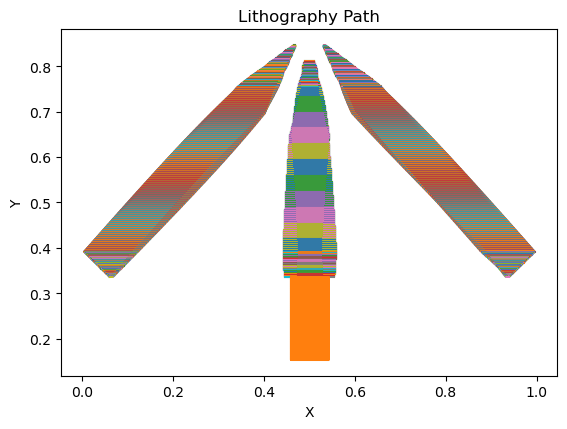

In [14]:
plot_lithography_path(new_path)

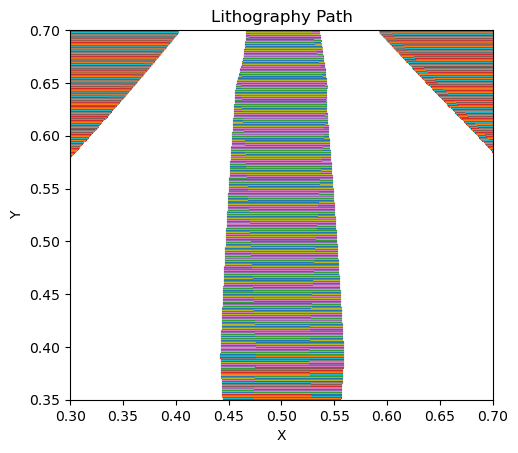

In [15]:
plot_lithography_path(new_path, x_lim = (0.3,0.7), y_lim = (0.35,0.7))

### Now print it in the format needed for MATE

In [18]:
print(f"path = {new_path};")


path = [[[0.5649431832363864, 0.00125], [0.43805681676361363, 0.00125], [0.4404431832363863, 0.00275], [0.5625568167636136, 0.00275], [0.5649431832363864, 0.00425], [0.43805681676361363, 0.00425], [0.4404431832363863, 0.00575], [0.5625568167636136, 0.00575], [0.5649431832363864, 0.00725], [0.43805681676361363, 0.00725], [0.4404431832363863, 0.00875], [0.5625568167636136, 0.00875], [0.5649431832363864, 0.01025], [0.43805681676361363, 0.01025], [0.4404431832363863, 0.01175], [0.5625568167636136, 0.01175], [0.5649431832363864, 0.01325], [0.43805681676361363, 0.01325], [0.4404431832363863, 0.01475], [0.5625568167636136, 0.01475], [0.5649431832363864, 0.01625], [0.43805681676361363, 0.01625], [0.4404431832363863, 0.01775], [0.5625568167636136, 0.01775], [0.5649431832363864, 0.01925], [0.43805681676361363, 0.01925], [0.4404431832363863, 0.02075], [0.5625568167636136, 0.02075], [0.5649431832363864, 0.02225], [0.43805681676361363, 0.02225], [0.4404431832363863, 0.02375], [0.5625568167636136, 0